# Broiler Chicken Price Forecasting Using different Statistical, ML and DL models

In [1]:
!pip install \
pmdarima \
gluonts \
utils \
mxnet --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
# import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2025-06-20 18:28:25.483682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750444105.776583      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750444105.859086      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


# 📚 Time series analysis and transforms

* Time series decomposition
  * Level
  * Trend
  * Seasonality
  * Noise

* Stationarity
  * AC and PAC plots
  * Rolling mean and std
  * Dickey-Fuller test

* Making time series stationary
  * Difference transform
  * Log scale
  * Smoothing
  * Moving average

## Load the dataset and quick preview

In [3]:
df = pd.read_excel('/kaggle/input/eu-broiler-price-dataset/merged_dataset_2.xlsx', parse_dates=['End Date'])
df.set_index('End Date', inplace=True)
df.head()

Price (€/100kg)  Feed Wheat  Wheat Feed  Feed Barley  Soya Beans  \
End Date                                                                       
2009-01-04         187.2040       105.1        80.9         94.1       275.1   
2009-01-11         189.4312       105.1        80.9         94.1       275.1   
2009-01-18         187.4148       105.1        80.9         94.1       275.1   
2009-01-25         181.7453       105.1        80.9         94.1       275.1   
2009-02-01         181.7786       112.0        86.2        100.9       254.0   

            Soya Bean Meal  Rape Seed Meal  Maize Gluten Feed  Molasses  \
End Date                                                                  
2009-01-04           290.5           142.0              145.5     127.2   
2009-01-11           290.5           142.0              145.5     127.2   
2009-01-18           290.5           142.0              145.5     127.2   
2009-01-25           290.5           142.0              145.5     127.2   
2009-02-01           290.5           164.0              155.5     127.1   

            Wheat Straw  Field Beans  Field Peas  Oilseed Rape  \
End Date                                                         
2009-01-04        114.3         67.0        50.4         259.7   
2009-01-11        114.3         67.0        50.4         259.7   
2009-01-18        114.3         67.0        50.4         259.7   
2009-01-25        114.3         67.0        50.4         259.7   
2009-02-01        130.8         67.8        51.6         249.9   

            Food_Inflation_Rate  
End Date                         
2009-01-04                  3.6  
2009-01-11                  3.6  
2009-01-18                  3.6  
2009-01-25                  3.6  
2009-02-01                  3.5

In [20]:
df

Price (€/100kg)  Feed Wheat  Wheat Feed  Feed Barley  Soya Beans  \
End Date                                                                       
2009-01-04         187.2040       105.1        80.9         94.1       275.1   
2009-01-11         189.4312       105.1        80.9         94.1       275.1   
2009-01-18         187.4148       105.1        80.9         94.1       275.1   
2009-01-25         181.7453       105.1        80.9         94.1       275.1   
2009-02-01         181.7786       112.0        86.2        100.9       254.0   
...                     ...         ...         ...          ...         ...   
2024-12-01         273.6055       185.4       142.7        159.7       323.2   
2024-12-08         273.7893       185.4       142.7        159.7       323.2   
2024-12-15         273.9845       185.4       142.7        159.7       323.2   
2024-12-22         275.4528       185.4       142.7        159.7       323.2   
2024-12-29         277.6783       185.4       142.7        159.7       323.2   

            Soya Bean Meal  Rape Seed Meal  Maize Gluten Feed  Molasses  \
End Date                                                                  
2009-01-04           290.5           142.0              145.5     127.2   
2009-01-11           290.5           142.0              145.5     127.2   
2009-01-18           290.5           142.0              145.5     127.2   
2009-01-25           290.5           142.0              145.5     127.2   
2009-02-01           290.5           164.0              155.5     127.1   
...                    ...             ...                ...       ...   
2024-12-01           336.5           261.8              208.8     289.0   
2024-12-08           336.5           261.8              208.8     289.0   
2024-12-15           336.5           261.8              208.8     289.0   
2024-12-22           336.5           261.8              208.8     289.0   
2024-12-29           336.5           261.8              208.8     289.0   

            Wheat Straw  Field Beans  Field Peas  Oilseed Rape  \
End Date                                                         
2009-01-04        114.3         67.0        50.4         259.7   
2009-01-11        114.3         67.0        50.4         259.7   
2009-01-18        114.3         67.0        50.4         259.7   
2009-01-25        114.3         67.0        50.4         259.7   
2009-02-01        130.8         67.8        51.6         249.9   
...                 ...          ...         ...           ...   
2024-12-01         67.5        218.6       238.8         418.6   
2024-12-08         67.5        218.6       238.8         418.6   
2024-12-15         67.5        218.6       238.8         418.6   
2024-12-22         67.5        218.6       238.8         418.6   
2024-12-29         67.5        218.6       238.8         418.6   

            Food_Inflation_Rate  
End Date                         
2009-01-04                  3.6  
2009-01-11                  3.6  
2009-01-18                  3.6  
2009-01-25                  3.6  
2009-02-01                  3.5  
...                         ...  
2024-12-01                  2.4  
2024-12-08                  2.4  
2024-12-15                  2.4  
2024-12-22                  2.4  
2024-12-29                  2.4  

[835 rows x 14 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835 entries, 2009-01-04 to 2024-12-29
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price (€/100kg)      835 non-null    float64
 1   Feed Wheat           835 non-null    float64
 2   Wheat Feed           835 non-null    float64
 3   Feed Barley          835 non-null    float64
 4   Soya Beans           835 non-null    float64
 5   Soya Bean Meal       835 non-null    float64
 6   Rape Seed Meal       835 non-null    float64
 7   Maize Gluten Feed    835 non-null    float64
 8   Molasses             835 non-null    float64
 9   Wheat Straw          835 non-null    float64
 10  Field Beans          835 non-null    float64
 11  Field Peas           835 non-null    float64
 12  Oilseed Rape         835 non-null    float64
 13  Food_Inflation_Rate  835 non-null    float64
dtypes: float64(14)
memory usage: 97.9 KB


In [5]:
df.describe()

Price (€/100kg)  Feed Wheat  Wheat Feed  Feed Barley  Soya Beans  \
count       835.000000  835.000000  835.000000   835.000000  835.000000   
mean        203.910355  161.100000  124.051976   142.425988  338.706587   
std          31.613433   43.381611   33.405276    40.938288   82.190479   
min         160.943800   88.000000   67.800000    75.700000  234.000000   
25%         184.708400  131.750000  101.500000   116.100000  285.900000   
50%         192.201000  160.900000  123.900000   136.900000  310.100000   
75%         202.953800  187.100000  144.100000   164.150000  376.000000   
max         283.930500  322.200000  248.100000   299.500000  591.000000   

       Soya Bean Meal  Rape Seed Meal  Maize Gluten Feed   Molasses  \
count      835.000000      835.000000         835.000000  835.00000   
mean       365.750299      226.909222         207.192575  203.77509   
std         71.199860       64.608947          59.425572   50.20090   
min        253.000000      120.000000         124.000000   92.90000   
25%        314.500000      184.000000         169.000000  176.05000   
50%        343.000000      209.000000         192.000000  193.50000   
75%        405.000000      265.500000         228.400000  232.50000   
max        570.300000      432.300000         378.000000  331.50000   

       Wheat Straw  Field Beans  Field Peas  Oilseed Rape  Food_Inflation_Rate  
count   835.000000   835.000000  835.000000    835.000000           835.000000  
mean     69.837605   189.144671  176.015569    349.473772             3.009341  
std      27.582877    63.355016   71.002043     95.368537             4.087222  
min      39.000000    64.700000   44.200000    224.200000            -1.000000  
25%      52.000000   135.700000  129.300000    287.550000             0.800000  
50%      60.000000   200.000000  192.600000    327.500000             2.100000  
75%      73.800000   235.300000  231.200000    379.500000             3.200000  
max     178.000000   328.000000  311.000000    815.800000            19.200000

### Check each feature values

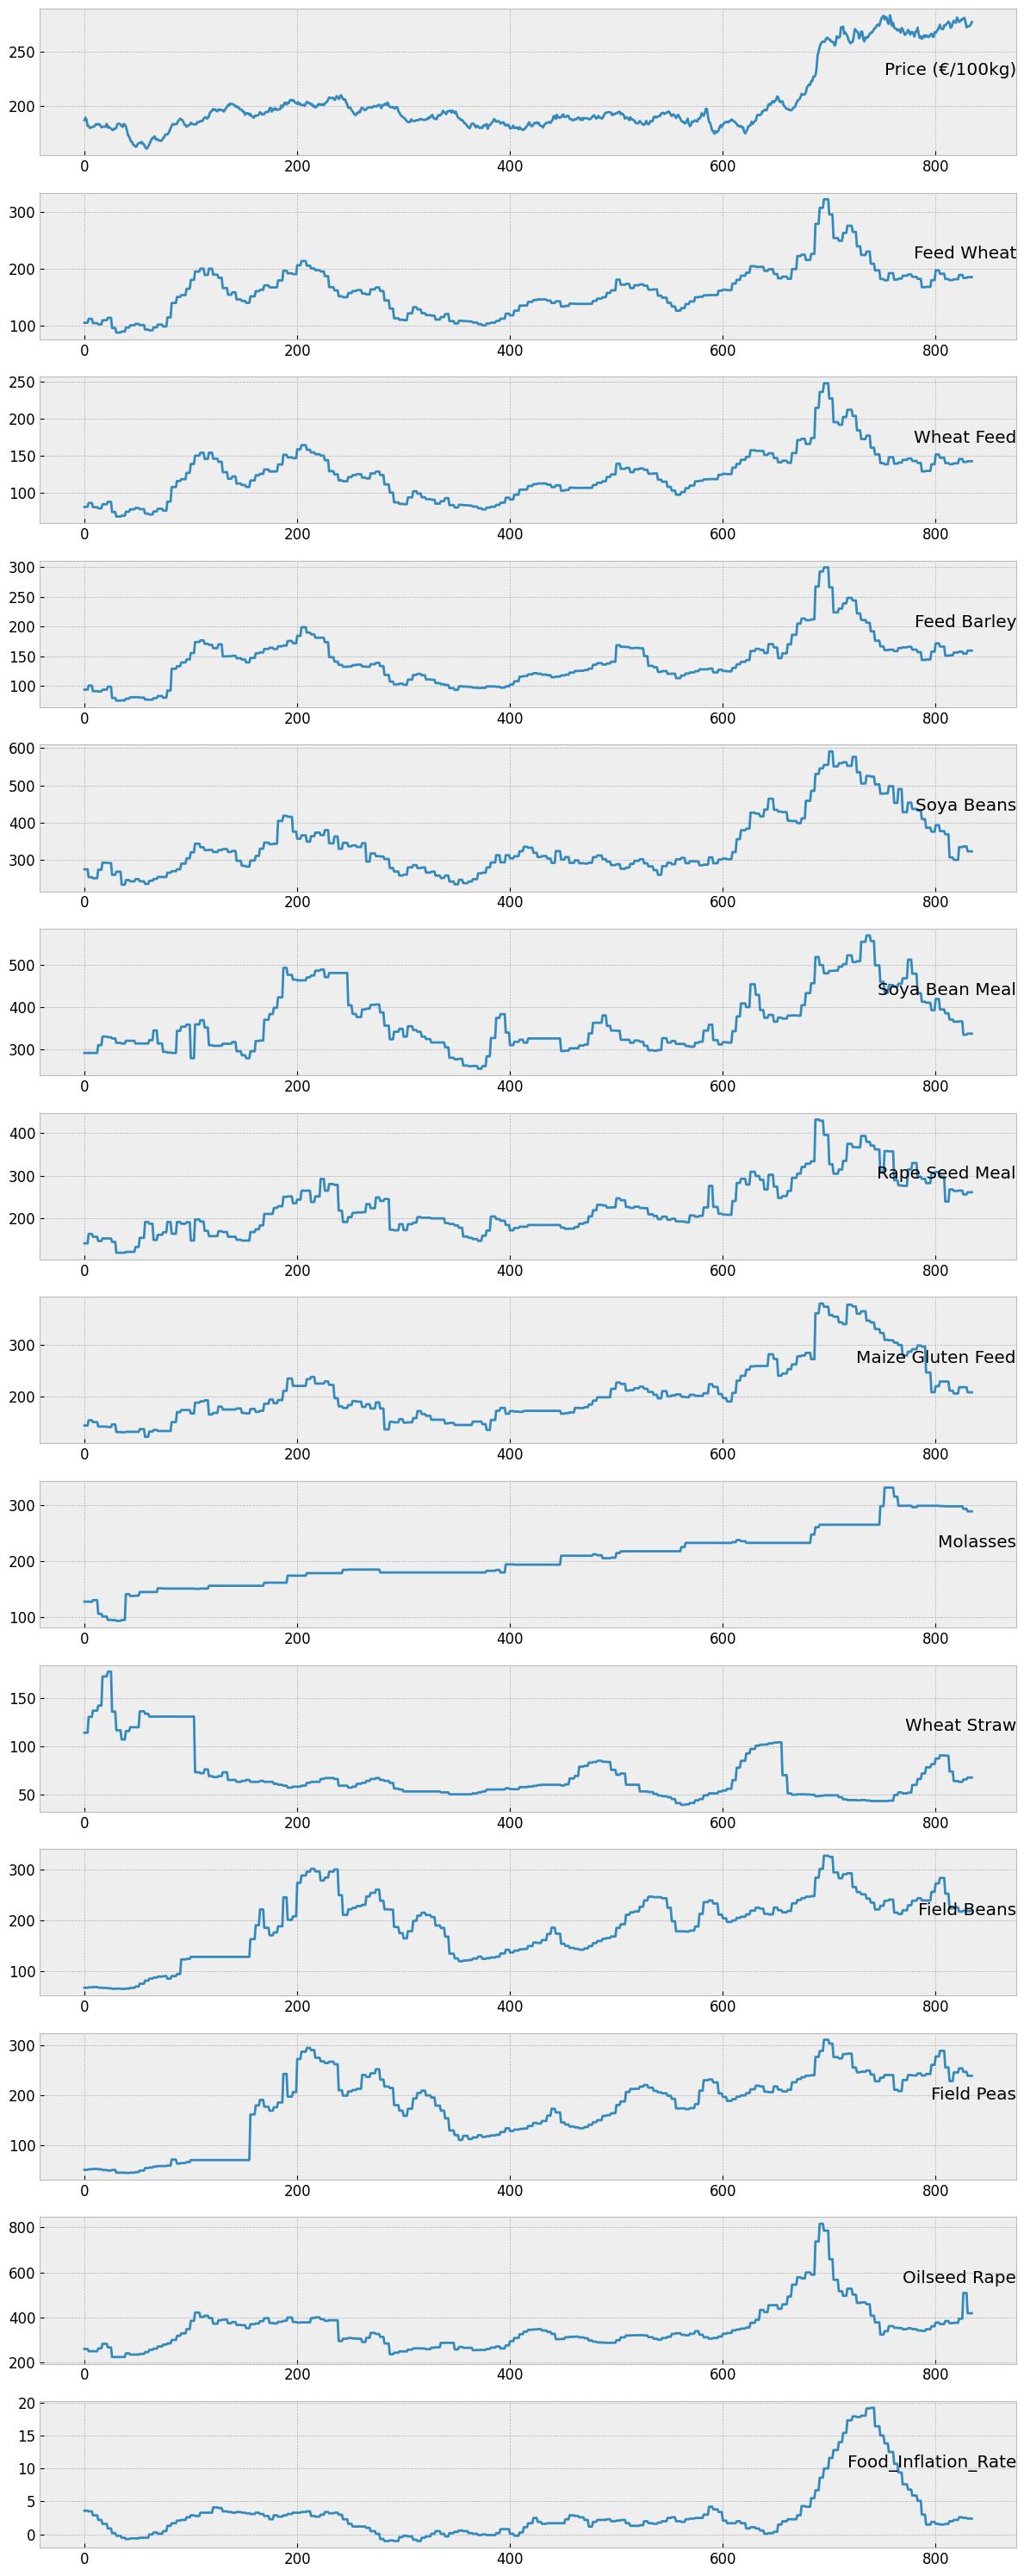

In [7]:
values = df.values
groups = list(range(14))
plt.figure(figsize=(12, 30))

# plot each column
for i, group in enumerate(groups, 1):
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')

plt.tight_layout()
plt.show()

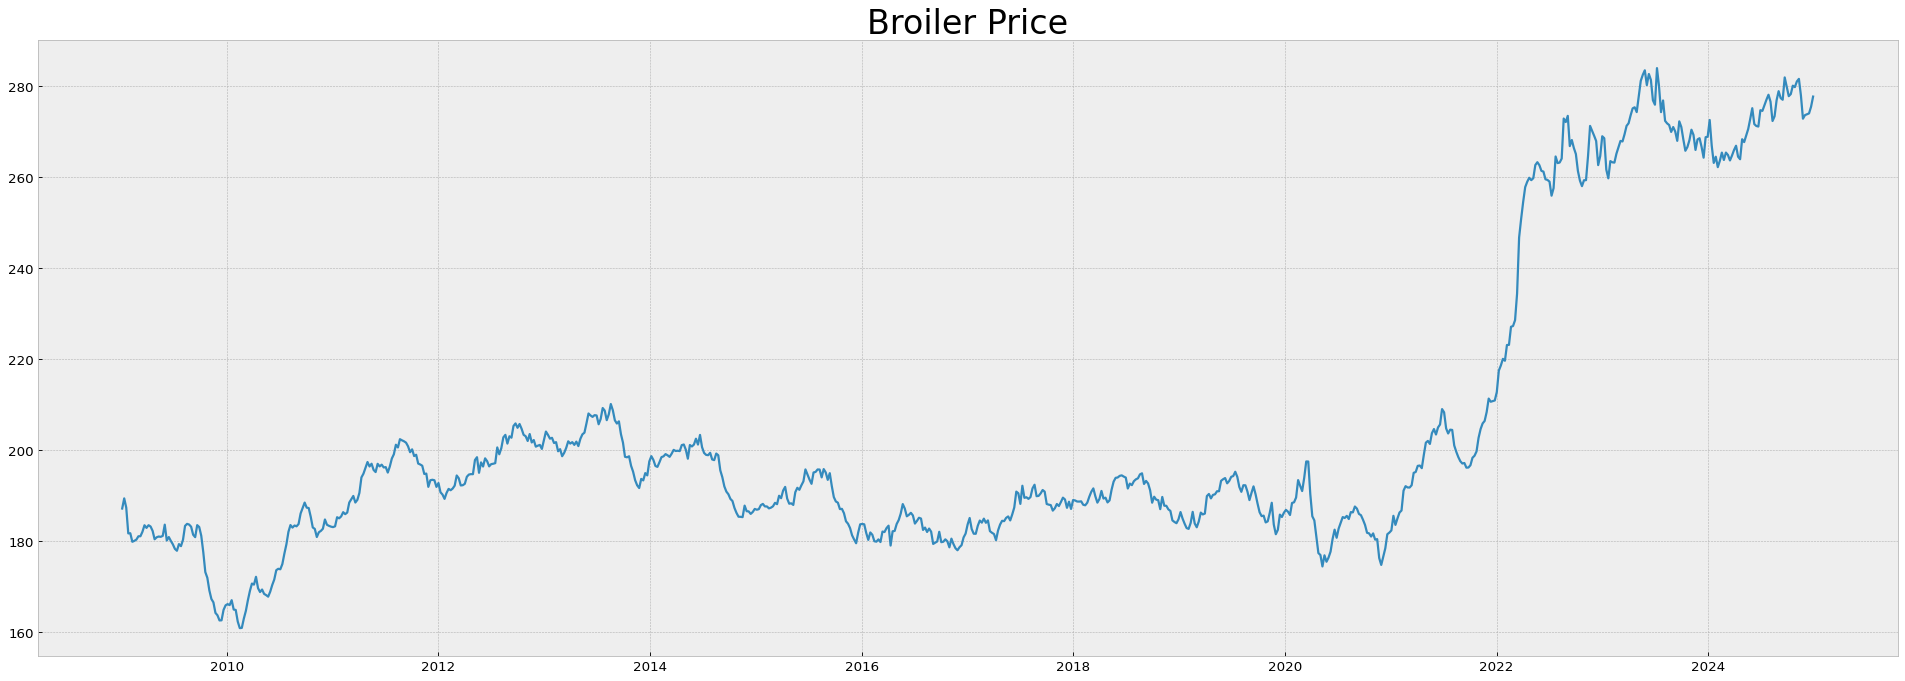

In [8]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Broiler Price', fontsize=30)

plt.plot(df['Price (€/100kg)'])

## Decomposing our time series

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model

`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time

##### Multiplicative model

`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is **curved** and seasonality is not constant. Change is not constant over time

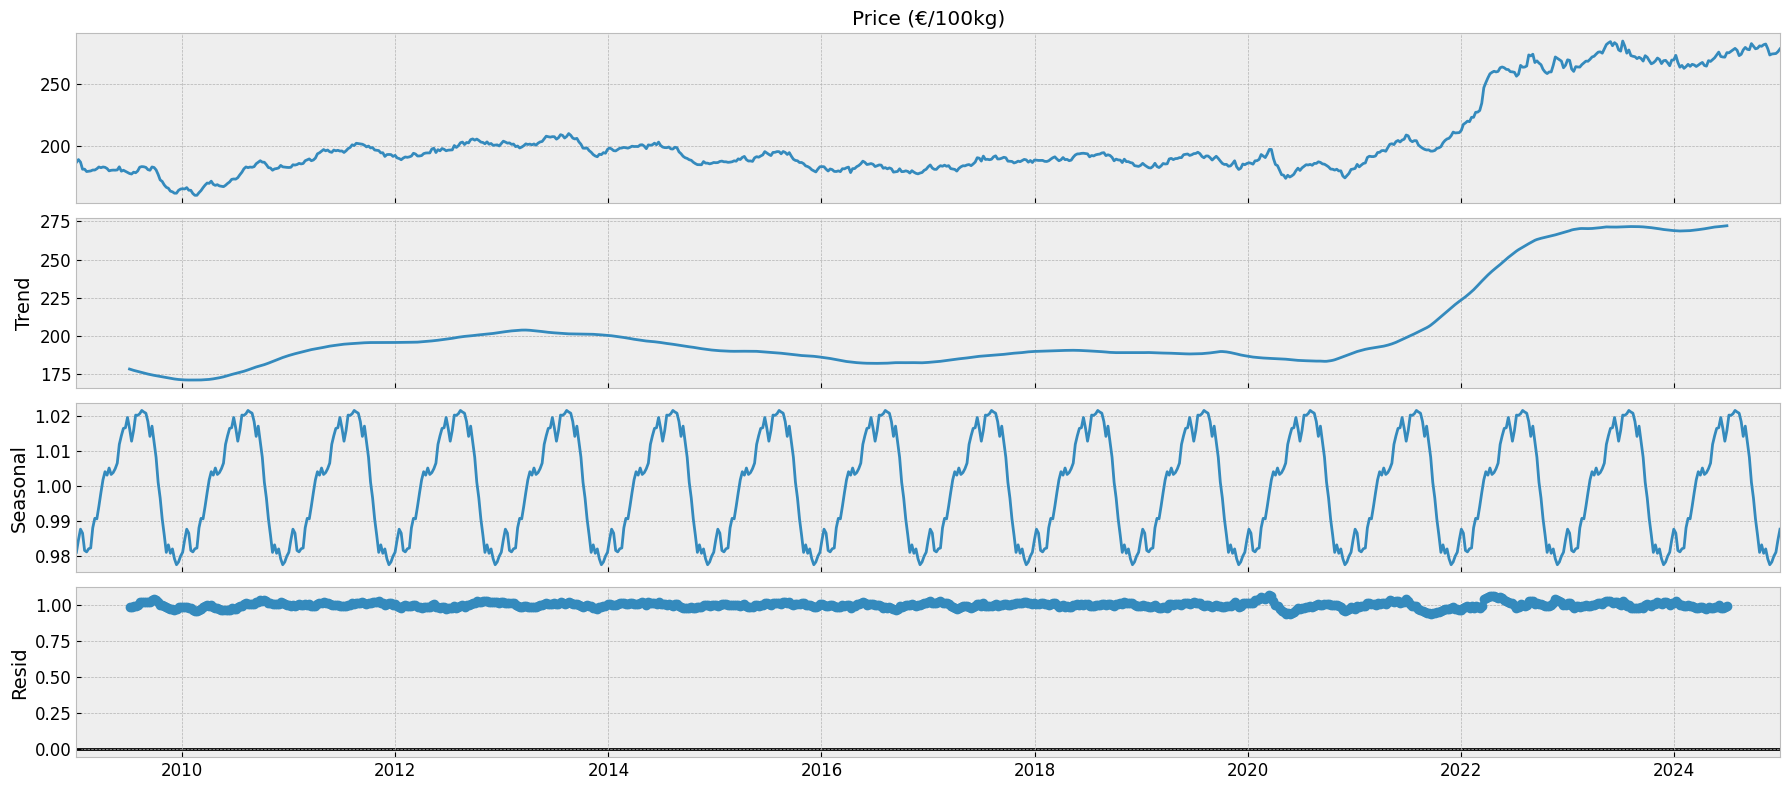

<Figure size 4000x1600 with 0 Axes>

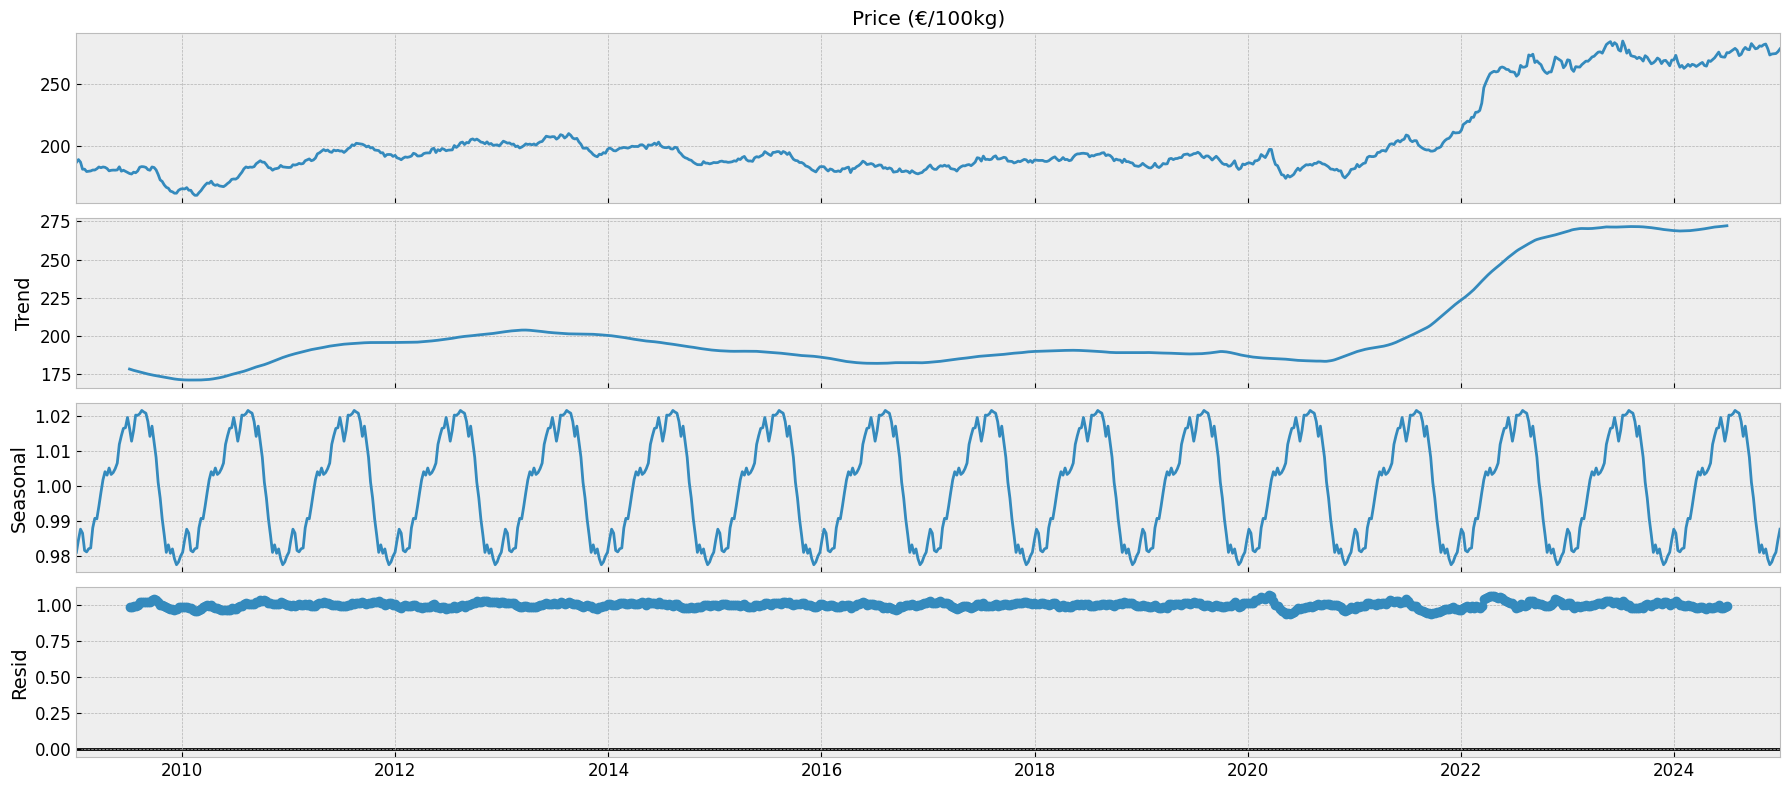

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df['Price (€/100kg)']
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### Level

Level simply means the current value of the series once we remove trend, seasonality and the random noise. This are the true values that come from the series itself and we will try to predict with our models. Most of the models will benefit the more our time series is composed by the level and not trends/seasonality/noise. We also present models capable of handling seasonality and trend (non stationary series)

### Trend

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend

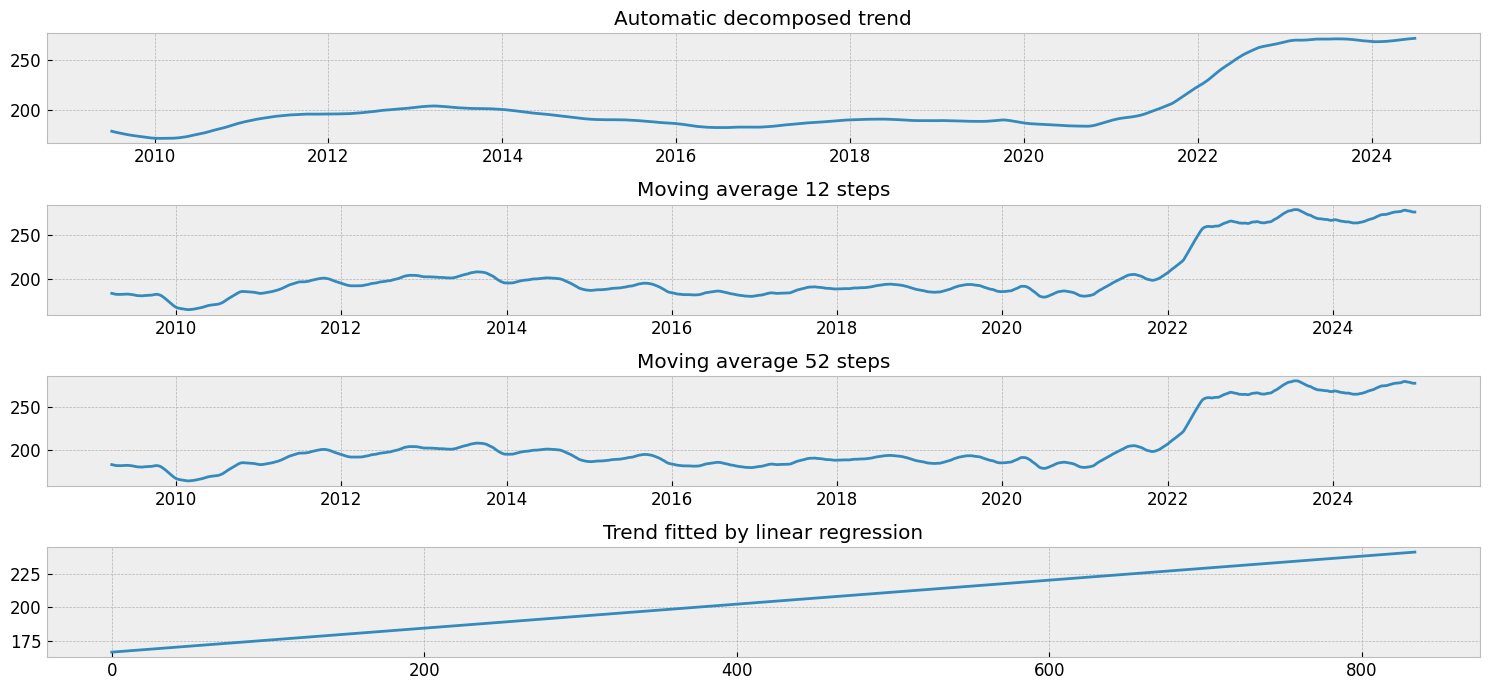

In [12]:
fig = plt.figure(figsize=(15, 7))
layout = (4, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
mv_ax52 = plt.subplot2grid(layout, (2, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (3, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df['Price (€/100kg)'].rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")

mm52 = df['Price (€/100kg)'].rolling(52).mean()
mv_ax52.plot(mm)
mv_ax52.set_title("Moving average 52 steps")


X = [i for i in range(0, len(df['Price (€/100kg)']))]
X = np.reshape(X, (len(X), 1))
y = df['Price (€/100kg)']
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

1. **Automatic Decomposed Trend:** This plot isolates the long-term trend in the dataset. From what I see, the price remained relatively stable from 2010 to 2020, followed by a noticeable upward trend from 2020 to 2024.

2. **Moving Average (12 Steps):** The 12-step moving average smooths short-term fluctuations and highlights the mid-term trend. The data shows moderate fluctuations early on, but a strong upward movement from 2020 onwards.

3. **Moving Average (52 Steps):** The 52-step moving average provides an even longer-term view of trends. This line follows a similar pattern—stable prices from 2010 to 2020 and an accelerating rise afterward.

4. **Linear Regression Fitted Trend:** The linear regression model provides a simplified trend representation. Here, the fitted trend suggests a steady increase over the entire period from 2010 to 2024.

Overall, the dataset indicates a significant price increase in recent years, particularly after 2020. The moving averages confirm this trend, and the linear regression further solidifies the observation of upward movement.

### Seasonality

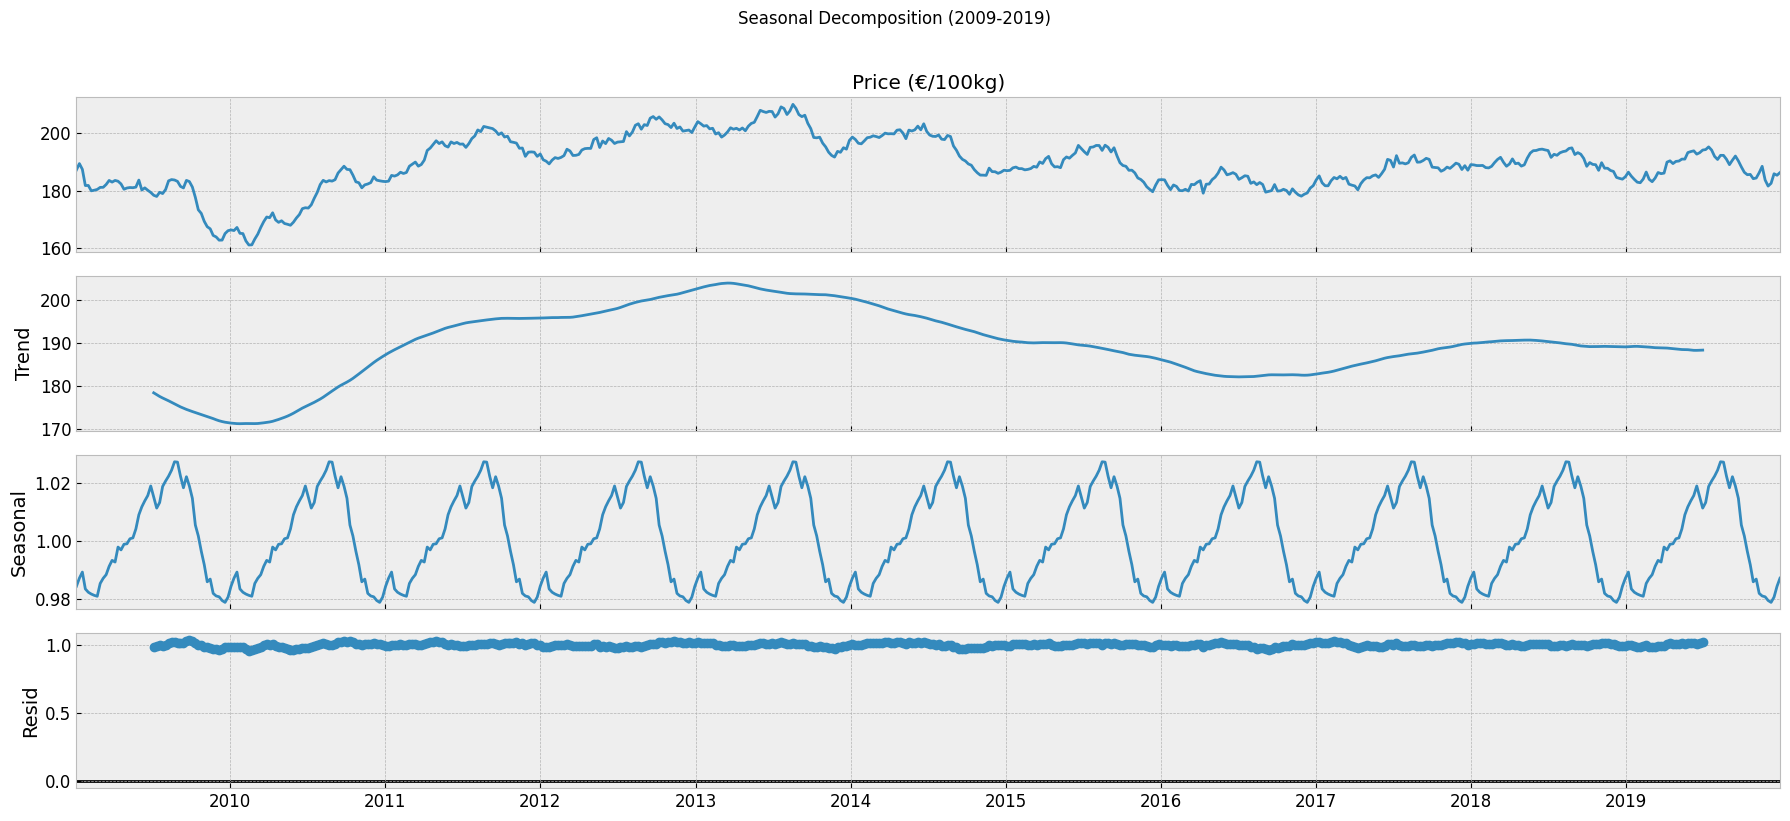

In [13]:
# Set figure size
plt.rcParams['figure.figsize'] = 18, 8

# Decompose the series (multiplicative model)
series = df['Price (€/100kg)']
result = seasonal_decompose(series, model='multiplicative')

year = series['2009':'2019']

result_first = seasonal_decompose(year, model='multiplicative')
result_first.plot()
plt.suptitle('Seasonal Decomposition (2009-2019)', y=1.02)
plt.tight_layout()
plt.show()

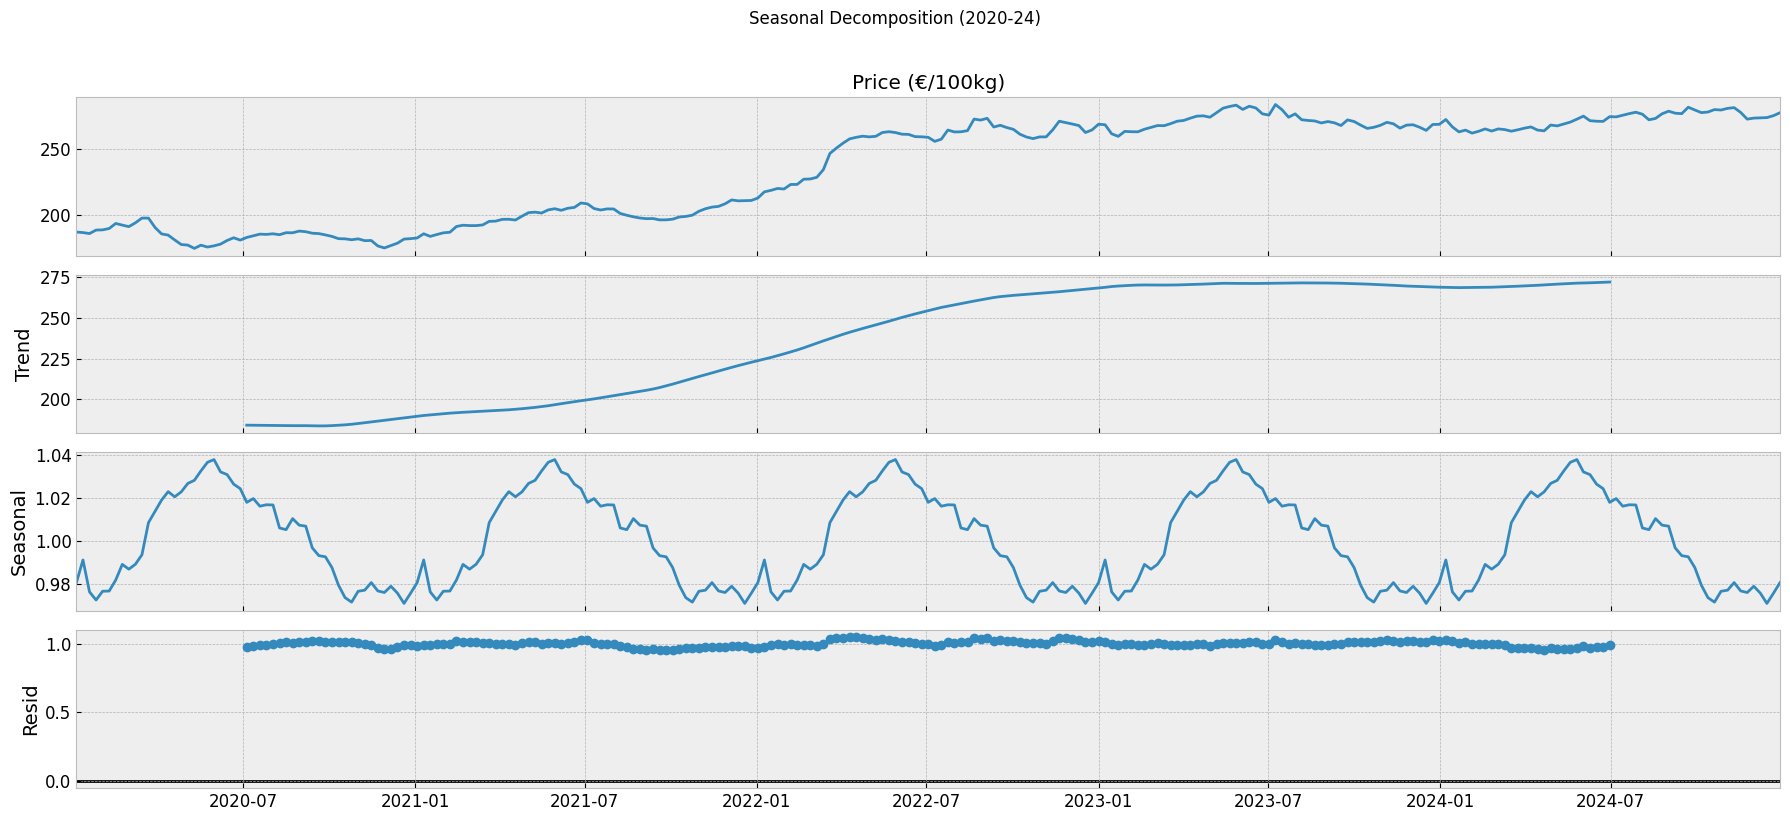

In [16]:
# Set figure size
plt.rcParams['figure.figsize'] = 18, 8

# Decompose the series (multiplicative model)
series = df['Price (€/100kg)']
result = seasonal_decompose(series, model='multiplicative')

year = series['2020':'2024']

# Decompose only the last 5 years
result_first_year = seasonal_decompose(year, model='multiplicative')
result_first_year.plot()
plt.suptitle('Seasonal Decomposition (2020-24)', y=1.02)
plt.tight_layout()
plt.show()

### Seasonal component

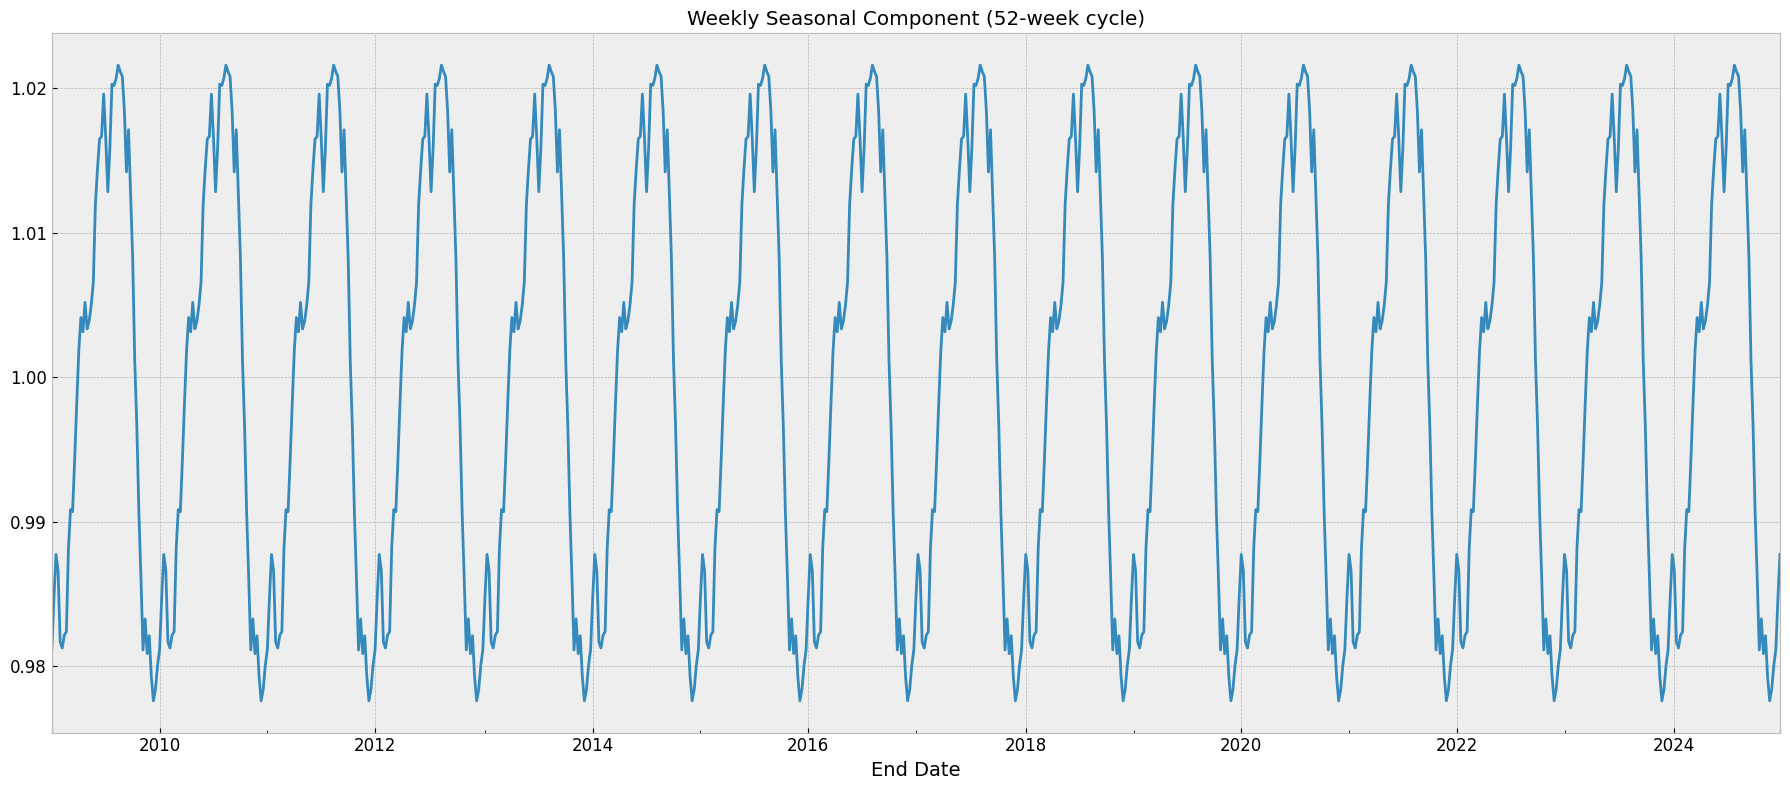

In [14]:
result = seasonal_decompose(df['Price (€/100kg)'], model='multiplicative', period=52)
result.seasonal.plot(title='Weekly Seasonal Component (52-week cycle)')
plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Step 1: Add 'month' and 'year' columns
df['month'] = df.index.month
df['year'] = df.index.year

# Step 2: Group by year and month to get monthly average prices
df_plot = (
    df.groupby(['month', 'year'])[['Price (€/100kg)']]
    .mean()
    .reset_index()
)

# Step 3: Prepare color palette
np.random.seed(42)
years = df_plot['year'].unique()
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Step 4: Plot seasonal line plot
plt.figure(figsize=(16, 10))
for i, y in enumerate(years):
    if i > 0:  # Optionally skip the first year if partial data
        yearly_data = df_plot[df_plot['year'] == y]
        plt.plot('month', 'Price (€/100kg)', data=yearly_data, color=colors[i], label=y)

        # Add year labels to end of each line
        last_month = yearly_data['month'].max()
        last_price = yearly_data[yearly_data['month'] == last_month]['Price (€/100kg)'].values[0]
        x_offset = 0.2 if y == years[-1] else 0.1
        plt.text(last_month + x_offset, last_price, str(y), fontsize=11, color=colors[i])

# Step 5: Customize plot
plt.title("Seasonal Plot - Monthly Average Broiler Chicken Prices", fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Price (€/100kg)", fontsize=14)
plt.xticks(ticks=np.arange(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Manual methods to find seasonalities**

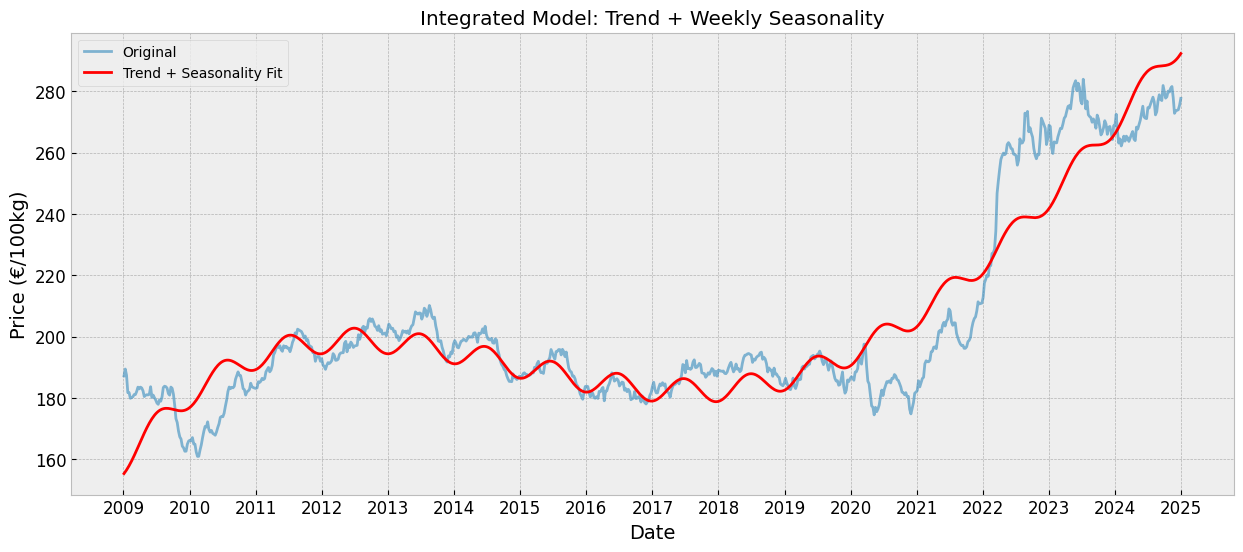

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

# Extract data
dates = df.index
y = df['Price (€/100kg)'].values
n = len(y)

# Create features: trend (time index) + seasonality (week-of-year)
trend = np.arange(n)  # Linear trend feature
season = np.array([i % 52 for i in range(n)])  # Cyclic weekly seasonality (52 weeks/year)

# Design matrix: combine trend (up to quadratic) + seasonal terms
X = np.column_stack([
    trend,              # Linear trend
    trend**2,           # Quadratic trend (optional)
    trend**3,
    trend**5,
    np.sin(2 * np.pi * season / 52),  # Fourier terms for seasonality
    np.cos(2 * np.pi * season / 52)
])

# Fit linear regression (more stable than polyfit for mixed terms)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(dates, y, label='Original', alpha=0.6)
plt.plot(dates, y_pred, color='red', label='Trend + Seasonality Fit', linewidth=2)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
plt.title("Integrated Model: Trend + Weekly Seasonality")
plt.xlabel("Date")
plt.ylabel("Price (€/100kg)")
plt.legend()
plt.grid(True)
plt.show()

## White Noise Test

White noise check considerations:

* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
* Correlation plots
* Standard deviation distribution, is it a Gaussian distribution?
* Does the mean or level change over time?
* Statistical test

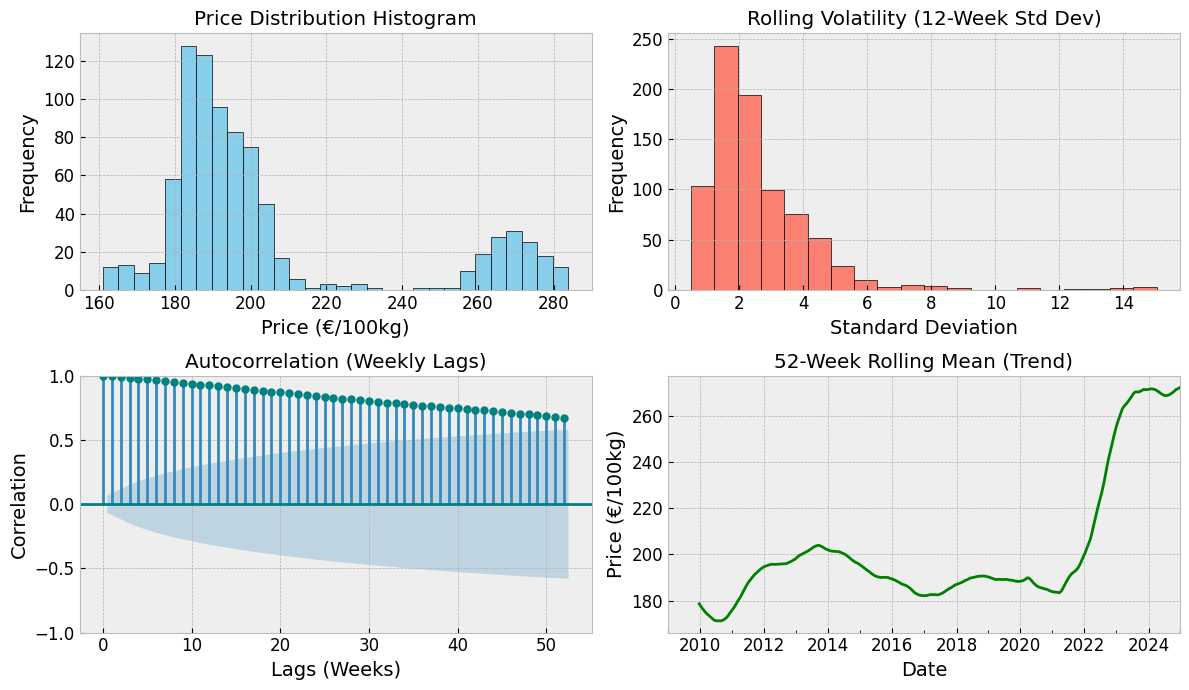

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Set up figure and subplots
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

# 1. Histogram of original series
df['Price (€/100kg)'].hist(ax=hist_ax, bins=30, color='skyblue', edgecolor='black')
hist_ax.set_title("Price Distribution Histogram")
hist_ax.set_xlabel("Price (€/100kg)")
hist_ax.set_ylabel("Frequency")

# 2. Autocorrelation (ACF) plot
plot_acf(df['Price (€/100kg)'], lags=52, ax=ac_ax, color='teal')  # 52 lags = 1 year
ac_ax.set_title("Autocorrelation (Weekly Lags)")
ac_ax.set_xlabel("Lags (Weeks)")
ac_ax.set_ylabel("Correlation")

# 3. Rolling standard deviation (volatility)
rolling_std = df['Price (€/100kg)'].rolling(window=12).std()  # 12 weeks ≈ quarterly volatility
rolling_std.hist(ax=hist_std_ax, bins=20, color='salmon', edgecolor='black')
hist_std_ax.set_title("Rolling Volatility (12-Week Std Dev)")
hist_std_ax.set_xlabel("Standard Deviation")
hist_std_ax.set_ylabel("Frequency")

# 4. Rolling mean (trend)
rolling_mean = df['Price (€/100kg)'].rolling(window=52).mean()  # 52 weeks ≈ yearly trend
rolling_mean.plot(ax=mean_ax, color='green')
mean_ax.set_title("52-Week Rolling Mean (Trend)")
mean_ax.set_xlabel("Date")
mean_ax.set_ylabel("Price (€/100kg)")
mean_ax.grid(True)

plt.tight_layout()
plt.show()

No White Noise.

| Evidence | Output | Why white-noise fails |
|----------|--------------|-----------------------|
| **ACF plot** | Big positive bars from lag 1 all the way out to ~50 weeks, many well outside the blue 95 % limits | For white noise, *every* bar (except lag 0) should sit inside the confidence bounds and wobble randomly around 0. Persistent positive autocorrelation ⇒ structure, not randomness. |
| **52-week rolling mean** | A smooth curve that drifts sideways 2010-2020 and then rockets upward after 2020 | White noise has a flat mean; a moving average of pure noise should be essentially a horizontal line with tiny wiggles. A clear trend = non-stationary structure. |
| **Rolling 12-week volatility histogram** | Most values clustered 0–4 but a long tail out to ~14 | White noise has constant variance. The long right tail implies volatility clusters—periods where shocks grow bigger—again violating white-noise assumptions. |
| **Price histogram** | Skewed, multi-modal distribution (peak ~180 €/100 kg, another bulge above 220) | White noise is typically modeled as Gaussian (symmetric, single-mode). Skew and multiple modes point to underlying regimes or seasonality. |

• **Trend component**: Structural rise after 2020 (possibly feed-cost inflation, policy, demand shifts).  
• **Seasonality**: Repeating weekly or yearly cycles (those slow-decaying ACF bars).  
• **Volatility clustering**: Bigger price swings during certain periods (hinting at GARCH-type behavior).


### Ljung-Box Test (Statistical Test)

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(df['Price (€/100kg)'], lags=[20, 40, 52], return_df=True)
print(lb)

         lb_stat  lb_pvalue
20  14833.622189        0.0
40  26042.062105        0.0
52  31381.463307        0.0


The **Ljung-Box test** is checking whether the time series values are independent (i.e., no autocorrelation) up to the given lags (20, 40, and 52).

* **`lb_stat`**: The test statistic (higher = more evidence of autocorrelation).
* **`lb_pvalue`**: The p-value of the test (used to decide whether to reject the null hypothesis).

**OUTPUT:**

* For **all lags**, the **p-values are 0.0** (i.e., essentially **< 0.001**).
* This means we can **strongly reject the null hypothesis** of the Ljung-Box test.

So the series `df['Price (€/100kg)']` **has strong autocorrelation** up to lag 52.

* The time series is **not white noise**.
* Past values are influencing future values (dependence exists).

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

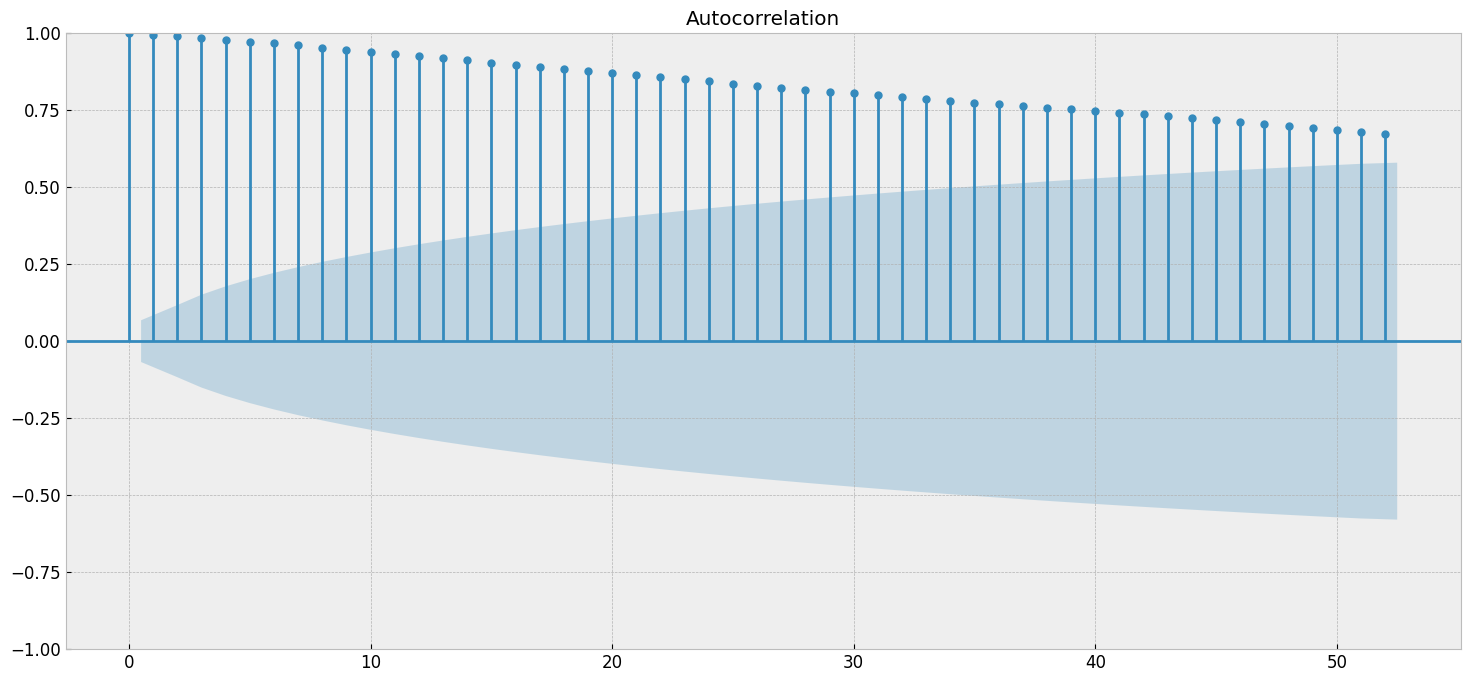

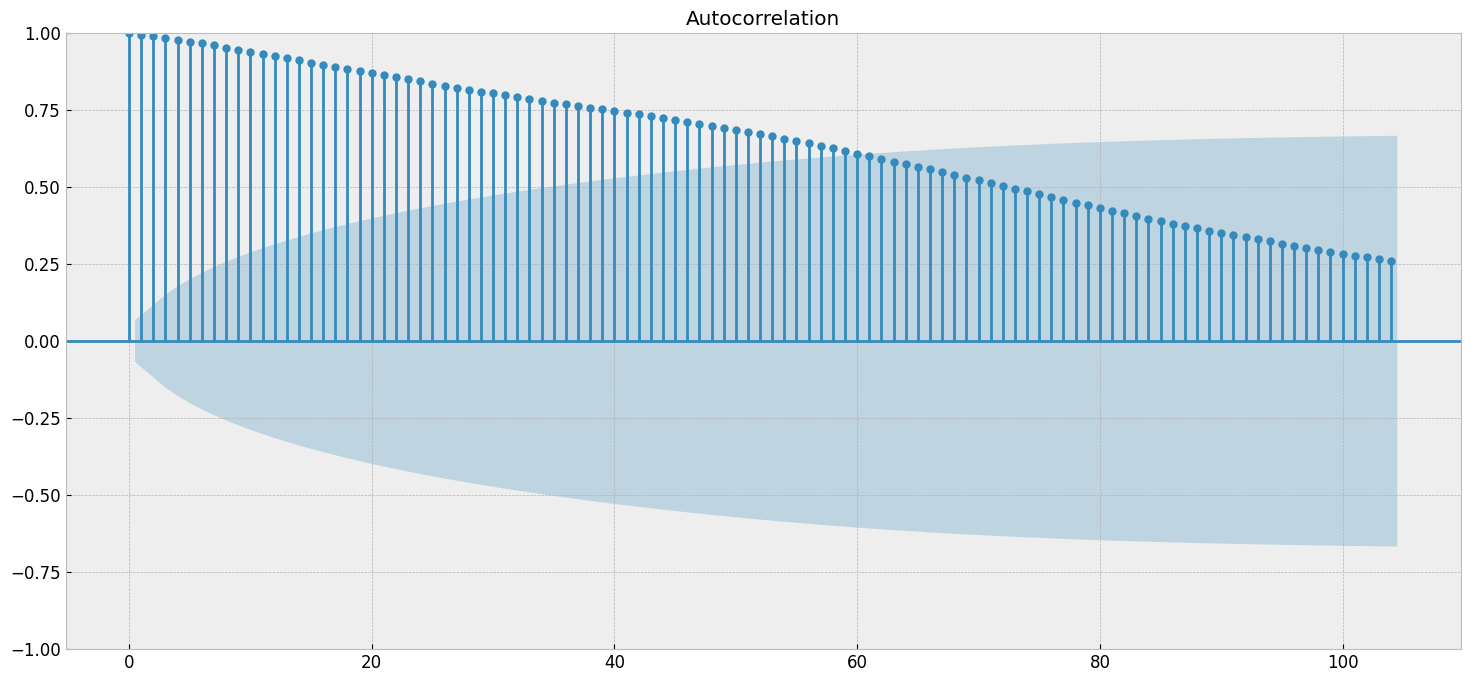

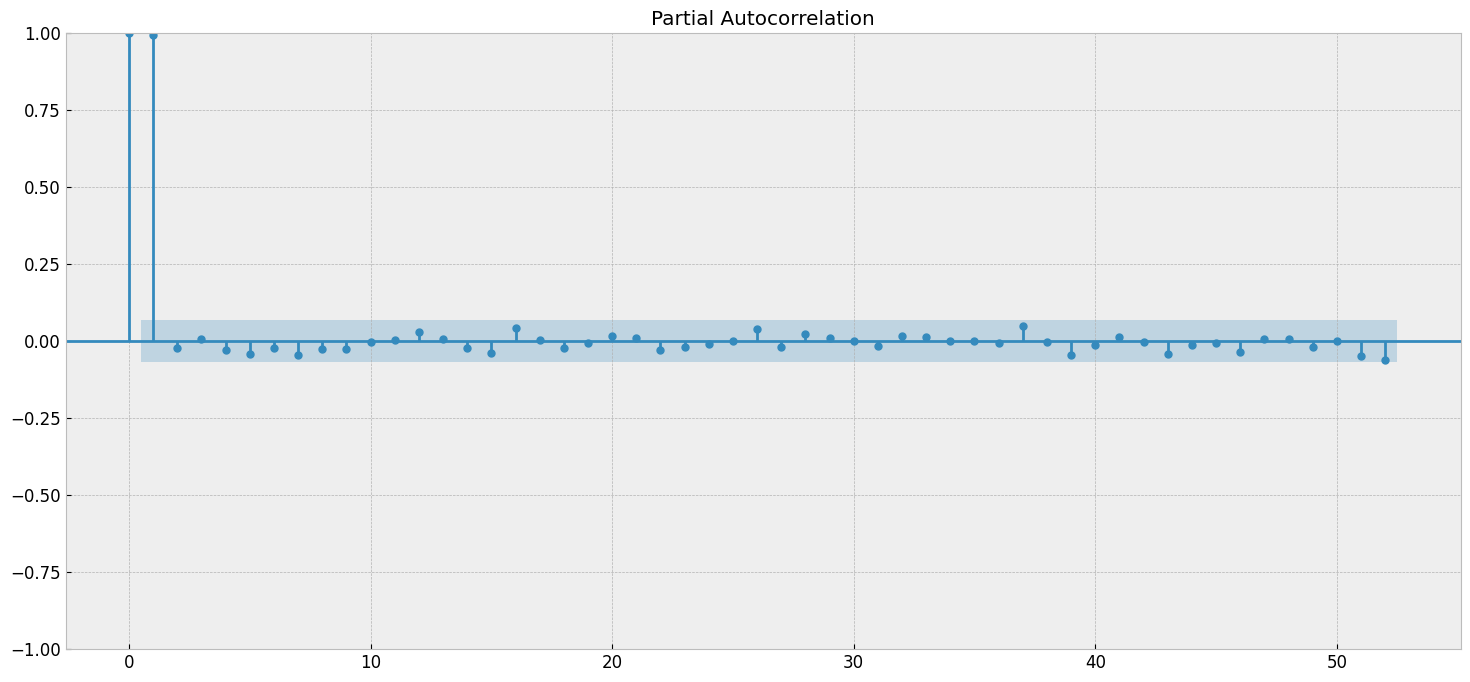

In [21]:
plot_acf(series, lags=52)
plot_acf(series, lags=104)
plot_pacf(series, lags=52)
plt.show()

## ACF plot

### 1 – Is the series already stationary?

Plot shows a long, gentle decay ➜ treat the raw series as **non-stationary** and difference it to transform it into a stationary series.

### 2 – Seasonality

| Visual cue | Interpretation | Decision |
|------------|---------------|----------|
| Sharp spike at lag **52** (or 12, 24… for monthly data) | Annual (weekly) seasonality | Add **seasonal differencing** `D = 1` (e.g. SARIMA) |

### 3 – MA order

Plot bars peter out rather than stop sharply, so a *short* pure-MA isn’t enough; Must be settle on an **ARIMA(p, d, q) where q ≤ 1 or 2**.


## PACF plot 

### Order of the autoregressive part  
Because the PACF **cuts off** after lag 2 (only the first two lags are significant), our series behaves like an **AR(2)** process once it’s been differenced/stationarised.  
&nbsp;&nbsp;→ In ARIMA notation that’s `ARIMA(p=2, d, q=0)` for the non-seasonal part.

### Rolling means and standard deviation of our series



We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

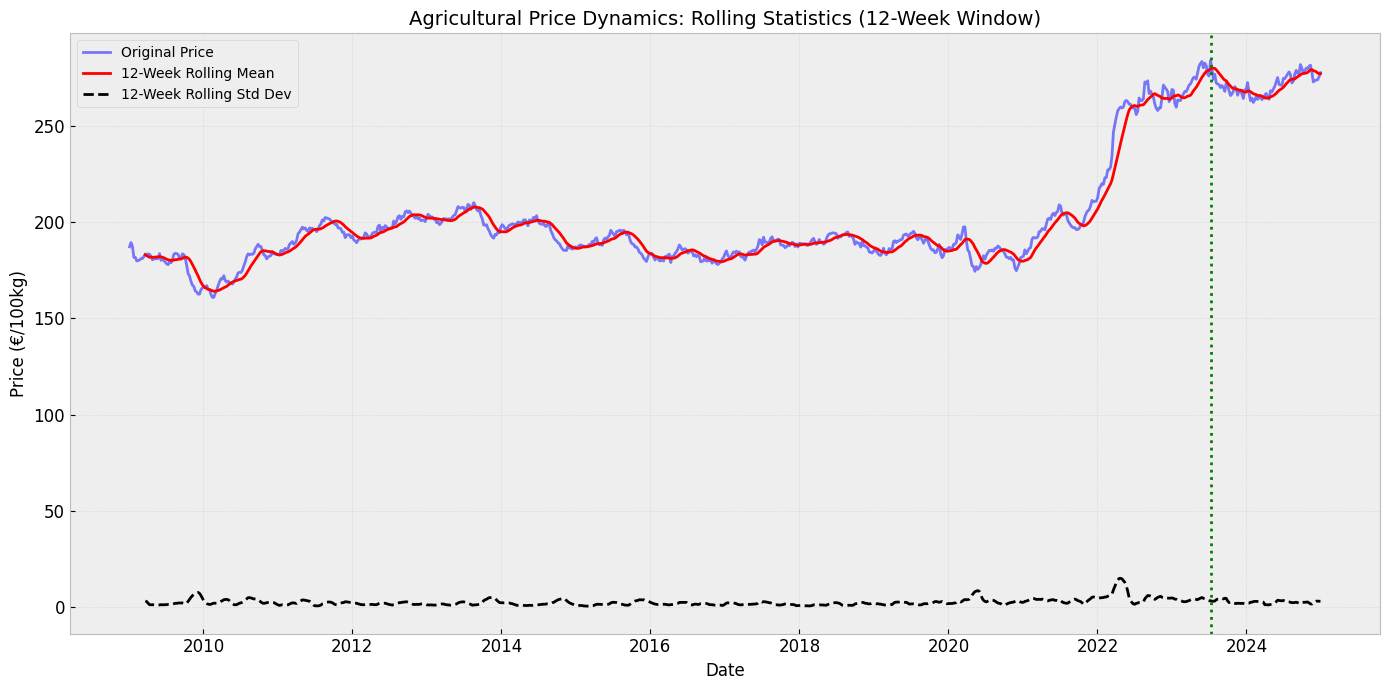

In [22]:
# Calculate rolling statistics (using 12 weeks ≈ quarterly analysis)
rolmean = df['Price (€/100kg)'].rolling(window=12).mean()  # Rolling mean
rolstd = df['Price (€/100kg)'].rolling(window=12).std()    # Rolling standard deviation

# Plot rolling statistics with improved styling
plt.figure(figsize=(14, 7))
plt.plot(df['Price (€/100kg)'], color='blue', alpha=0.5, label='Original Price')
plt.plot(rolmean, color='red', linewidth=2, label='12-Week Rolling Mean')
plt.plot(rolstd, color='black', linestyle='--', label='12-Week Rolling Std Dev')

# Customize plot
plt.title('Agricultural Price Dynamics: Rolling Statistics (12-Week Window)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Highlight key periods (example: price spikes)
max_price_date = df['Price (€/100kg)'].idxmax()
plt.axvline(x=max_price_date, color='green', linestyle=':', 
            label=f'Peak Price: {max_price_date.strftime("%Y-%m-%d")}')

plt.tight_layout()
plt.show()

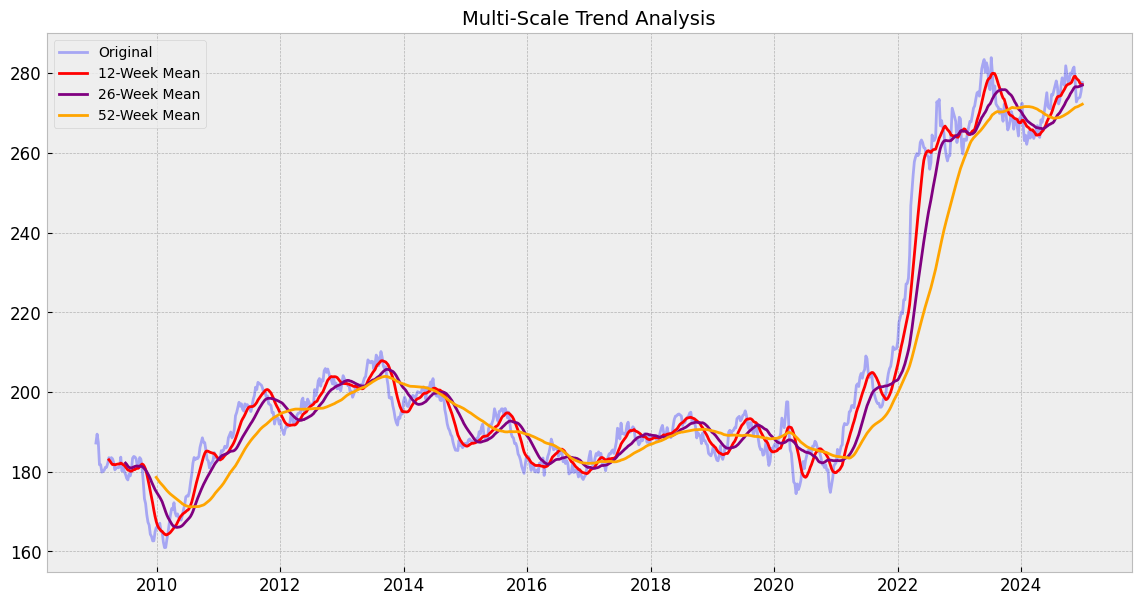

In [27]:
windows = [12, 26, 52]  # Quarterly, semi-annual, annual
colors = ['red', 'purple', 'orange']

plt.figure(figsize=(14, 7))
plt.plot(df['Price (€/100kg)'], color='blue', alpha=0.3, label='Original')

for w, c in zip(windows, colors):
    plt.plot(df['Price (€/100kg)'].rolling(w).mean(), 
             color=c, label=f'{w}-Week Mean')

plt.title('Multi-Scale Trend Analysis', fontsize=14)
plt.legend()
plt.show()

### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [4]:
# Stationarity check
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('The series is stationary.')
    else:
        print('The series is not stationary.')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] > 0.05  # Returns True if non-stationary

X = df['Price (€/100kg)']
check_stationarity(X)

ADF Statistic: 0.043951619033850066
p-value: 0.9620194016213786
The series is not stationary.
Critical Values:
   1%: -3.4382531800005944
   5%: -2.8650285052126057
   10%: -2.5686275714907825


True

Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :)

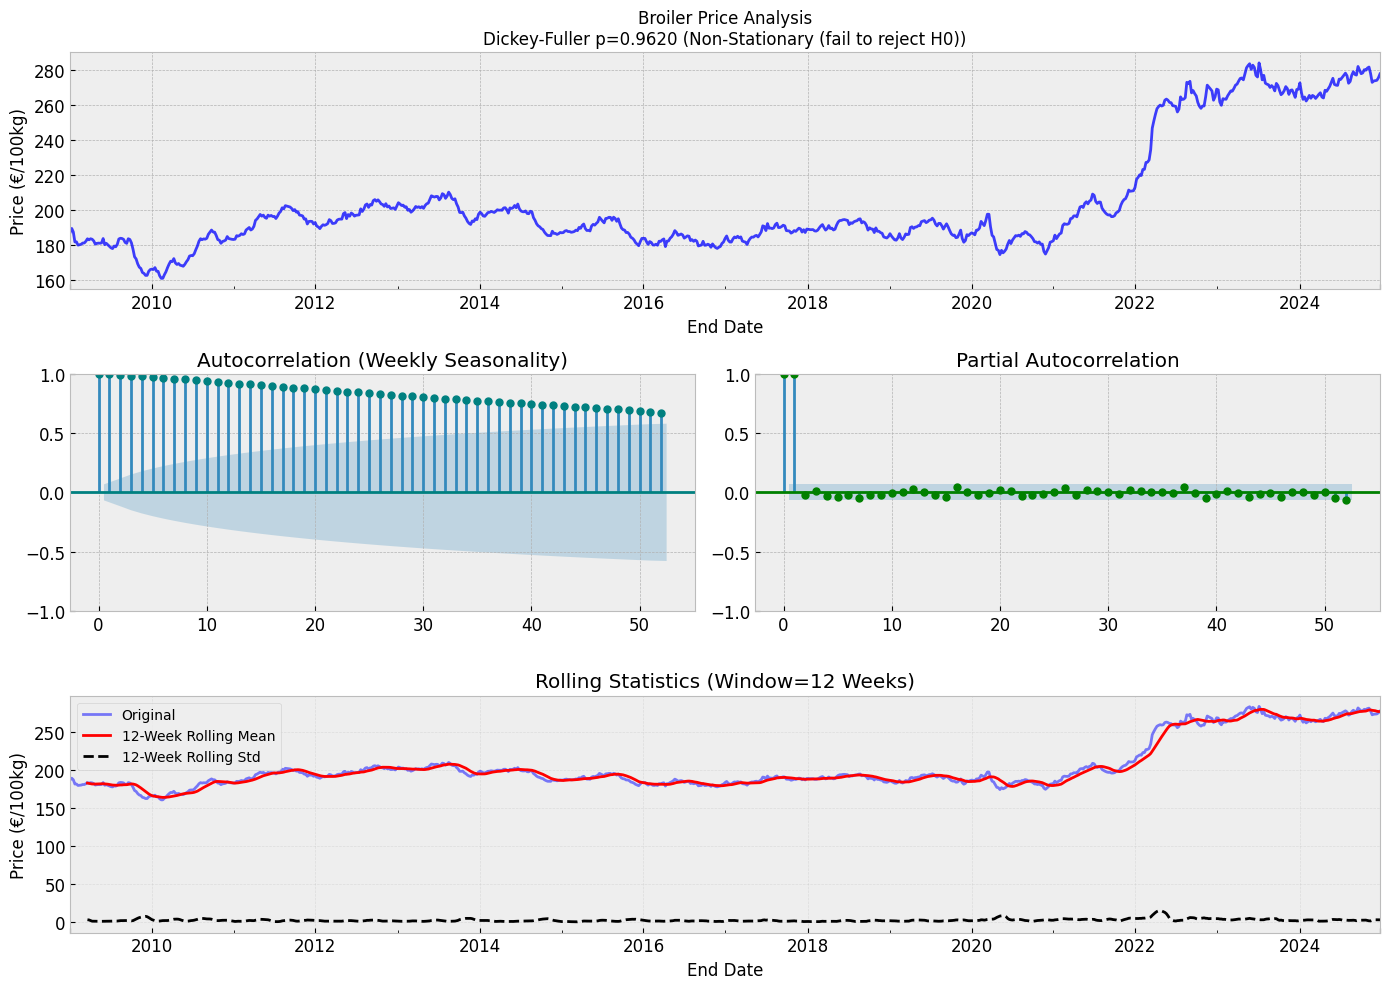

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(14, 10), style='bmh', window=12):
    """
    Custom time series analysis plot for agricultural prices.
    
    Args:
        y (pd.Series): Time series data (e.g., 'Price (€/100kg)')
        lags (int): Number of lags for ACF/PACF (default: 52 for yearly seasonality)
        window (int): Rolling window size (default: 12 weeks for quarterly analysis)
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    if lags is None:
        lags = min(52, len(y)//4)  # Default to 52 lags (1 year) if not specified

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        roll_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

        # 1. Original Time Series with Stationarity Test
        y.plot(ax=ts_ax, color='blue', alpha=0.75)
        adf_result = adfuller(y)
        p_value = adf_result[1]
        hypothesis = "Stationary (reject H0)" if p_value <= 0.05 else "Non-Stationary (fail to reject H0)"
        ts_ax.set_title(
            f'Broiler Price Analysis\nDickey-Fuller p={p_value:.4f} ({hypothesis})', 
            fontsize=12
        )
        ts_ax.set_ylabel('Price (€/100kg)')

        # 2. ACF and PACF
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color='teal')
        acf_ax.set_title('Autocorrelation (Weekly Seasonality)')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, color='green')
        pacf_ax.set_title('Partial Autocorrelation')

        # 3. Rolling Statistics
        rolmean = y.rolling(window=window).mean()
        rolstd = y.rolling(window=window).std()
        
        y.plot(ax=roll_ax, color='blue', alpha=0.5, label='Original')
        rolmean.plot(ax=roll_ax, color='red', label=f'{window}-Week Rolling Mean')
        rolstd.plot(ax=roll_ax, color='black', linestyle='--', label=f'{window}-Week Rolling Std')
        
        roll_ax.set_title(f'Rolling Statistics (Window={window} Weeks)')
        roll_ax.set_ylabel('Price (€/100kg)')
        roll_ax.legend(loc='upper left')
        roll_ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Usage on your dataset
tsplot(df['Price (€/100kg)'], lags=52, window=12)

## Making Time Series Stationary

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

In [6]:
# Differencing for stationarity
x_diff = X.diff().dropna()
check_stationarity(x_diff)

ADF Statistic: -12.075283631912312
p-value: 2.297773706808004e-22
The series is stationary.
Critical Values:
   1%: -3.4382531800005944
   5%: -2.8650285052126057
   10%: -2.5686275714907825


False

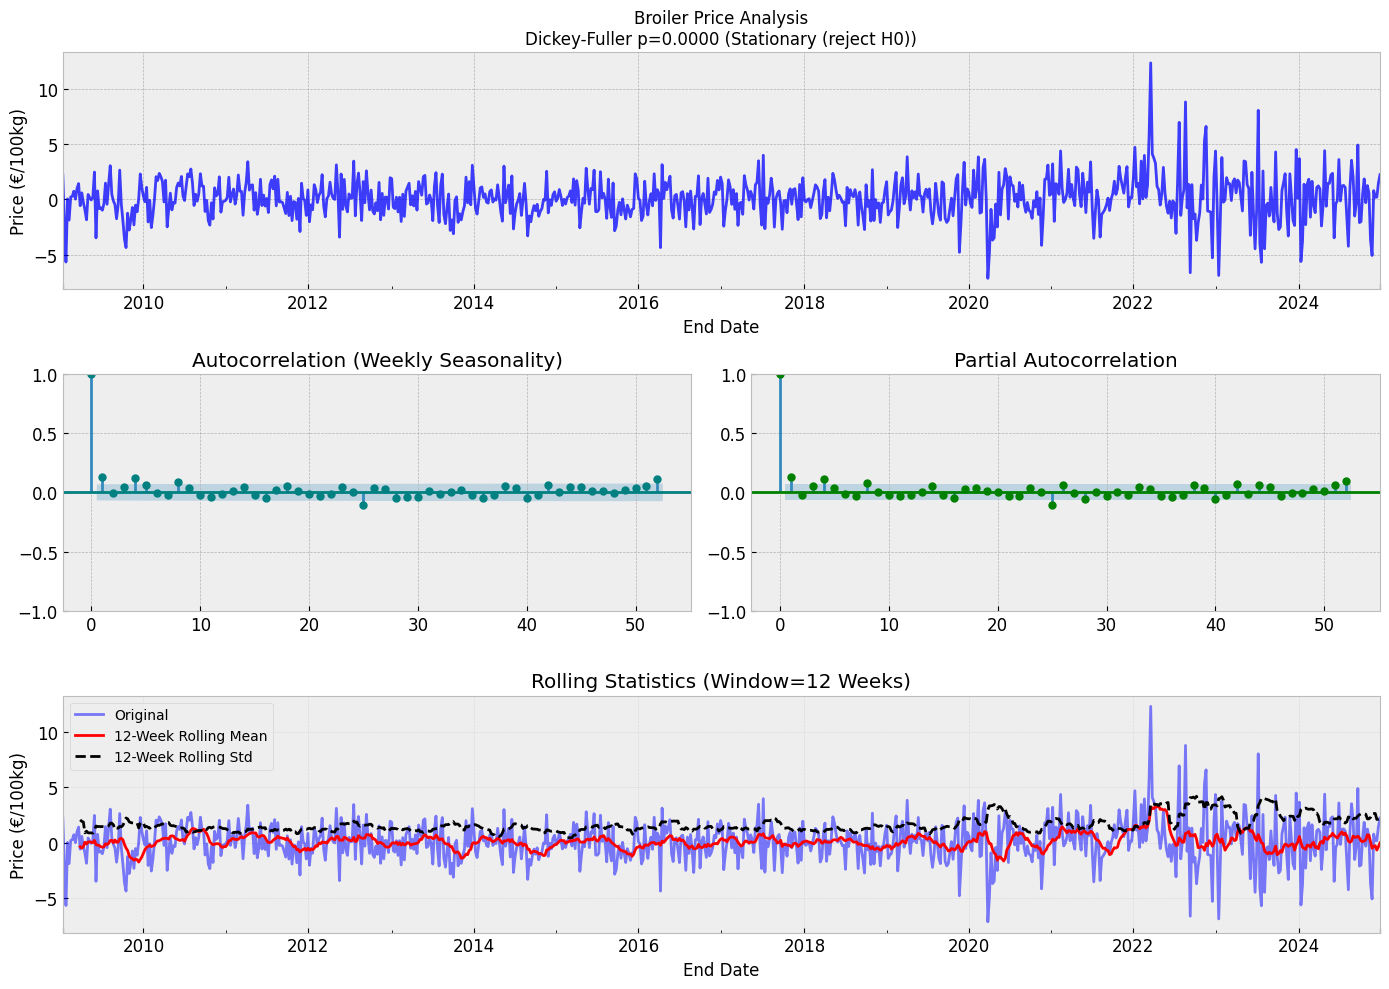

In [7]:
tsplot(x_diff, lags=52, window=12)

# Methods for time series forecasting

In [5]:
def plot_train_test(train, test, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, color='green', label='Test Data')
    plt.axvline(x=test.index[0], color='red', linestyle='--', 
                label=f'Test Start: {test.index[0].date()}')
    plt.title(f'{title}\n{target_col}')
    plt.ylabel('Price (€/100kg)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

### Data preperation

Training Period: 2009-01-04 to 2021-12-26
Testing Period: 2022-01-02 to 2024-12-29

Training Samples: 678 weeks
Testing Samples: 157 weeks
Stationarity Analysis:
ADF Statistic: -2.651971278066424
p-value: 0.08272439137720705
The series is not stationary.
Critical Values:
   1%: -3.440118534323335
   5%: -2.865850549495406
   10%: -2.569065506040958
ADF Statistic: -9.52020819760595
p-value: 3.079330915329593e-16
The series is stationary.
Critical Values:
   1%: -3.440118534323335
   5%: -2.865850549495406
   10%: -2.569065506040958


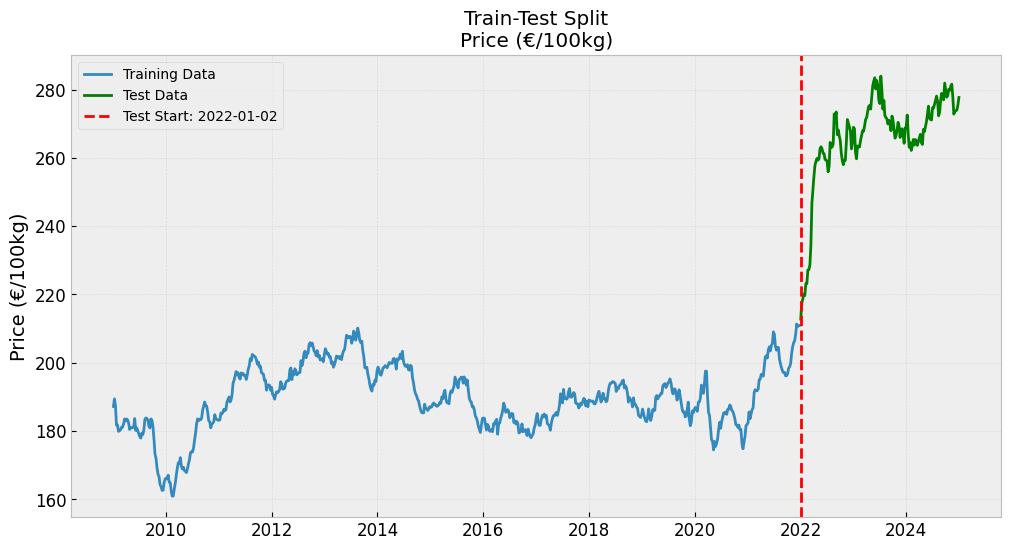

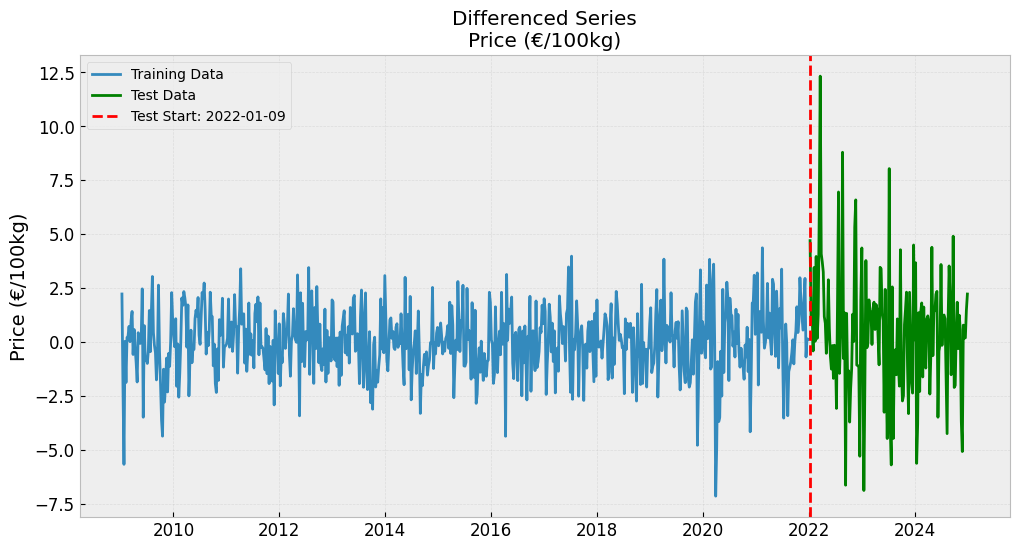

In [6]:
# Configuration
target_col = 'Price (€/100kg)'
split_date = df.index[-1] - pd.DateOffset(years=3)

# Split data
train = df.loc[df.index <= split_date]
test = df.loc[df.index > split_date]

print(f"Training Period: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Testing Period: {test.index[0].date()} to {test.index[-1].date()}")
print(f"\nTraining Samples: {len(train)} weeks")
print(f"Testing Samples: {len(test)} weeks")

# Stationarity check
print("Stationarity Analysis:")
is_nonstationary = check_stationarity(train[target_col])

# Create differenced versions if needed
train_diff, test_diff = None, None
if is_nonstationary:
    train_diff = train[target_col].diff().dropna()
    test_diff = test[target_col].diff().dropna()
    check_stationarity(train_diff)  # Verify differencing worked

# Initialize tracking
results_dict = {}
predictions_dict = {}

# Visualize
plot_train_test(train[target_col], test[target_col], 'Train-Test Split')
if train_diff is not None:
    plot_train_test(train_diff, test_diff, 'Differenced Series')

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_true, y_pred):
    """Calculate common time series metrics including R-squared."""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,  # Mean Absolute Percentage Error
        'R2': r2_score(y_true, y_pred)  # R-squared metric
    }

# Univariate-time-series-forecasting

## 1. Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

Regularized SES: 100%|██████████| 157/157 [00:25<00:00,  6.13it/s]



Simple Exponential Smoothing Performance:
MAE: 2.15 €/100kg
RMSE: 2.89 €/100kg
MAPE: 0.81%
R2: 0.96%


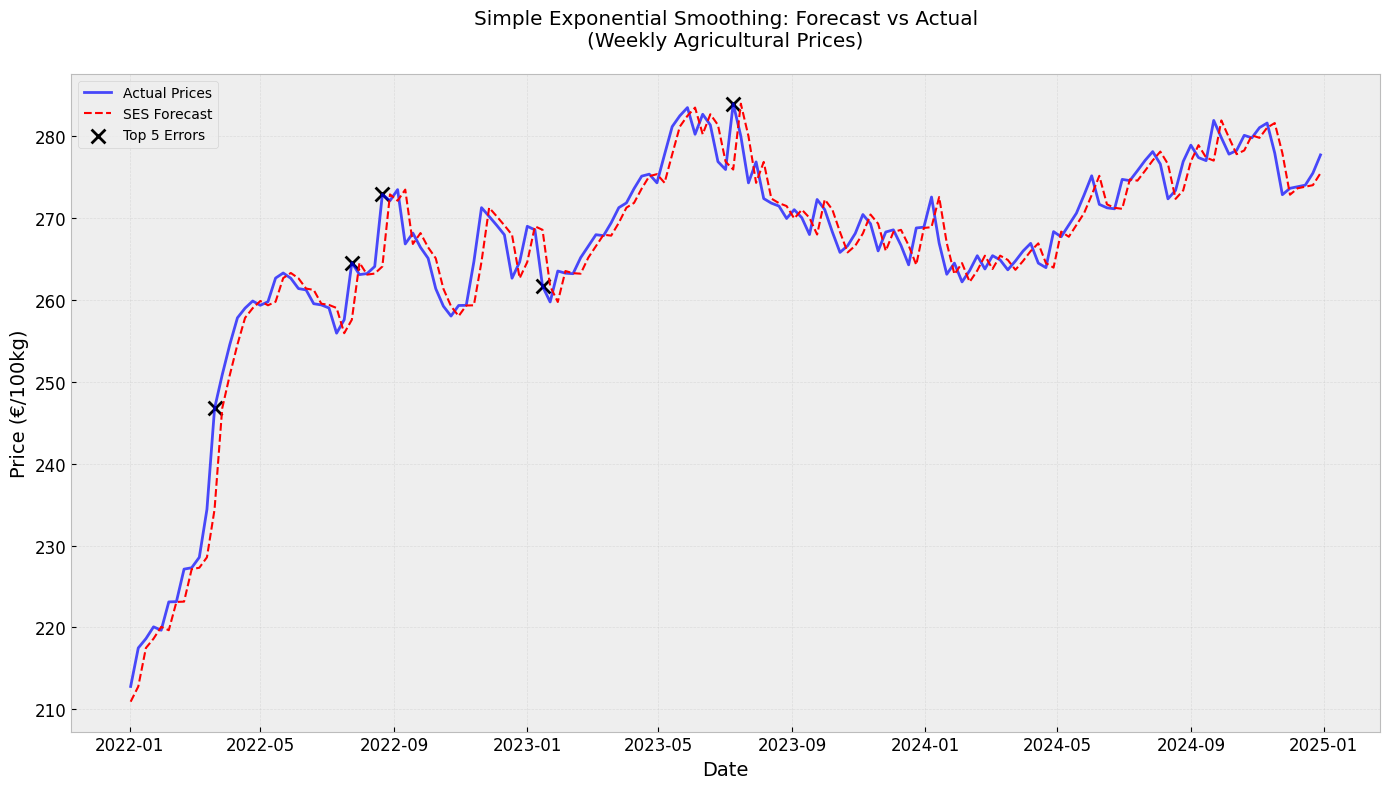

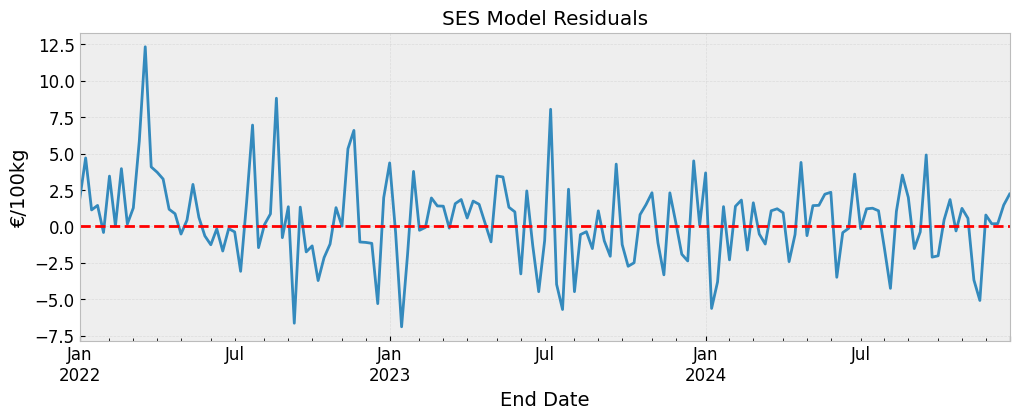

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
target_col = 'Price (€/100kg)'

# def run_ses_model(train_series, test_series, model_name='SES'):
#     """Complete SES workflow with walk-forward validation"""
#     yhat_ses = []
#     test_dates = test_series.index
    
#     # Walk-forward validation
#     for t in tqdm(range(len(test_series)), desc=f"{model_name} Forecasting"):
#         try:
#             # Expand training window incrementally
#             history = pd.concat([train_series, test_series.iloc[:t]])
            
#             # Fit SES model (with optimized alpha)
#             model = SimpleExpSmoothing(history, initialization_method="estimated")
#             model_fit = model.fit(optimized=True)
#             print(model_fit.params['smoothing_level'])
            
#             # Forecast and store
#             yhat_ses.append(model_fit.forecast(1).iloc[0])
#         except Exception as e:
#             print(f"Error at t={t}: {str(e)}")
#             yhat_ses.append(history.iloc[-1])  # Fallback to last observation
    
#     # Convert to Series
#     return pd.Series(yhat_ses, index=test_dates)


def run_regularized_ses(train_series, test_series, max_alpha=0.3):
    yhat_ses = []
    test_dates = test_series.index
    
    for t in tqdm(range(len(test_series)), desc="Regularized SES"):
        history = pd.concat([train_series, test_series.iloc[:t]])
        
        # Manually find best alpha <= max_alpha
        best_alpha = 0
        best_aic = np.inf
        for alpha in np.linspace(0.01, max_alpha, 10):
            model = SimpleExpSmoothing(history, initialization_method="estimated")
            try:
                model_fit = model.fit(smoothing_level=alpha)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_alpha = alpha
            except:
                continue
        
        # Fit with best found alpha
        model = SimpleExpSmoothing(history, initialization_method="estimated")
        model_fit = model.fit(smoothing_level=best_alpha)
        yhat_ses.append(model_fit.forecast(1).iloc[0])
    
    return pd.Series(yhat_ses, index=test_dates)

# Run with alpha constrained to ≤ 0.3
yhat_reg = run_regularized_ses(train[target_col], test[target_col], max_alpha=0.3)

# Run SES on ORIGINAL data (SES handles non-stationarity internally)
# yhat_ses = run_ses_model(train[target_col], test[target_col])

# Store results
predictions_dict['SimpleExpSmoothing'] = yhat_ses
results_dict['SimpleExpSmoothing'] = evaluate(test[target_col], yhat_ses)

# Performance Report
print("\nSimple Exponential Smoothing Performance:")
print(f"MAE: {results_dict['SimpleExpSmoothing']['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict['SimpleExpSmoothing']['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict['SimpleExpSmoothing']['MAPE']:.2f}%")
print(f"R2: {results_dict['SimpleExpSmoothing']['R2']:.2f}%")

# Enhanced visualization
plt.figure(figsize=(14, 8))
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(yhat_ses, label='SES Forecast', color='red', linewidth=1.5, linestyle='--')

# Highlight largest errors
top_errors = (test[target_col] - yhat_ses).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
            color='black', marker='x', s=100, label='Top 5 Errors')

plt.title('Simple Exponential Smoothing: Forecast vs Actual\n(Weekly Agricultural Prices)', pad=20)
plt.ylabel('Price (€/100kg)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual analysis
residuals = test[target_col] - yhat_ses
plt.figure(figsize=(12,4))
residuals.plot(title='SES Model Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('€/100kg')
plt.grid(alpha=0.3)
plt.show()

Regularized SES: 100%|██████████| 157/157 [00:25<00:00,  6.12it/s]



Simple Exponential Smoothing Performance:
MAE: 2.15 €/100kg
RMSE: 2.89 €/100kg
MAPE: 0.81%
R2: 0.96


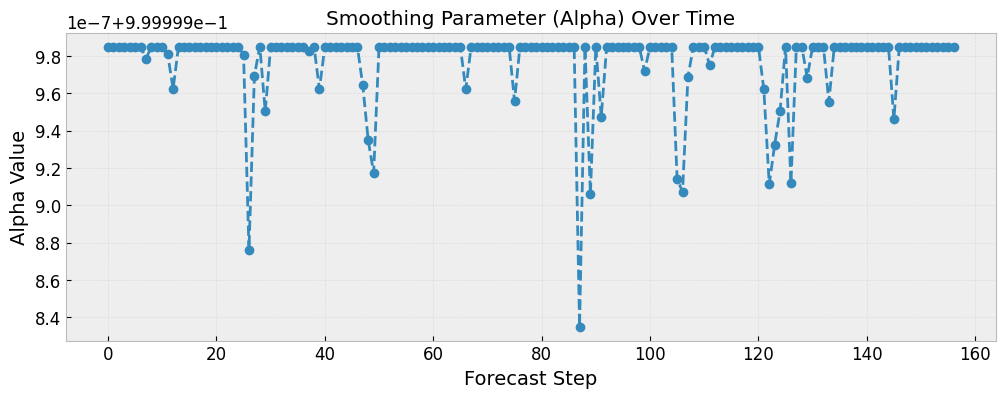


Early Test Period Performance:
MAE: 2.27 €/100kg
MAPE: 0.88%

Late Test Period Performance:
MAE: 2.02 €/100kg
MAPE: 0.74%


TypeError: run_ses_model() got an unexpected keyword argument 'forecast_horizon'

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

# Configuration
target_col = 'Price (€/100kg)'
FORECAST_HORIZON = 52  # 52 weeks = 1 year

def run_ses_model(train_series, test_series, model_name='SES', forecast_horizon=1):
    """Complete SES workflow with walk-forward validation"""
    yhat_ses = []
    alpha_values = []
    test_dates = test_series.index
    
    # Walk-forward validation
    for t in tqdm(range(len(test_series)), desc=f"{model_name} Forecasting"):
        try:
            # Expand training window incrementally
            history = pd.concat([train_series, test_series.iloc[:t]])
            
            # Fit SES model (with optimized alpha)
            model = SimpleExpSmoothing(history, initialization_method="estimated")
            model_fit = model.fit(optimized=True)
            alpha = model_fit.params['smoothing_level']
            alpha_values.append(alpha)
            
            # Forecast and store (1-step ahead for validation, n-step for analysis)
            forecast = model_fit.forecast(forecast_horizon)
            yhat_ses.append(forecast.iloc[0])  # Store 1-step forecast for validation
        except Exception as e:
            print(f"Error at t={t}: {str(e)}")
            yhat_ses.append(history.iloc[-1])  # Fallback to last observation
            alpha_values.append(np.nan)
    
    # Convert to Series
    forecast_series = pd.Series(yhat_ses, index=test_dates)
    return forecast_series, alpha_values

# Run SES with 1-step ahead forecasting for validation
yhat_ses, alphas = run_ses_model(train[target_col], test[target_col], forecast_horizon=1)

# Store results
predictions_dict['SimpleExpSmoothing'] = yhat_ses
results_dict['SimpleExpSmoothing'] = evaluate(test[target_col], yhat_ses)

# Performance Report
print("\nSimple Exponential Smoothing Performance:")
print(f"MAE: {results_dict['SimpleExpSmoothing']['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict['SimpleExpSmoothing']['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict['SimpleExpSmoothing']['MAPE']:.2f}%")
print(f"R2: {results_dict['SimpleExpSmoothing']['R2']:.2f}")

# ===== Walk-Forward Validation Stability Checks =====
# 1. Check alpha parameter stability
plt.figure(figsize=(12, 4))
plt.plot(alphas, marker='o', linestyle='--')
plt.title('Smoothing Parameter (Alpha) Over Time')
plt.xlabel('Forecast Step')
plt.ylabel('Alpha Value')
plt.grid(alpha=0.3)
plt.show()

# 2. Split test set into early/late phases
test_split = len(test[target_col]) // 2
early_test = test[target_col].iloc[:test_split]
late_test = test[target_col].iloc[test_split:]

early_pred = yhat_ses.iloc[:test_split]
late_pred = yhat_ses.iloc[test_split:]

early_metrics = evaluate(early_test, early_pred)
late_metrics = evaluate(late_test, late_pred)

print("\nEarly Test Period Performance:")
print(f"MAE: {early_metrics['MAE']:.2f} €/100kg")
print(f"MAPE: {early_metrics['MAPE']:.2f}%")

print("\nLate Test Period Performance:")
print(f"MAE: {late_metrics['MAE']:.2f} €/100kg")
print(f"MAPE: {late_metrics['MAPE']:.2f}%")

# ===== 52-Week Forecasting Simulation =====
# Run SES with 52-week forecasting horizon
_, full_alphas = run_ses_model(train[target_col], test[target_col], forecast_horizon=FORECAST_HORIZON)

# Get final model with all data
final_model = SimpleExpSmoothing(pd.concat([train[target_col], test[target_col]]), 
                               initialization_method="estimated").fit(optimized=True)
final_alpha = final_model.params['smoothing_level']
print(f"\nFinal optimized alpha: {final_alpha:.4f}")

# Generate 52-week forecast
final_forecast = final_model.forecast(FORECAST_HORIZON)

# Plot long-term forecast
plt.figure(figsize=(14, 7))
plt.plot(pd.concat([train[target_col], test[target_col]]), label='Historical Data', color='blue')
plt.plot(final_forecast, label='52-Week SES Forecast', color='red', linestyle='--')
plt.title(f'52-Week Price Forecast (Alpha={final_alpha:.2f})')
plt.ylabel('Price (€/100kg)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ===== Original Visualizations =====
# Enhanced visualization
plt.figure(figsize=(14, 8))
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(yhat_ses, label='SES Forecast', color='red', linewidth=1.5, linestyle='--')

# Highlight largest errors
top_errors = (test[target_col] - yhat_ses).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
            color='black', marker='x', s=100, label='Top 5 Errors')

plt.title('Simple Exponential Smoothing: Forecast vs Actual\n(Weekly Agricultural Prices)', pad=20)
plt.ylabel('Price (€/100kg)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual analysis
residuals = test[target_col] - yhat_ses
plt.figure(figsize=(12,4))
residuals.plot(title='SES Model Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('€/100kg')
plt.grid(alpha=0.3)
plt.show()

### Residual plot

| Visual pattern | Info | Importance |
|----------------|-----------------|----------------|
| Blue residual curve wanders evenly above / below the red zero-line | Mean of the errors ≈ 0 → the SES model is **unbiased** overall. | A good forecast should not systematically over- or under-predict. |
| Most points stay within **± 4 €/100 kg** | Day-to-day noise is small; matches the MAE ≈ 2.15 you reported. | Confirms the low-error summary statistics. |
| One conspicuous spike (~ +12 €/100 kg) around mid-2023 | Model **missed a sudden upward jump** (likely a supply shock, policy change, or data glitch). | SES reacts slowly to step-changes because it carries “memory” (1 – α). |
| Variance looks fairly constant over the two-year span | No obvious heteroskedasticity → a plain ETS error model is adequate; GARCH-style variance modeling is likely over-kill. |
| No visible run of consecutive positive or negative errors | Eyeballing suggests little serial correlation; residuals are roughly white-noise. (A quick Ljung–Box test would confirm.) |

### Holt Winter’s Exponential Smoothing (HWES)

[HWES](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) or also known as triple exponential smoothing

HWES Forecasting: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s]



Holt-Winters (Additive Trend/Seasonality) Performance:
Training Period: 678 weeks | Test Period: 157 weeks
MAE: 6.19 €/100kg
RMSE: 7.82 €/100kg
MAPE: 2.30%


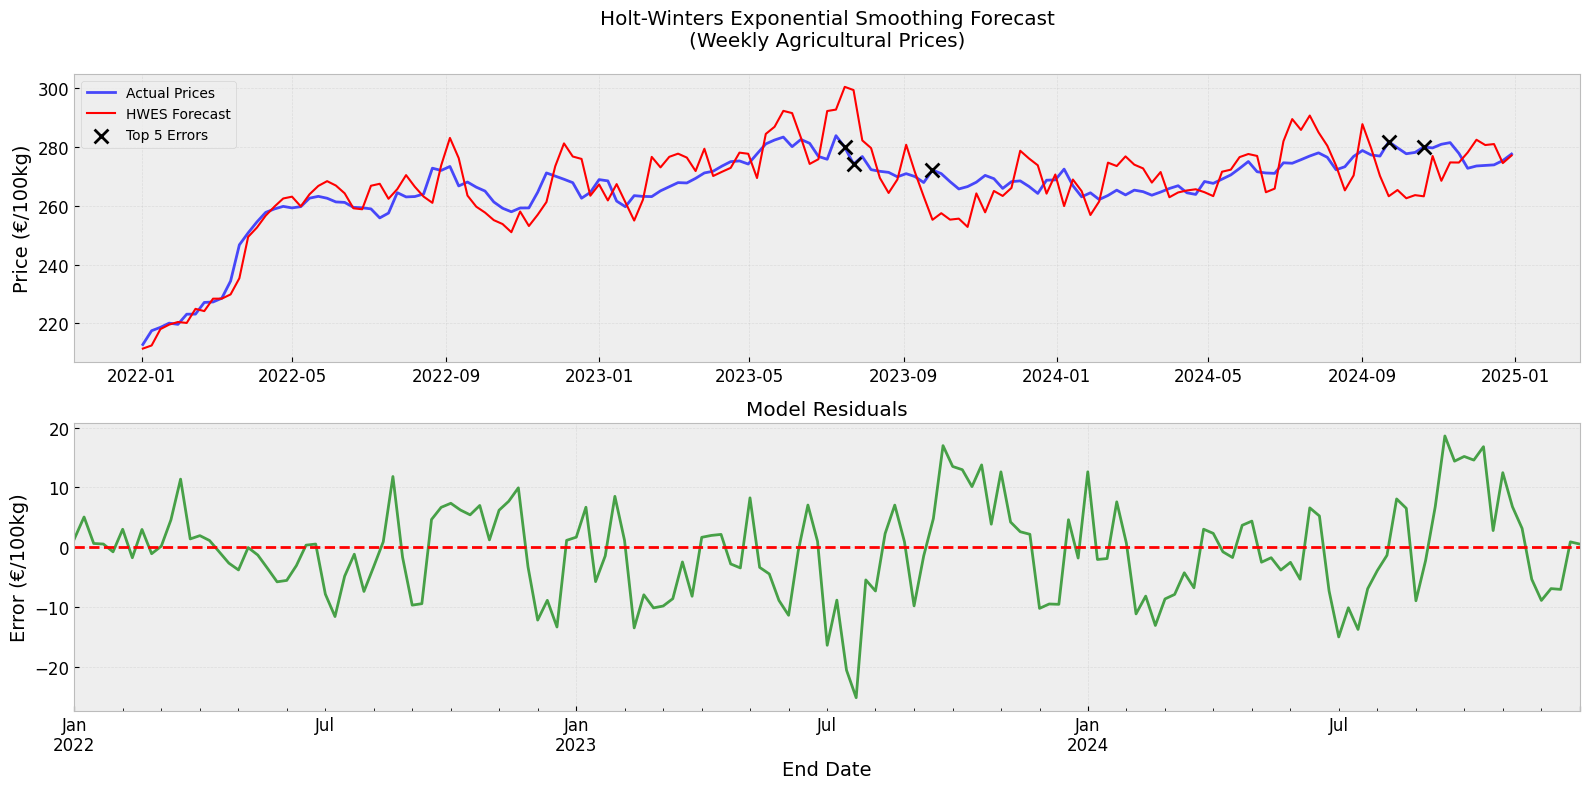

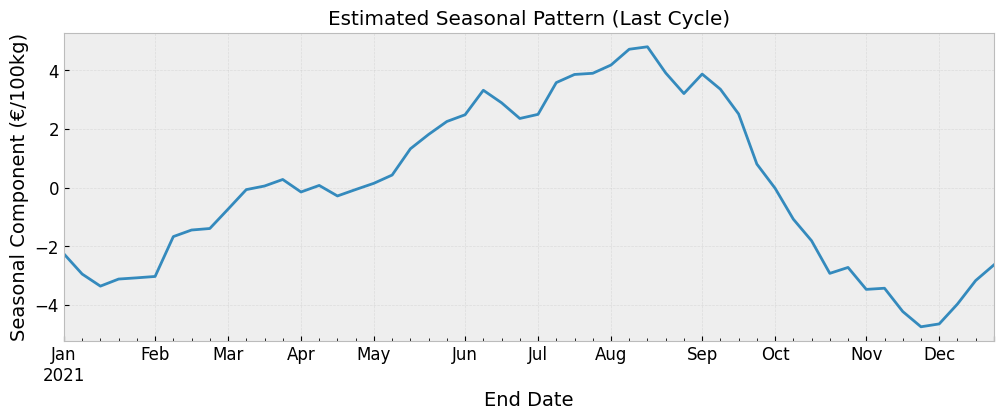

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

def run_hwes_model(train_series, test_series, seasonal_periods=52, model_name='HWES'):
    """Complete HWES workflow with walk-forward validation"""
    yhat_hwes = []
    test_dates = test_series.index
    
    # Walk-forward validation
    for t in tqdm(range(len(test_series)), desc=f"{model_name} Forecasting"):
        try:
            # Expand training window incrementally
            history = pd.concat([train_series, test_series.iloc[:t]])
            
            # Fit HWES model with robust configuration
            model = ExponentialSmoothing(
                history,
                trend='mul',
                seasonal='add',
                seasonal_periods=seasonal_periods,
                initialization_method='heuristic',  # More stable than 'estimated'
                use_boxcox=True  # Stabilize variance
            )
            model_fit = model.fit(
                optimized=True,
                remove_bias=True  # Reduce systematic forecast bias
            )
            
            # Get forecast with 95% confidence intervals
            yhat = model_fit.forecast(1)[0]
            yhat_hwes.append(yhat)
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_hwes.append(history.iloc[-1])  # Fallback to last observation
    
    return pd.Series(yhat_hwes, index=test_dates)

# Configuration
target_col = 'Price (€/100kg)'
seasonal_periods = 52  # Weekly data → yearly seasonality

# Run HWES on ORIGINAL data (model handles trend/seasonality internally)
yhat_hwes = run_hwes_model(train[target_col], test[target_col], seasonal_periods)

# Store results
predictions_dict['HWES'] = yhat_hwes
results_dict['HWES'] = evaluate(test[target_col], yhat_hwes)

# Performance Report
print("\nHolt-Winters (Additive Trend/Seasonality) Performance:")
print(f"Training Period: {len(train)} weeks | Test Period: {len(test)} weeks")
print(f"MAE: {results_dict['HWES']['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict['HWES']['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict['HWES']['MAPE']:.2f}%")

# Enhanced Visualization
plt.figure(figsize=(16, 8))
ax = plt.subplot(2,1,1)
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(yhat_hwes, label='HWES Forecast', color='red', linewidth=1.5)

# Highlight largest deviations
top_errors = (test[target_col] - yhat_hwes).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
            color='black', marker='x', s=100, zorder=10, label='Top 5 Errors')

plt.title('Holt-Winters Exponential Smoothing Forecast\n(Weekly Agricultural Prices)', pad=20)
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(alpha=0.3)

# Residual analysis
ax2 = plt.subplot(2,1,2)
residuals = test[target_col] - yhat_hwes
residuals.plot(color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Model Residuals')
plt.ylabel('Error (€/100kg)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Seasonal Component Analysis (if needed)
if seasonal_periods > 1:
    model = ExponentialSmoothing(train[target_col], seasonal='add', seasonal_periods=seasonal_periods).fit()
    plt.figure(figsize=(12,4))
    decomp = seasonal_decompose(train[target_col], model='additive', period=seasonal_periods)
    decomp.seasonal[-seasonal_periods:].plot(title='Estimated Seasonal Pattern (Last Cycle)')
    plt.ylabel('Seasonal Component (€/100kg)')
    plt.grid(alpha=0.3)
    plt.show()

### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm

# 1. Prepare both original and differenced series
original_series = df['Price (€/100kg)']
diff_series = original_series.diff().dropna()  # Stationary series

# 2. Split data (last 3 years for testing)
split_date = df.index[-1] - pd.DateOffset(years=3)
train_orig = original_series.loc[:split_date]
test_orig = original_series.loc[split_date:][1:]  # Align with differenced data

train_diff = diff_series.loc[:split_date]
test_diff = diff_series.loc[split_date:]

print(f"Training Samples: {len(train_diff)} weeks (differenced)")
print(f"Testing Samples: {len(test_diff)} weeks")

Training Samples: 677 weeks (differenced)
Testing Samples: 157 weeks


In [79]:
test_diff

End Date
2022-01-02    1.8571
2022-01-09    4.7000
2022-01-16    1.1342
2022-01-23    1.4440
2022-01-30   -0.4137
               ...  
2024-12-01    0.7848
2024-12-08    0.1838
2024-12-15    0.1952
2024-12-22    1.4683
2024-12-29    2.2255
Name: Price (€/100kg), Length: 157, dtype: float64

AR(2) Forecasting: 100%|██████████| 156/156 [00:06<00:00, 24.47it/s]



AR(2) Performance:
Training: 678 weeks | Test: 156 weeks
MAE: 2.14 €/100kg
RMSE: 2.87 €/100kg
MAPE: 0.81%


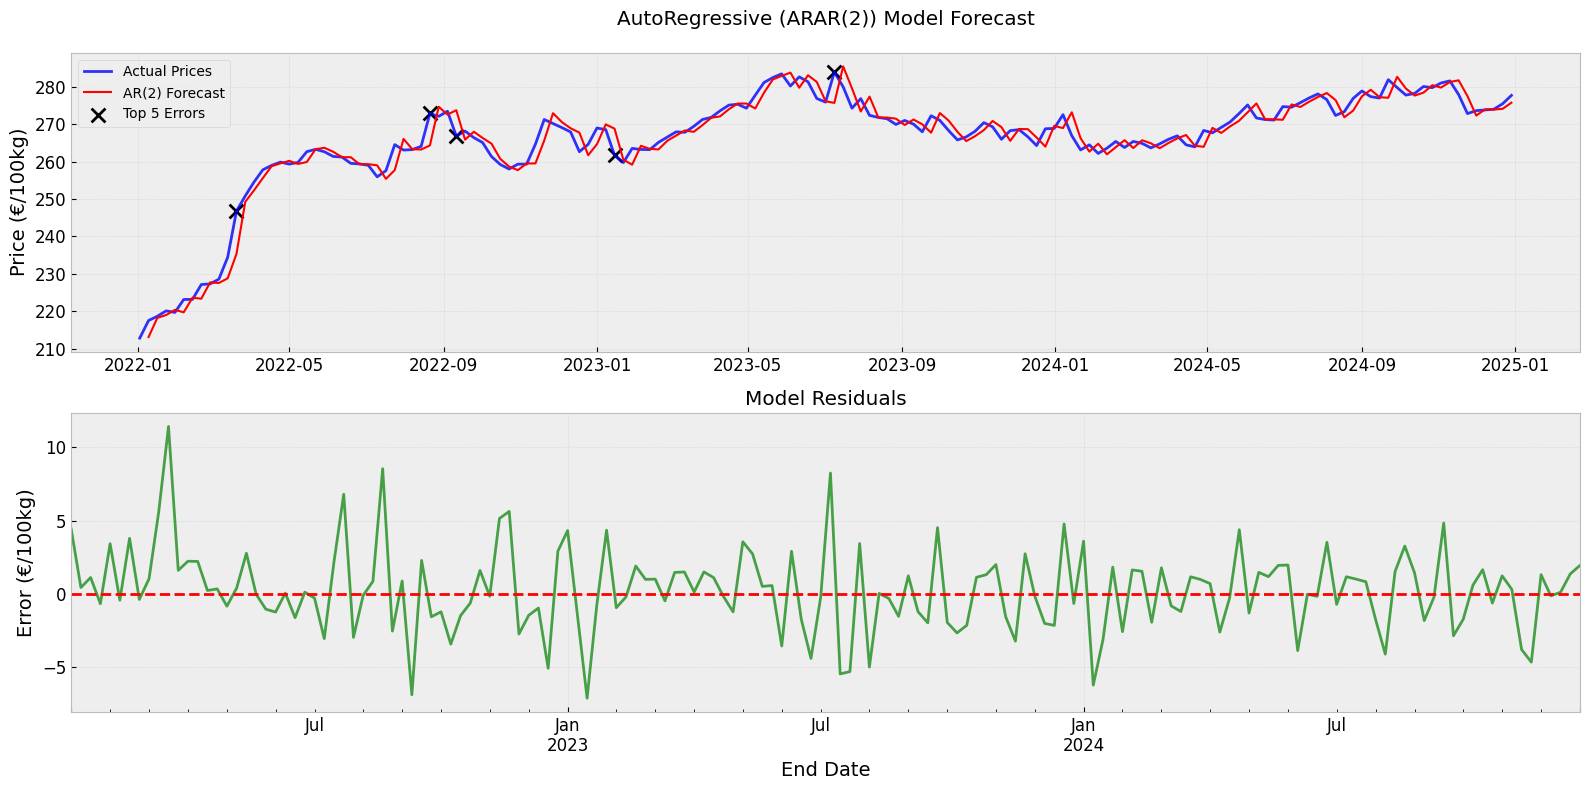

<Figure size 1200x400 with 0 Axes>

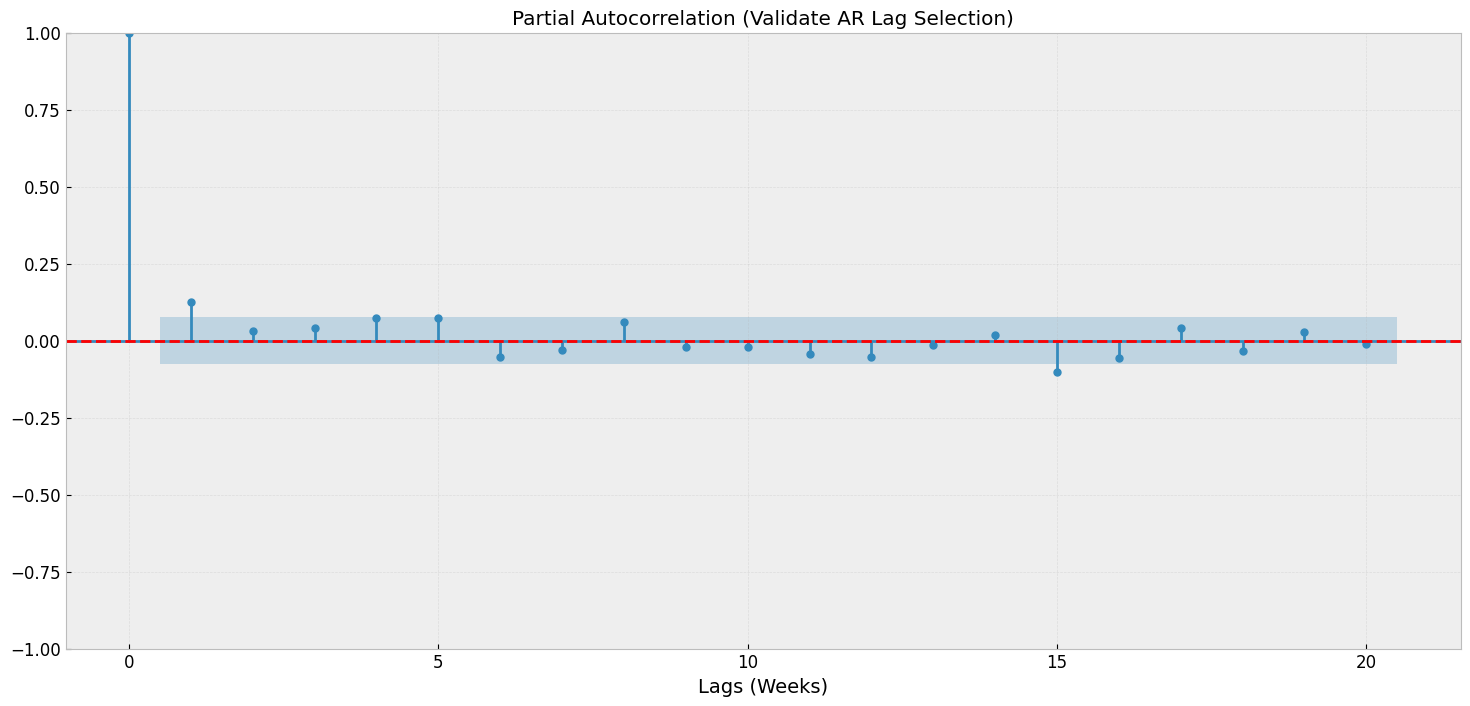

In [36]:
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def run_ar_model(train_series, test_series, lags=2, model_name='AR'):
    """Complete AR modeling workflow with walk-forward validation"""
    yhat_ar = []
    test_dates = test_series.index[1:]  # Skip first obs due to differencing
    
    for t in tqdm(range(len(test_series)-1), desc=f"{model_name}({lags}) Forecasting"):
        try:
            # 1. Create expanding window and difference
            history = pd.concat([train_series, test_series.iloc[:t+1]])
            history_diff = history.diff().dropna()
            
            # 2. Fit AR model with dynamic lag selection
            model = AutoReg(history_diff, 
                          lags=lags,
                          old_names=False,
                          trend='c')  # Include constant
            model_fit = model.fit()
            
            # 3. Forecast and convert to original scale
            pred_diff = model_fit.forecast(1)[0]
            pred_orig = history.iloc[-1] + pred_diff
            yhat_ar.append(pred_orig)
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_ar.append(history.iloc[-1])  # Fallback to last observation
    
    return pd.Series(yhat_ar, index=test_dates)

# Configuration
target_col = 'Price (€/100kg)'
lags = 2  # AR(2) model

# Run AR model (automatically handles differencing)
yhat_ar = run_ar_model(train[target_col], test[target_col], lags)

# Store results
model_name = f'AR({lags})'
predictions_dict[model_name] = yhat_ar
results_dict[model_name] = evaluate(test[target_col].iloc[1:len(yhat_ar)+1], yhat_ar)

# Performance Report
print(f"\n{model_name} Performance:")
print(f"Training: {len(train)} weeks | Test: {len(yhat_ar)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Enhanced Visualization
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(2,1,1)
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.8)
plt.plot(yhat_ar, label=f'{model_name} Forecast', color='red', linewidth=1.5)

# Highlight largest errors
top_errors = (test[target_col].iloc[1:len(yhat_ar)+1] - yhat_ar).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
           color='black', marker='x', s=100, label='Top 5 Errors')

plt.title(f'AutoRegressive (AR{model_name}) Model Forecast', pad=20)
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(alpha=0.3)

# Residual analysis
ax2 = plt.subplot(2,1,2)
residuals = test[target_col].iloc[1:len(yhat_ar)+1] - yhat_ar
residuals.plot(color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Model Residuals')
plt.ylabel('Error (€/100kg)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# PACF plot to validate lag choice
plt.figure(figsize=(12,4))
plot_pacf(train[target_col].diff().dropna(), lags=20, method='ywm')
plt.axhline(0, color='red', linestyle='--')
plt.title('Partial Autocorrelation (Validate AR Lag Selection)')
plt.xlabel('Lags (Weeks)')
plt.grid(alpha=0.3)
plt.show()

### Moving Average (MA)

The Moving Average (MA) method models the next step in the sequence as the average of a window of observations at prior time steps. Parameters of the model:


- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

MA(1) Forecasting: 100%|██████████| 156/156 [00:16<00:00,  9.34it/s]



MA(1) Performance:
Training: 677 weeks | Test: 156 weeks
MAE: 2.15 €/100kg
RMSE: 2.87 €/100kg
MAPE: 0.81%


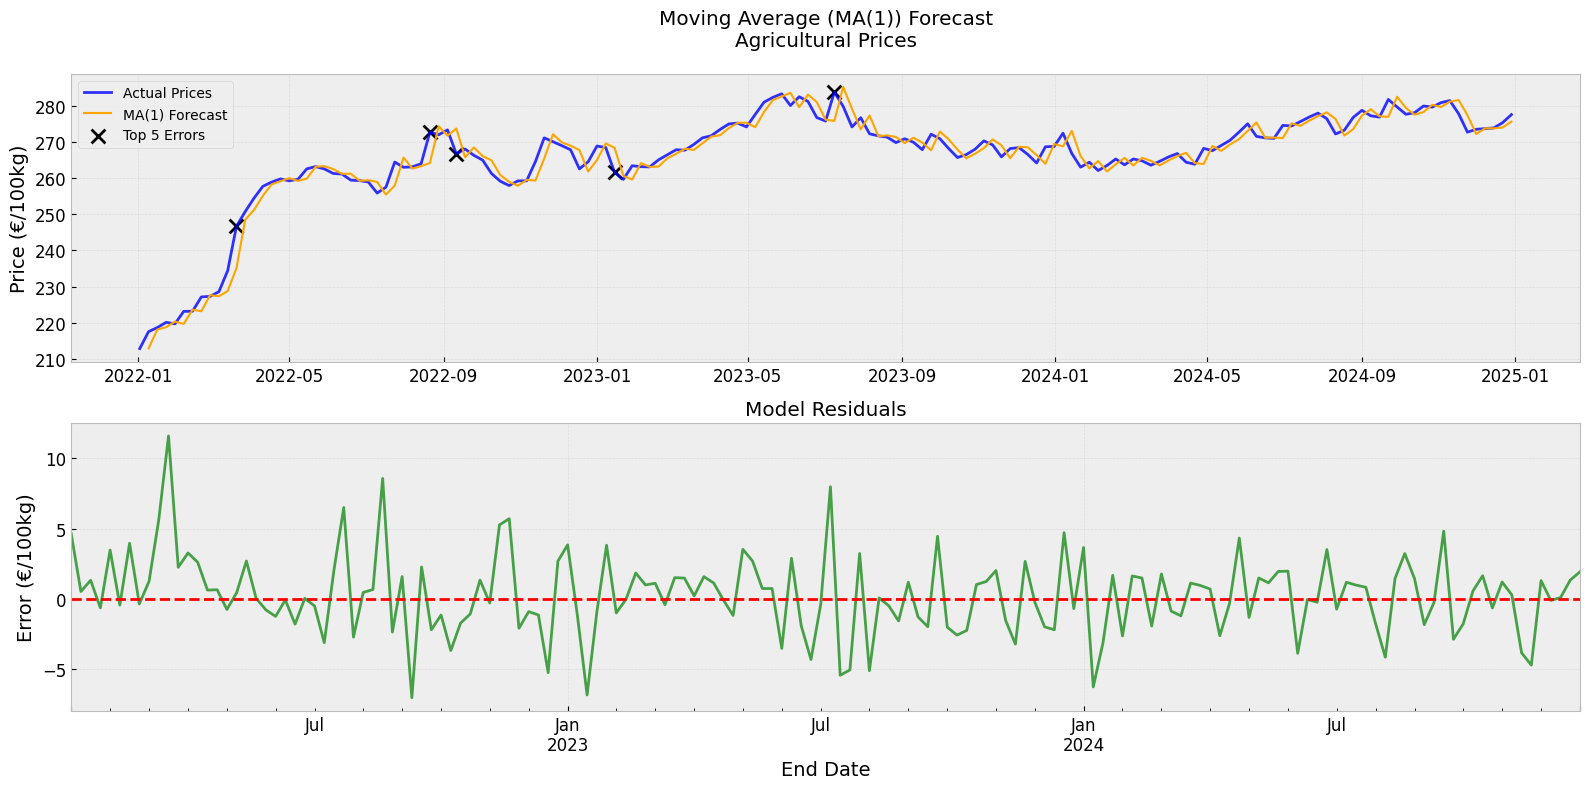

<Figure size 1200x400 with 0 Axes>

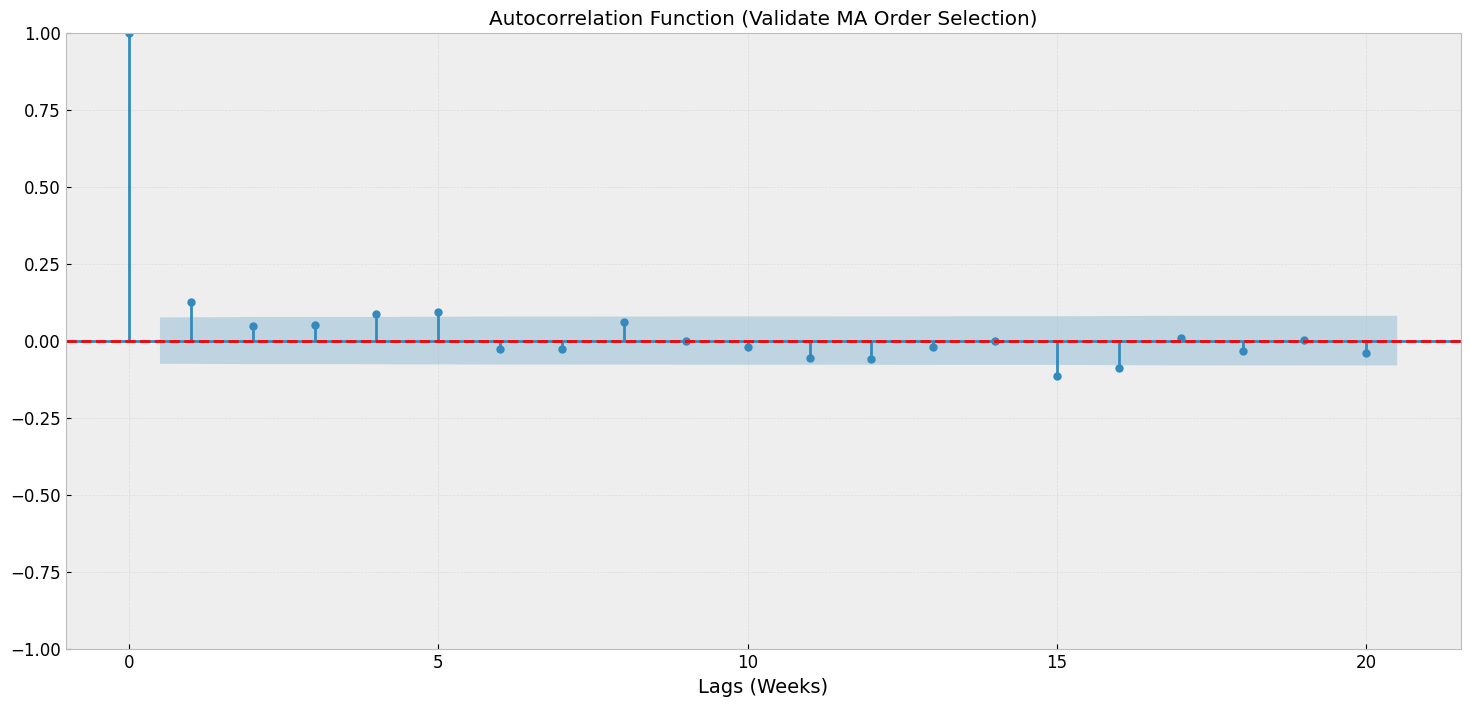

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def run_ma_model(train_series, test_series, train_diff, test_diff, ma_order=1, model_name='MA'):
    """Complete MA modeling workflow with walk-forward validation"""
    yhat_ma = []
    test_dates = test_series.index[1:]  # Skip first obs due to differencing
    
    for t in tqdm(range(len(test_diff)), desc=f"{model_name}({ma_order}) Forecasting"):
        try:
            # 1. Create expanding window of DIFFERENCED prices
            history_diff = pd.concat([train_diff, test_diff.iloc[:t]])
            
            # 2. Fit MA model (ARIMA(0,0,q))
            model = ARIMA(history_diff, 
                         order=(0,0,ma_order),
                         trend='c')  # Include constant term
            model_fit = model.fit()
            
            # 3. Forecast and convert to original scale
            forecast = model_fit.get_forecast(steps=1)
            pred_diff = forecast.predicted_mean.iloc[0]
            pred_orig = pd.concat([train_series, test_series.iloc[:t+1]]).iloc[-1] + pred_diff
            yhat_ma.append(pred_orig)
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_ma.append(test_series.iloc[t])  # Fallback to last observation
    
    return pd.Series(yhat_ma, index=test_dates[:len(yhat_ma)])

# Configuration
target_col = 'Price (€/100kg)'
ma_order = 1  # MA(1) model

# Prepare differenced data (if not already done)
train_diff = train[target_col].diff().dropna()
test_diff = test[target_col].diff().dropna()

# Run MA model
yhat_ma = run_ma_model(train[target_col], test[target_col], train_diff, test_diff, ma_order)

# Store results
model_name = f'MA({ma_order})'
predictions_dict[model_name] = yhat_ma
results_dict[model_name] = evaluate(test[target_col].iloc[1:len(yhat_ma)+1], yhat_ma)

# Performance Report
print(f"\n{model_name} Performance:")
print(f"Training: {len(train_diff)} weeks | Test: {len(yhat_ma)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Enhanced Visualization
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(2,1,1)
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.8)
plt.plot(yhat_ma, label=f'{model_name} Forecast', color='orange', linewidth=1.5)

# Highlight largest errors
top_errors = (test[target_col].iloc[1:len(yhat_ma)+1] - yhat_ma).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
           color='black', marker='x', s=100, label='Top 5 Errors')

plt.title(f'Moving Average ({model_name}) Forecast\nAgricultural Prices', pad=20)
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(alpha=0.3)

# Residual analysis
ax2 = plt.subplot(2,1,2)
residuals = test[target_col].iloc[1:len(yhat_ma)+1] - yhat_ma
residuals.plot(color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Model Residuals')
plt.ylabel('Error (€/100kg)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ACF plot to validate MA order
plt.figure(figsize=(12,4))
plot_acf(train_diff, lags=20, alpha=0.05)
plt.axhline(0, color='red', linestyle='--')
plt.title('Autocorrelation Function (Validate MA Order Selection)')
plt.xlabel('Lags (Weeks)')
plt.grid(alpha=0.3)
plt.show()

### Autoregressive Moving Average (ARMA)

This method will basically join the previous two `AR` and `MA`. Model parameters will be the sum of the two.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

ARMA(2,1) Forecasting: 100%|██████████| 156/156 [01:06<00:00,  2.35it/s]



ARMA(2,1) Performance:
Training: 677 weeks | Test: 156 weeks
MAE: 2.14 €/100kg
RMSE: 2.87 €/100kg
MAPE: 0.80%


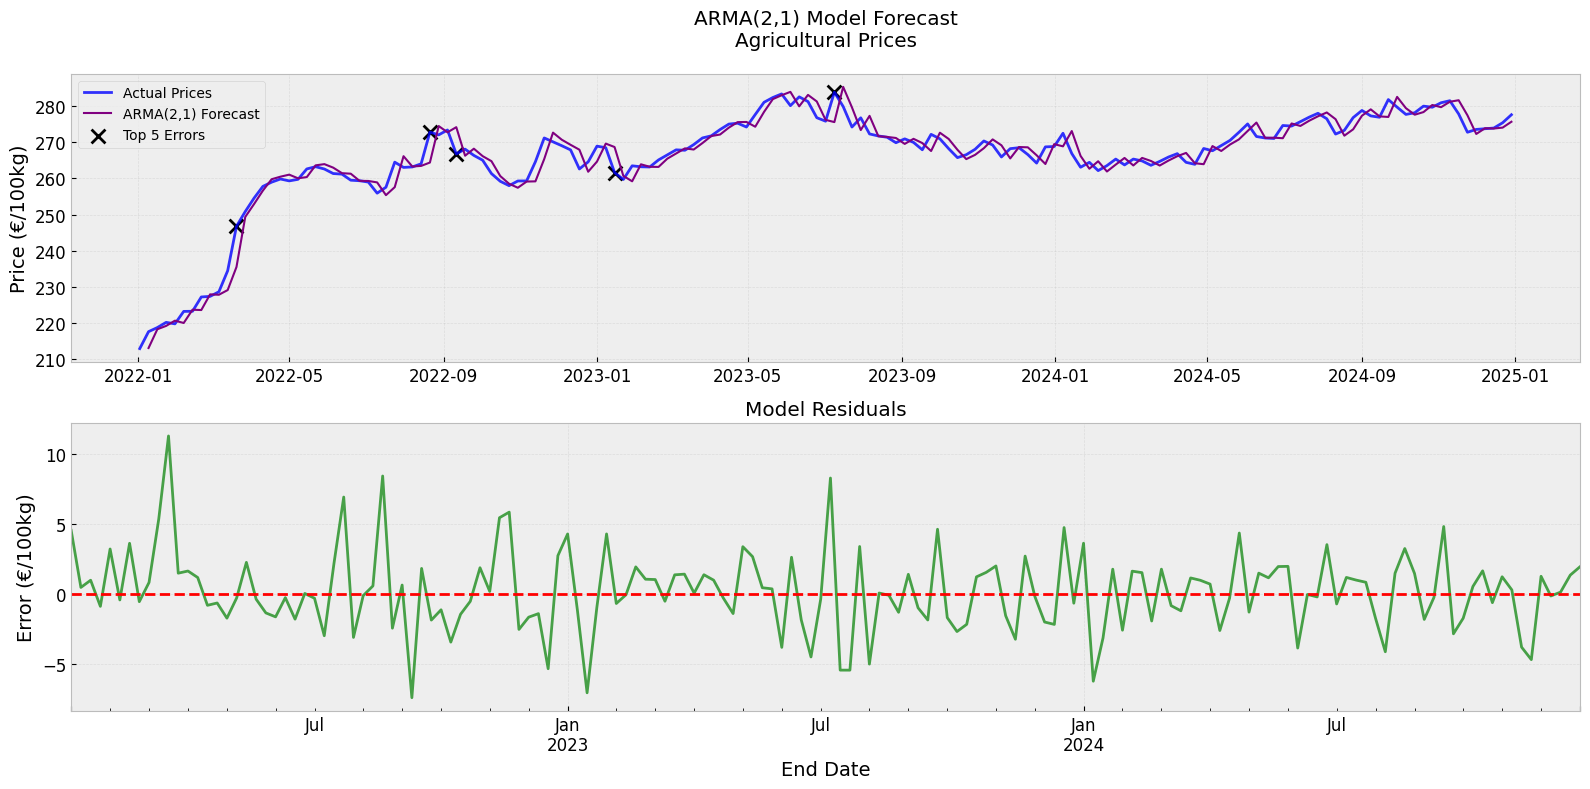

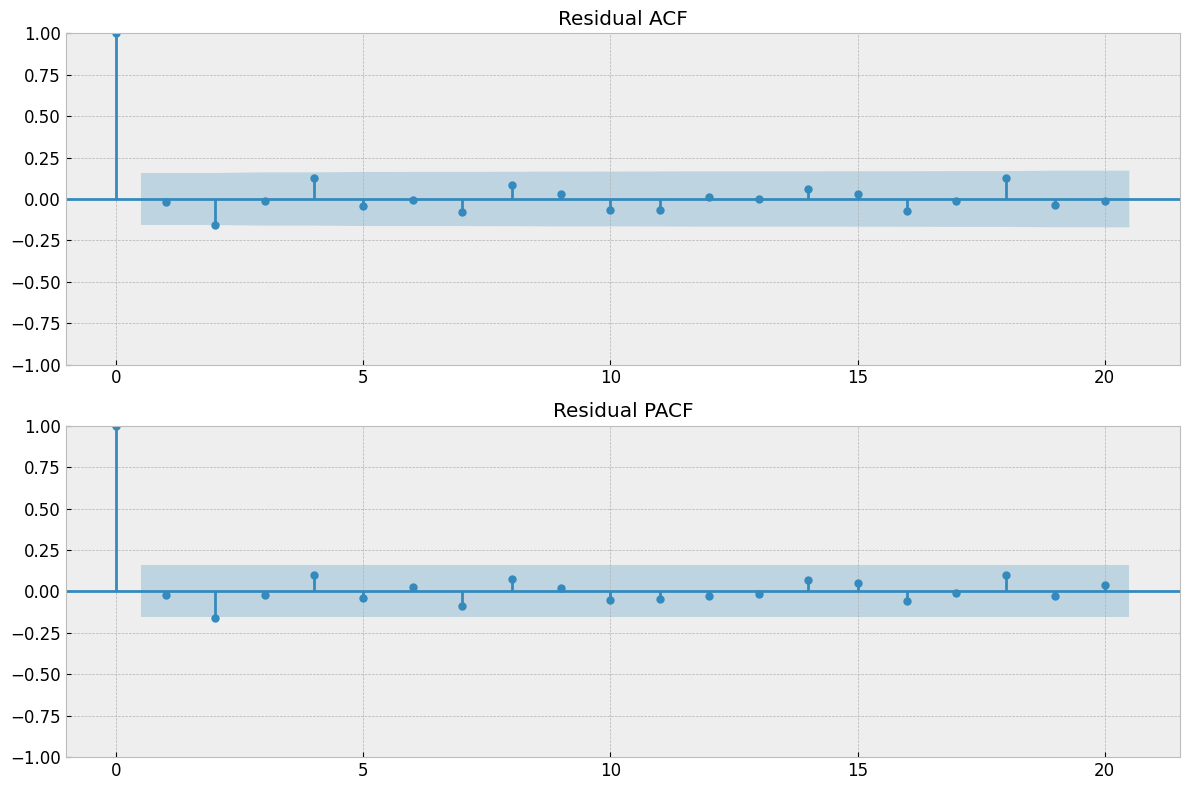

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def run_arma_model(train_series, test_series, train_diff, test_diff, p=2, q=1, model_name='ARMA'):
    """Complete ARMA modeling workflow with walk-forward validation"""
    yhat_arma = []
    test_dates = test_series.index[1:]  # Skip first obs due to differencing
    
    for t in tqdm(range(len(test_diff)), desc=f"{model_name}({p},{q}) Forecasting"):
        try:
            # 1. Create expanding window of DIFFERENCED prices
            history_diff = pd.concat([train_diff, test_diff.iloc[:t]])
            
            # 2. Fit ARMA model (ARIMA(p,0,q))
            model = ARIMA(history_diff,
                         order=(p,0,q),
                         trend='c')  # Include constant
            model_fit = model.fit()
            
            # 3. Forecast with confidence intervals
            forecast = model_fit.get_forecast(steps=1)
            pred_diff = forecast.predicted_mean.iloc[0]
            
            # 4. Convert to original scale
            last_orig = pd.concat([train_series, test_series.iloc[:t+1]]).iloc[-1]
            pred_orig = last_orig + pred_diff
            yhat_arma.append(pred_orig)
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_arma.append(test_series.iloc[t])  # Fallback to last observation
    
    return pd.Series(yhat_arma, index=test_dates[:len(yhat_arma)])

# Configuration
target_col = 'Price (€/100kg)'
p, q = 2, 1  # AR(2) and MA(1) components

# Prepare differenced data (if not already done)
train_diff = train[target_col].diff().dropna()
test_diff = test[target_col].diff().dropna()

# Run ARMA model
yhat_arma = run_arma_model(train[target_col], test[target_col], train_diff, test_diff, p, q)

# Store results
model_name = f'ARMA({p},{q})'
predictions_dict[model_name] = yhat_arma
results_dict[model_name] = evaluate(test[target_col].iloc[1:len(yhat_arma)+1], yhat_arma)

# Performance Report
print(f"\n{model_name} Performance:")
print(f"Training: {len(train_diff)} weeks | Test: {len(yhat_arma)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Enhanced Visualization
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(2,1,1)
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.8)
plt.plot(yhat_arma, label=f'{model_name} Forecast', color='purple', linewidth=1.5)

# Highlight largest errors
top_errors = (test[target_col].iloc[1:len(yhat_arma)+1] - yhat_arma).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
           color='black', marker='x', s=100, label='Top 5 Errors')

plt.title(f'ARMA({p},{q}) Model Forecast\nAgricultural Prices', pad=20)
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(alpha=0.3)

# Residual diagnostics
ax2 = plt.subplot(2,1,2)
residuals = test[target_col].iloc[1:len(yhat_arma)+1] - yhat_arma
residuals.plot(color='green', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Model Residuals')
plt.ylabel('Error (€/100kg)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Model diagnostics
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
plot_acf(residuals, lags=20, ax=ax1, title='Residual ACF')
ax2 = fig.add_subplot(2,1,2)
plot_pacf(residuals, lags=20, ax=ax2, title='Residual PACF', method='ywm')
plt.tight_layout()
plt.show()

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

ARIMA(2, 1, 1) Forecasting: 100%|██████████| 156/156 [00:48<00:00,  3.20it/s]



ARIMA(2, 1, 1) Performance:
Training: 678 weeks | Test: 156 weeks
MAE: 2.14 €/100kg
RMSE: 2.87 €/100kg
MAPE: 0.80%


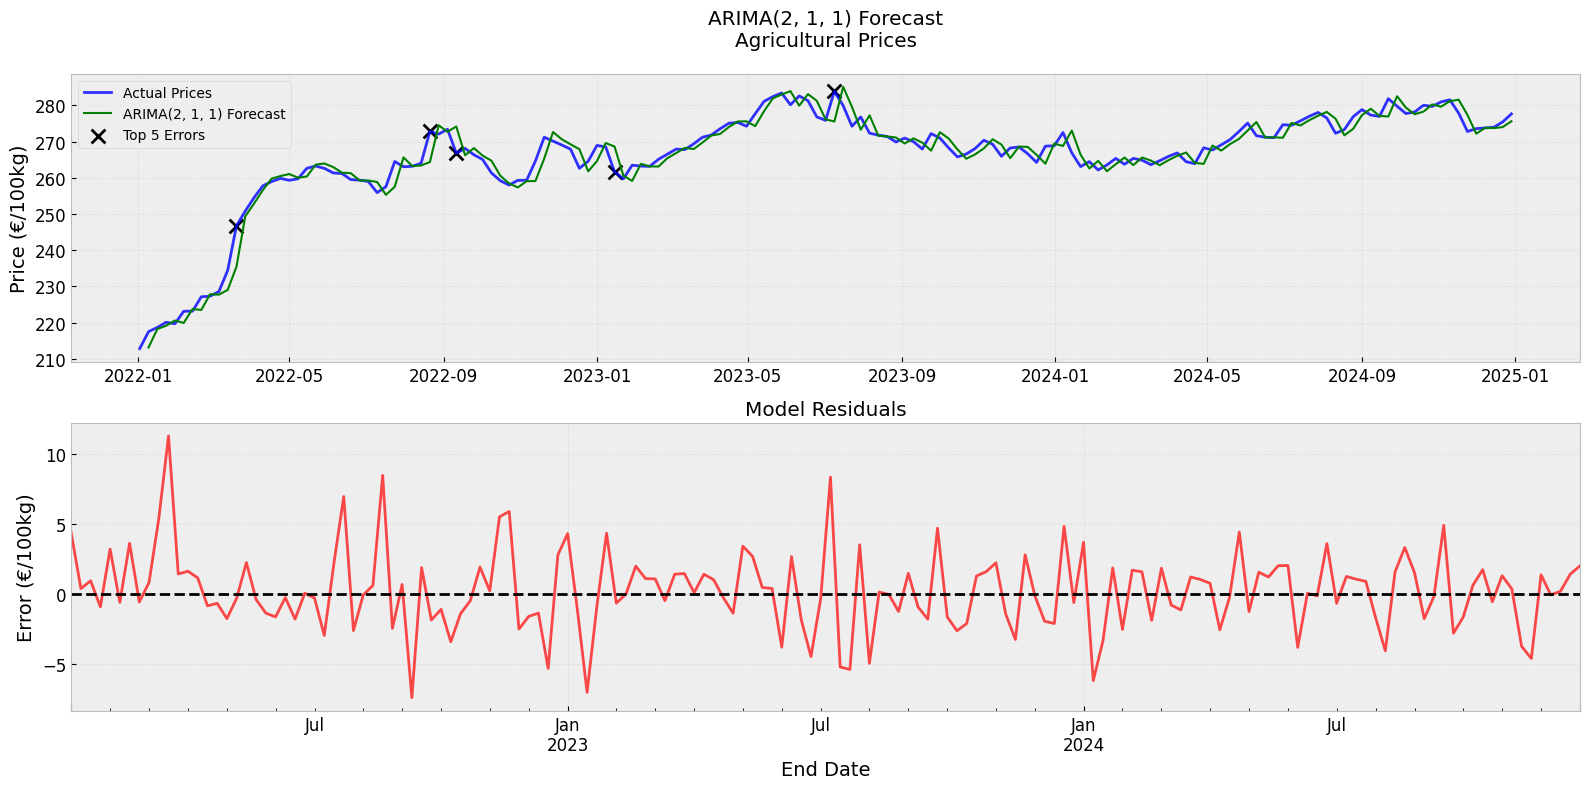


Model Summary:
                               SARIMAX Results                                
Dep. Variable:        Price (€/100kg)   No. Observations:                  678
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1233.415
Date:                Sun, 15 Jun 2025   AIC                           2474.829
Time:                        20:32:41   BIC                           2492.900
Sample:                    01-04-2009   HQIC                          2481.825
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7897      0.289      2.734      0.006       0.224       1.356
ar.L2         -0.0296      0.064     -0.461      0.644      -0.155       0.096
ma.L1         -0.6741      0.283    

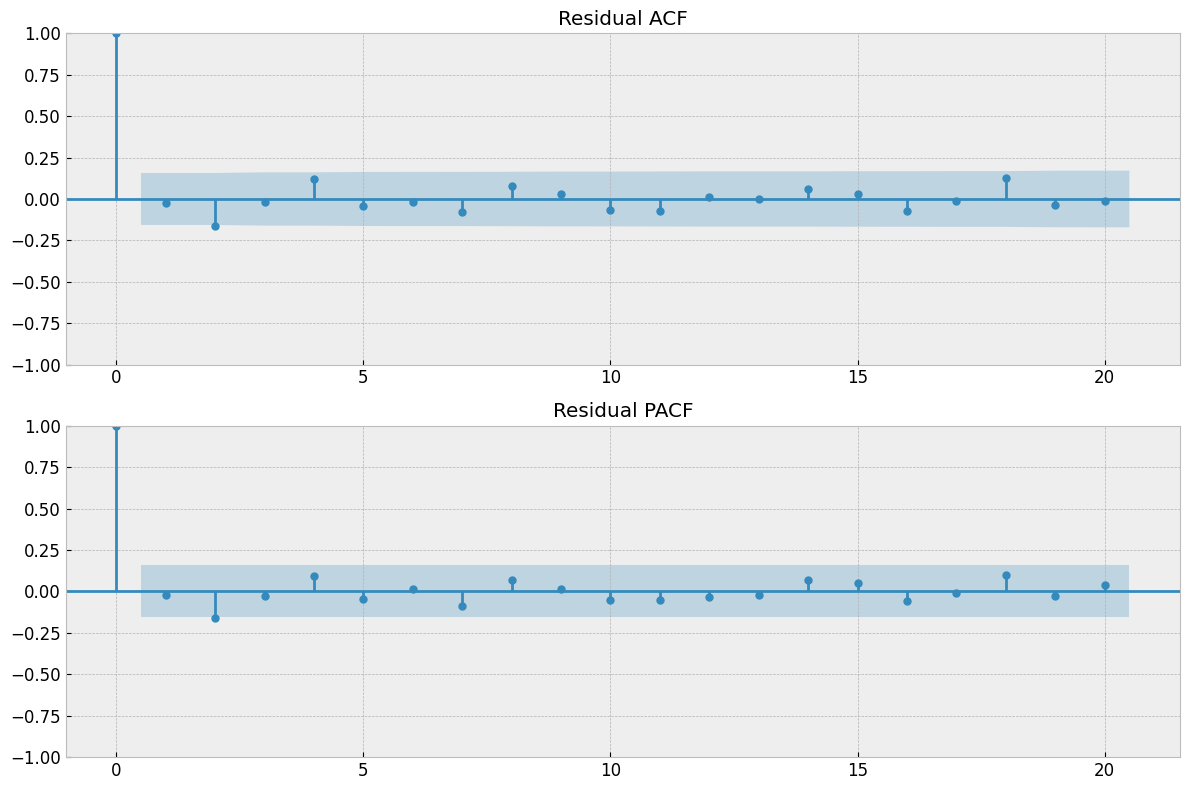

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def run_arima_model(train_series, test_series, order=(2,1,1), model_name='ARIMA'):
    """Complete ARIMA modeling workflow with walk-forward validation"""
    yhat_arima = []
    test_dates = test_series.index[1:]  # Account for differencing
    
    for t in tqdm(range(len(test_series)-1), desc=f"{model_name}{order} Forecasting"):
        try:
            # 1. Create expanding window
            history = pd.concat([train_series, test_series.iloc[:t+1]])
            
            # 2. Fit ARIMA model (handles differencing internally)
            model = ARIMA(history,
                         order=order,
                         trend='n')  # Include constant
            model_fit = model.fit()
            
            # 3. Forecast with confidence intervals
            forecast = model_fit.get_forecast(steps=1)
            yhat_arima.append(forecast.predicted_mean.iloc[0])
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_arima.append(history.iloc[-1])  # Fallback to last observation
    
    return pd.Series(yhat_arima, index=test_dates)

# Configuration
target_col = 'Price (€/100kg)'
order = (2, 1, 1)  # ARIMA(p,d,q)

# Run ARIMA model (uses original data - handles differencing internally)
yhat_arima = run_arima_model(train[target_col], test[target_col], order)

# Store results
model_name = f'ARIMA{order}'
predictions_dict[model_name] = yhat_arima
results_dict[model_name] = evaluate(test[target_col].iloc[1:len(yhat_arima)+1], yhat_arima)

# Performance Report
print(f"\n{model_name} Performance:")
print(f"Training: {len(train)} weeks | Test: {len(yhat_arima)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Enhanced Visualization
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(2,1,1)
plt.plot(test[target_col], label='Actual Prices', color='blue', alpha=0.8)
plt.plot(yhat_arima, label=f'{model_name} Forecast', color='green', linewidth=1.5)

# Highlight largest errors
top_errors = (test[target_col].iloc[1:len(yhat_arima)+1] - yhat_arima).abs().nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
           color='black', marker='x', s=100, label='Top 5 Errors')

plt.title(f'ARIMA{order} Forecast\nAgricultural Prices', pad=20)
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(alpha=0.3)

# Residual diagnostics
ax2 = plt.subplot(2,1,2)
residuals = test[target_col].iloc[1:len(yhat_arima)+1] - yhat_arima
residuals.plot(color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title('Model Residuals')
plt.ylabel('Error (€/100kg)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Model diagnostics
print("\nModel Summary:")
model = ARIMA(train[target_col], order=order).fit()
print(model.summary())

# Residual ACF/PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(residuals, lags=20, ax=ax1, title='Residual ACF')
plot_pacf(residuals, lags=20, ax=ax2, title='Residual PACF', method='ywm')
plt.tight_layout()
plt.show()

#### Auto ARIMA

In [12]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enhanced Auto-ARIMA Configuration
def run_auto_arima(train, test, target_col='Price (€/100kg)', exog_cols=None):
    """Comprehensive Auto-ARIMA workflow with walk-forward validation"""
    
    # 1. Model Selection with more thorough search
    print("\nRunning Auto-ARIMA model selection...")
    auto_model = pm.auto_arima(
        train[target_col],
        exogenous=train[exog_cols] if exog_cols else None,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        seasonal=True,  # Enable seasonal search
        m=52,  # Weekly data with yearly seasonality
        max_p=5,
        max_d=2,
        max_q=5,
        max_P=2,
        max_D=1,
        max_Q=2,
        stepwise=True,
        n_jobs=-1,  # Use all cores
        information_criterion='aic',
        n_fits=50  # Increase number of fits
    )
    
    print(f"\nBest Model: {auto_model}")
    print(f"Seasonal Order: {auto_model.seasonal_order}")
    
    # 2. Walk-forward validation with improved error handling
    yhat_auto = []
    test_dates = test.index
    
    for t in tqdm(range(len(test)), desc="Auto-ARIMA Walk-Forward Validation"):
        try:
            # Create expanding window
            history = pd.concat([train[target_col], test[target_col].iloc[:t]])
            exog_history = pd.concat([train[exog_cols], test[exog_cols].iloc[:t]]) if exog_cols else None
            
            # Fit model with selected order
            model = ARIMA(
                history,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                exog=exog_history
            )
            model_fit = model.fit()
            
            # Forecast with exogenous vars if needed
            forecast_exog = test[exog_cols].iloc[[t]] if exog_cols else None
            forecast = model_fit.get_forecast(steps=1, exog=forecast_exog)
            yhat_auto.append(forecast.predicted_mean.iloc[0])
            
        except Exception as e:
            print(f"\nWarning at t={t}: {str(e)}")
            # Fallback strategies
            if len(yhat_auto) > 0:
                # Use last successful forecast
                yhat_auto.append(yhat_auto[-1])
            else:
                # Use last training observation
                yhat_auto.append(train[target_col].iloc[-1])
    
    # Create results series
    yhat_series = pd.Series(yhat_auto, index=test_dates)
    
    return auto_model, yhat_series

# Select key exogenous variables (modify as needed)
exog_cols = ['Molasses', 'Maize Gluten Feed', 'Rape Seed Meal', 'Soya Beans', 'Food_Inflation_Rate']

# Run enhanced Auto-ARIMA
auto_model, yhat_series = run_auto_arima(
    train, 
    test, 
    target_col=target_col,
    exog_cols=exog_cols
)

# Store results
model_name = f'AutoARIMA{auto_model.order}x{auto_model.seasonal_order}'
predictions_dict[model_name] = yhat_series
results_dict[model_name] = evaluate(test[target_col], yhat_series)


Running Auto-ARIMA model selection...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=20.81 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2485.129, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2464.889, Time=3.11 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2465.939, Time=3.20 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2483.493, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2476.250, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=2466.741, Time=12.30 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.92 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2465.167, Time=3.32 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=52.14 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2472.486, Time=3.47 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=2466.001, Time=5.09 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2463.564, Time=6.33 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2475.014, Time=0

Auto-ARIMA Walk-Forward Validation: 100%|██████████| 157/157 [1:25:50<00:00, 32.81s/it]



AutoARIMA(1, 1, 1)x(1, 0, 0, 52) Performance:
Training Period: 678 weeks
Testing Period: 157 weeks
MAE: 2.16 €/100kg
RMSE: 2.90 €/100kg
MAPE: 0.81%


KeyError: 'R2'


AutoARIMA(1, 1, 1)x(1, 0, 0, 52) Performance:
Training Period: 678 weeks
Testing Period: 157 weeks
MAE: 2.16 €/100kg
RMSE: 2.90 €/100kg
MAPE: 0.81%


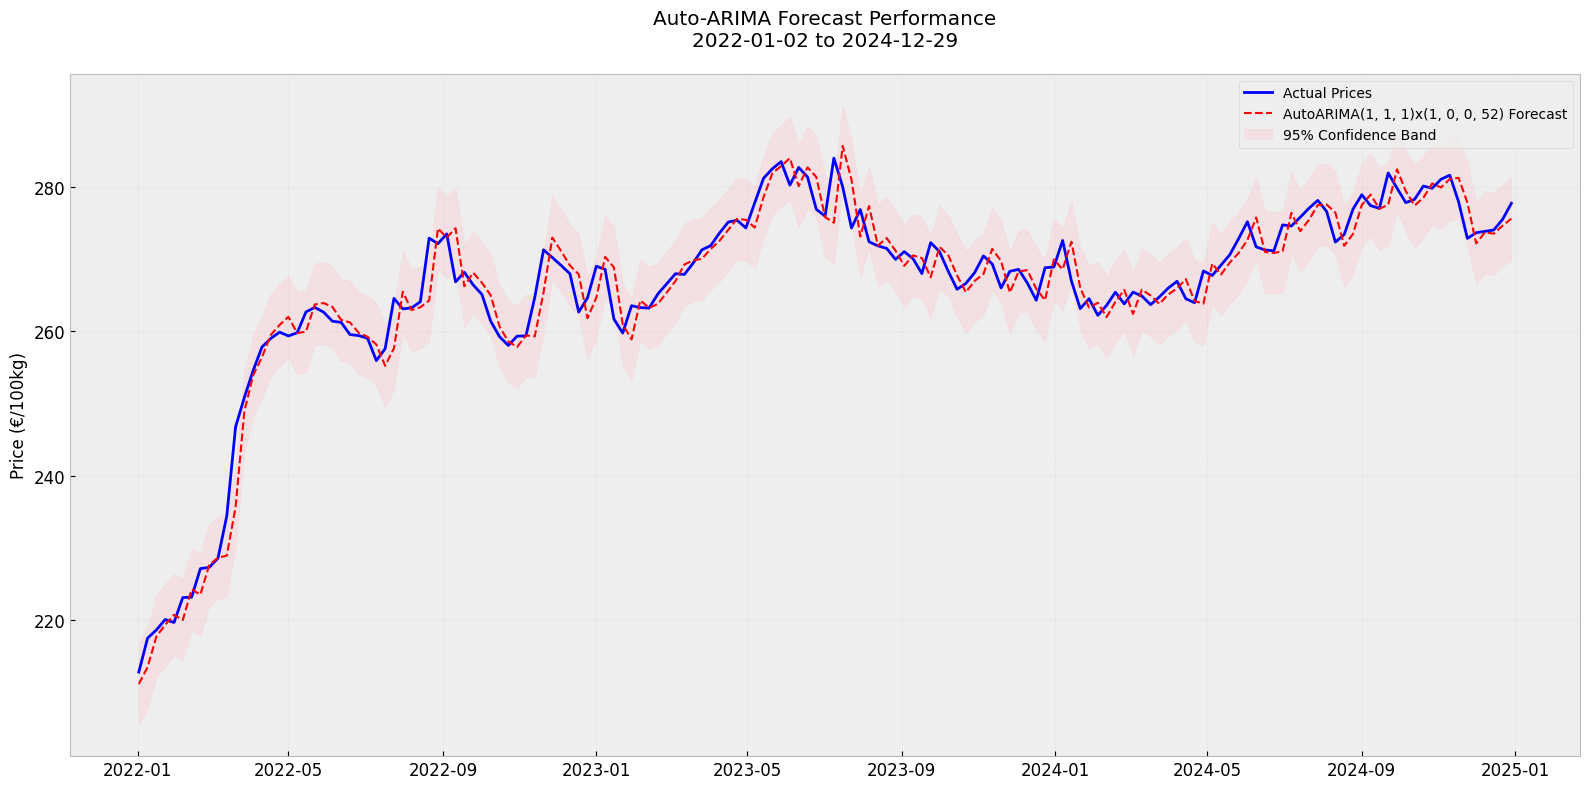

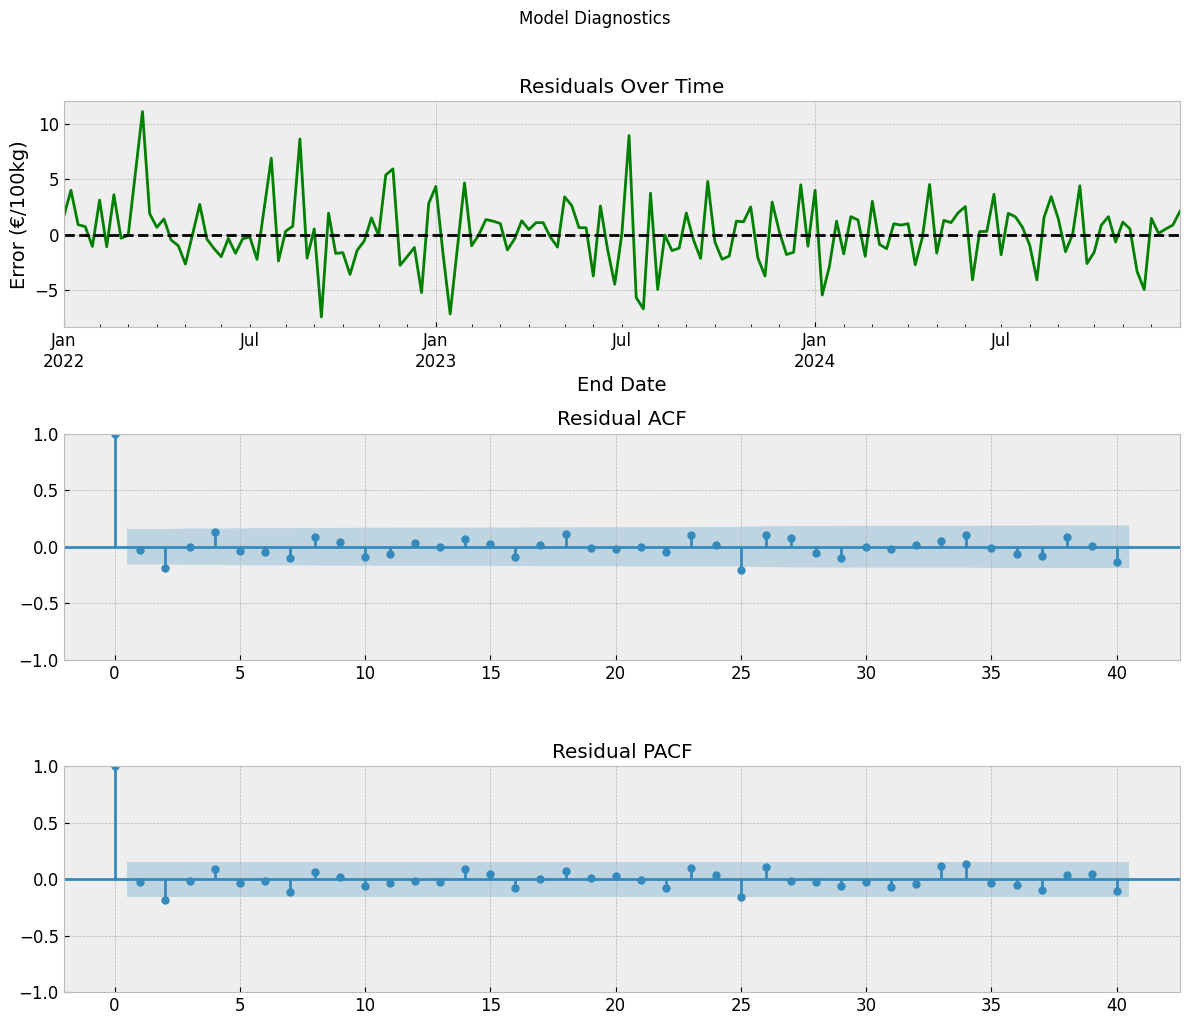

In [14]:
# Enhanced Performance Report
print(f"\n{model_name} Performance:")
print(f"Training Period: {len(train)} weeks")
print(f"Testing Period: {len(test)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")
# print(f"R2: {results_dict[model_name]['R2']:.3f}")

# Visual comparison with improved formatting
plt.figure(figsize=(16, 8))
plt.plot(test[target_col], label='Actual Prices', color='blue', linewidth=2)
plt.plot(yhat_series, label=f'{model_name} Forecast', color='red', linestyle='--', linewidth=1.5)

# Highlight 95% confidence interval if available
try:
    conf_int = auto_model.conf_int()
    plt.fill_between(test.index,
                    yhat_series - 1.96*results_dict[model_name]['RMSE'],
                    yhat_series + 1.96*results_dict[model_name]['RMSE'],
                    color='pink', alpha=0.3, label='95% Confidence Band')
except:
    pass

plt.title(f'Auto-ARIMA Forecast Performance\n{test.index[0].date()} to {test.index[-1].date()}', pad=20)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Enhanced Residual Diagnostics
residuals = test[target_col] - yhat_series

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Model Diagnostics', y=1.02)

# Residual plot
residuals.plot(ax=ax1, color='green', title='Residuals Over Time')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_ylabel('Error (€/100kg)')

# ACF/PACF
plot_acf(residuals, lags=40, ax=ax2, title='Residual ACF')
plot_pacf(residuals, lags=40, ax=ax3, title='Residual PACF', method='ywm')

plt.tight_layout()
plt.show()

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_true, y_pred):
    """Calculate common time series metrics including R-squared."""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,  # Mean Absolute Percentage Error
        'R2': r2_score(y_true, y_pred)  # R-squared metric
    }

# Enhanced Auto-ARIMA Configuration with future forecasting
def run_auto_arima(train, test, target_col='Price (€/100kg)', exog_cols=None, forecast_steps=52):
    """Comprehensive Auto-ARIMA workflow with walk-forward validation and future forecasting"""
    
    # 1. Model Selection with more thorough search
    print("\nRunning Auto-ARIMA model selection...")
    auto_model = pm.auto_arima(
        train[target_col],
        exogenous=train[exog_cols] if exog_cols else None,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        seasonal=True,  # Enable seasonal search
        m=52,  # Weekly data with yearly seasonality
        max_p=5,
        max_d=2,
        max_q=5,
        max_P=2,
        max_D=1,
        max_Q=2,
        stepwise=True,
        n_jobs=-1,  # Use all cores
        information_criterion='aic',
        n_fits=50  # Increase number of fits
    )
    
    print(f"\nBest Model: {auto_model}")
    print(f"Seasonal Order: {auto_model.seasonal_order}")
    
    # 2. Walk-forward validation with improved error handling
    yhat_auto = []
    test_dates = test.index
    
    for t in tqdm(range(len(test)), desc="Auto-ARIMA Walk-Forward Validation"):
        try:
            # Create expanding window
            history = pd.concat([train[target_col], test[target_col].iloc[:t]])
            exog_history = pd.concat([train[exog_cols], test[exog_cols].iloc[:t]]) if exog_cols else None
            
            # Fit model with selected order
            model = ARIMA(
                history,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                exog=exog_history
            )
            model_fit = model.fit()
            
            # Forecast with exogenous vars if needed
            forecast_exog = test[exog_cols].iloc[[t]] if exog_cols else None
            forecast = model_fit.get_forecast(steps=1, exog=forecast_exog)
            yhat_auto.append(forecast.predicted_mean.iloc[0])
            
        except Exception as e:
            print(f"\nWarning at t={t}: {str(e)}")
            # Fallback strategies
            if len(yhat_auto) > 0:
                # Use last successful forecast
                yhat_auto.append(yhat_auto[-1])
            else:
                # Use last training observation
                yhat_auto.append(train[target_col].iloc[-1])
    
    # Create results series
    yhat_series = pd.Series(yhat_auto, index=test_dates)
    
    # 3. Forecast future 52 weeks
    print("\nGenerating 52-week future forecast...")
    full_data = pd.concat([train, test])
    
    # For future exogenous variables, we need to either:
    # - Have actual future values (unlikely)
    # - Use forecasts/assumptions for these variables
    # Here we'll assume the last available values persist (naive approach)
    # In practice, you should replace this with proper forecasts for each exogenous variable
    
    if exog_cols:
        # Create future exogenous dataframe (last values repeated)
        last_exog = test[exog_cols].iloc[-1:]
        future_exog = pd.concat([last_exog] * forecast_steps)
        future_exog.index = pd.date_range(start=test.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')
    else:
        future_exog = None
    
    # Fit final model on all available data
    final_model = ARIMA(
        full_data[target_col],
        order=auto_model.order,
        seasonal_order=auto_model.seasonal_order,
        exog=full_data[exog_cols] if exog_cols else None
    )
    final_model_fit = final_model.fit()
    
    # Generate forecast
    forecast = final_model_fit.get_forecast(steps=forecast_steps, exog=future_exog)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    
    # Create future dates (weekly frequency)
    future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')
    forecast_series = pd.Series(forecast_values.values, index=future_dates)
    
    return auto_model, yhat_series, forecast_series, forecast_conf_int

# Select key exogenous variables (modify as needed)
exog_cols = ['Molasses', 'Maize Gluten Feed', 'Rape Seed Meal', 'Soya Beans', 'Food_Inflation_Rate']

# Run enhanced Auto-ARIMA with future forecasting
auto_model, yhat_series, forecast_series, conf_int = run_auto_arima(
    train, 
    test, 
    target_col=target_col,
    exog_cols=exog_cols,
    forecast_steps=52  # Forecast 52 weeks into future
)

# Store results
model_name = f'AutoARIMA{auto_model.order}x{auto_model.seasonal_order}'
predictions_dict[model_name] = yhat_series
results_dict[model_name] = evaluate(test[target_col], yhat_series)

# Enhanced Performance Report
print(f"\n{model_name} Performance:")
print(f"Training Period: {len(train)} weeks")
print(f"Testing Period: {len(test)} weeks")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")
print(f"R2: {results_dict[model_name]['R2']:.3f}")

# Visual comparison with improved formatting including future forecast
plt.figure(figsize=(16, 8))
plt.plot(test[target_col], label='Actual Prices', color='blue', linewidth=2)
plt.plot(yhat_series, label=f'{model_name} Forecast', color='red', linestyle='--', linewidth=1.5)
plt.plot(forecast_series, label='Future Forecast', color='green', linestyle='--', linewidth=1.5)

# Highlight confidence intervals
plt.fill_between(forecast_series.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='green', alpha=0.1, label='95% Confidence Interval')

# Add vertical line to separate forecast period
last_actual_date = test.index[-1]
plt.axvline(x=last_actual_date, color='gray', linestyle=':', linewidth=1)

plt.title(f'Auto-ARIMA Forecast Performance with 1-Year Projection\n{test.index[0].date()} to {forecast_series.index[-1].date()}', pad=20)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Enhanced Residual Diagnostics
residuals = test[target_col] - yhat_series

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Model Diagnostics', y=1.02)

# Residual plot
residuals.plot(ax=ax1, color='green', title='Residuals Over Time')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_ylabel('Error (€/100kg)')

# ACF/PACF
plot_acf(residuals, lags=40, ax=ax2, title='Residual ACF')
plot_pacf(residuals, lags=40, ax=ax3, title='Residual PACF', method='ywm')

plt.tight_layout()
plt.show()

# Print future forecast
print("\nFuture 52-week Forecast:")
print(forecast_series.head(10))  # Show first 10 weeks of forecast

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

Optimized SARIMA: 100%|██████████| 157/157 [26:06<00:00,  9.98s/it]



SARIMAX(2, 1, 1)x(1, 0, 1, 52) Performance:
Training: 678 weeks | Test: 157 weeks
MAE: 4.9407
RMSE: 7.1213
MAPE: 1.8875
R2: 0.7320
Theil_U: 0.0134


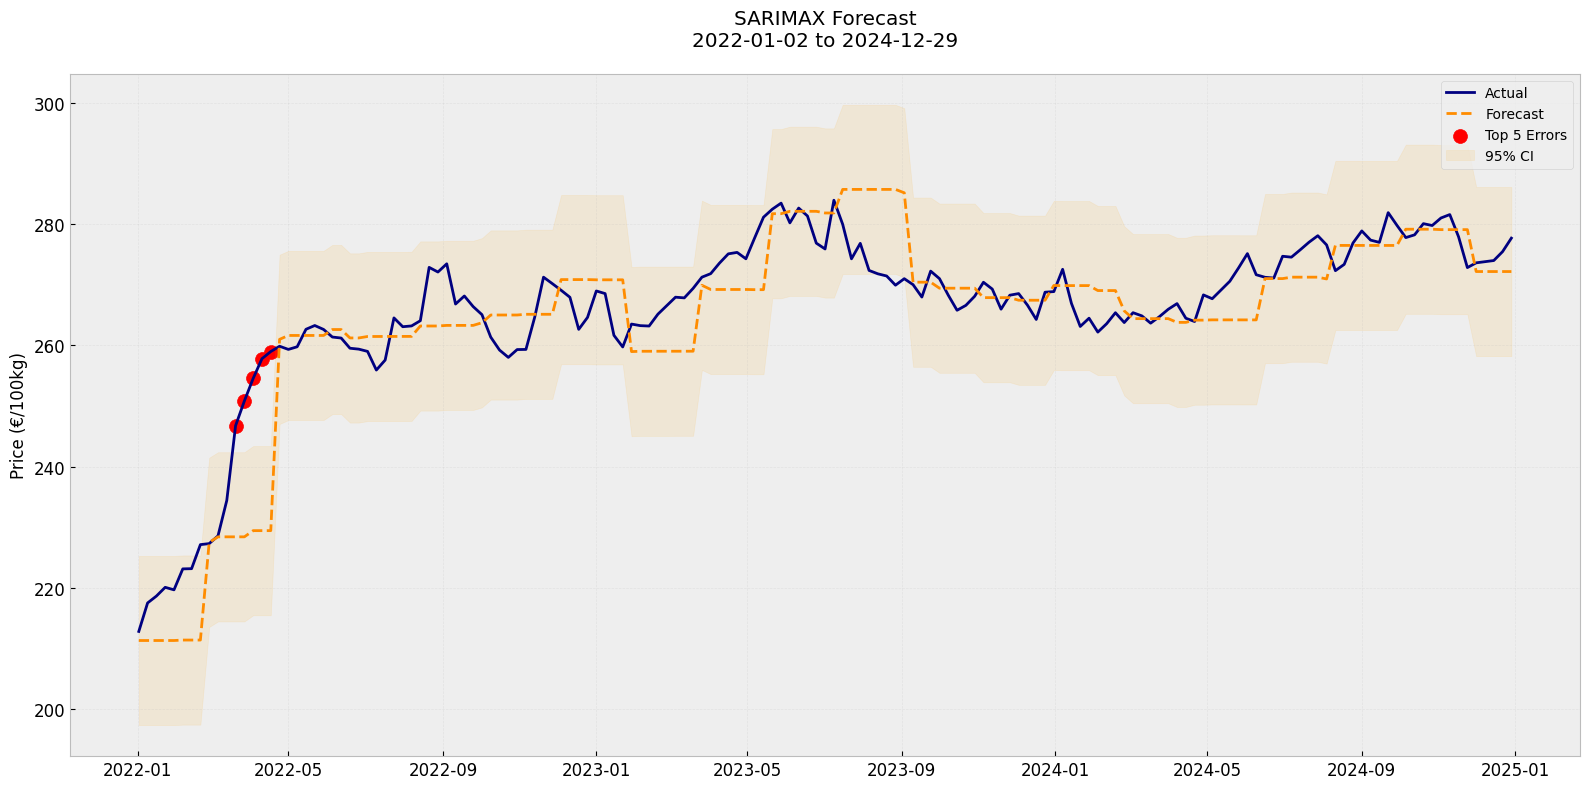

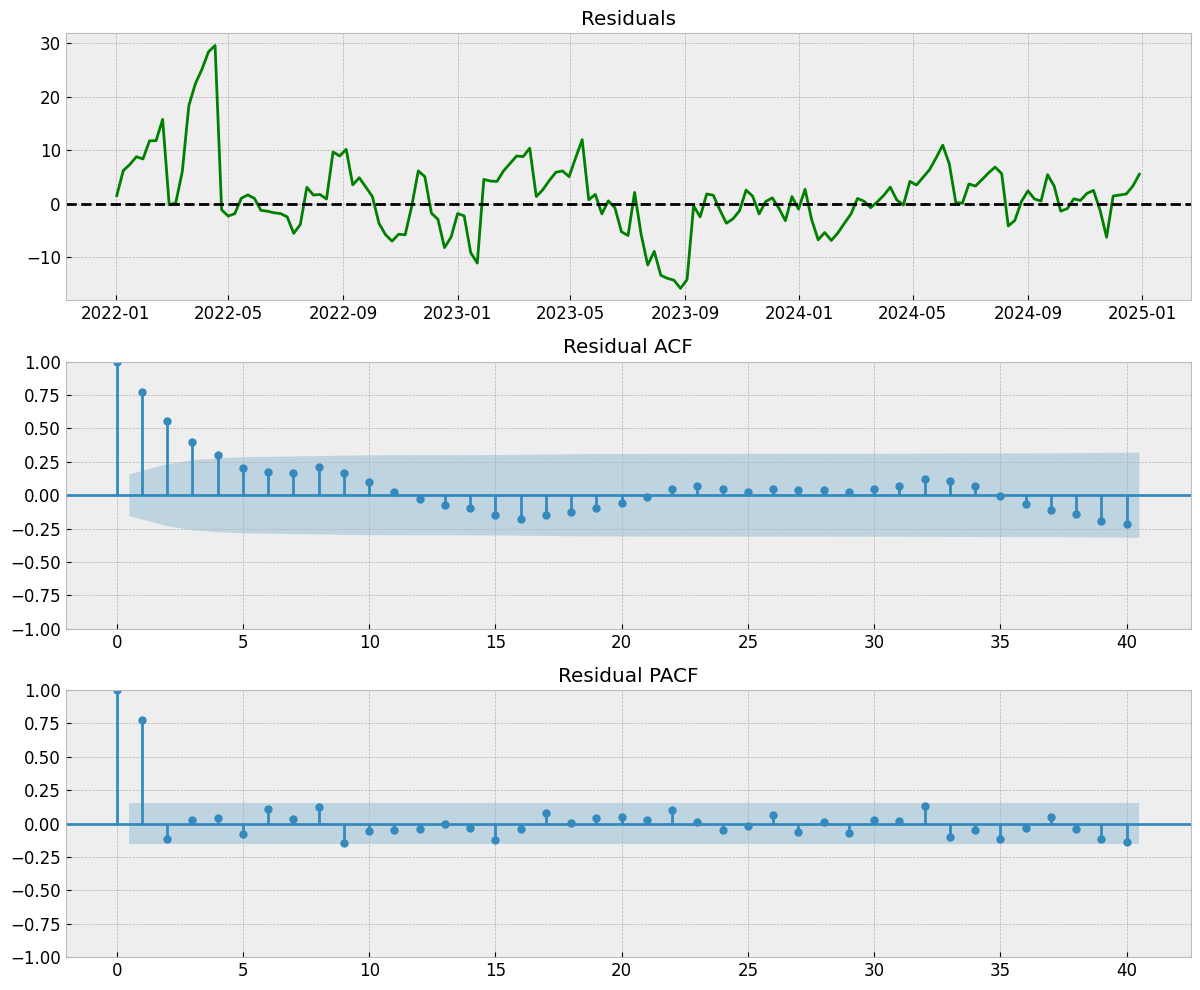


Feature Impacts:


NameError: name 'model_fit' is not defined

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Enhanced SARIMA Configuration
def run_sarima(train, test, target_col='Price (€/100kg)', exog_cols=None, 
               order=(2,1,1), seasonal_order=(2,1,1,52)):
    """Optimized SARIMA with walk-forward validation"""
    
    # Pre-allocate
    yhat_sarima = np.zeros(len(test))
    test_dates = test.index
    
    # Use exogenous variables if provided
    use_exog = exog_cols is not None
    
    # Warm-start model (initial fit on training data)
    model = SARIMAX(
        train[target_col],
        exog=train[exog_cols] if use_exog else None,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True,
        time_varying_regression=False,  # Allow changing relationships
        mle_regression=True  # Explicitly set (default)
    )
    model_fit = model.fit(disp=False, maxiter=200)
    
    # Walk-forward validation with refit every 8 weeks
    for t in tqdm(range(len(test)), desc="Optimized SARIMA"):
        try:
            if t % 8 == 0:  # Refit periodically
                history = pd.concat([train[target_col], test[target_col].iloc[:t]])
                exog_data = pd.concat([train[exog_cols], test[exog_cols].iloc[:t]]) if use_exog else None
                
                model = SARIMAX(
                    history,
                    exog=exog_data,
                    order=order,
                    seasonal_order=seasonal_order,
                    time_varying_regression=False,
                    mle_regression=True
                )
                model_fit = model.fit(disp=False, maxiter=150)
            
            # Forecast with current exogenous data
            forecast_exog = test[exog_cols].iloc[[t]] if use_exog else None
            forecast = model_fit.get_forecast(steps=1, exog=forecast_exog)
            yhat_sarima[t] = forecast.predicted_mean.iloc[0]
            
        except Exception as e:
            print(f"Warning at t={t}: {str(e)}")
            yhat_sarima[t] = yhat_sarima[t-1] if t > 0 else train[target_col].iloc[-1]
    
    return pd.Series(yhat_sarima, index=test_dates), model_fit

# Run with your correlated features
exog_cols = ['Molasses', 'Maize Gluten Feed', 'Rape Seed Meal', 'Soya Beans', 'Food_Inflation_Rate']
order = (2, 1, 1)  # Non-seasonal order
seasonal_order = (1, 0, 1, 52)  # Lighter seasonal terms based on AutoARIMA results

yhat_sarima, model_fit = run_sarima(
    train, 
    test,
    target_col=target_col,
    exog_cols=exog_cols,
    order=order,
    seasonal_order=seasonal_order
)

# Enhanced Evaluation
def enhanced_evaluate(actual, predicted):
    residuals = actual - predicted
    metrics = {
        'MAE': mean_absolute_error(actual, predicted),
        'RMSE': np.sqrt(np.mean(residuals**2)),
        'MAPE': np.mean(np.abs(residuals/actual))*100,
        'R2': 1 - (np.sum(residuals**2)/np.sum((actual-np.mean(actual))**2)),
        'Theil_U': np.sqrt(np.mean(residuals**2))/(np.sqrt(np.mean(actual**2)) + np.sqrt(np.mean(predicted**2)))
    }
    return metrics

# Store results
model_name = f'SARIMAX{order}x{seasonal_order}'
results = enhanced_evaluate(test[target_col], yhat_sarima)

print(f"\n{model_name} Performance:")
print(f"Training: {len(train)} weeks | Test: {len(test)} weeks")
for k,v in results.items():
    print(f"{k}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")

# Enhanced Visualization
plt.figure(figsize=(16,8))
plt.plot(test[target_col], label='Actual', color='navy', linewidth=2)
plt.plot(yhat_sarima, label='Forecast', color='darkorange', linestyle='--')

# Highlight largest errors
errors = (test[target_col] - yhat_sarima).abs()
top_errors = errors.nlargest(5)
plt.scatter(top_errors.index, test[target_col][top_errors.index], 
            color='red', s=100, label='Top 5 Errors')

plt.fill_between(test.index,
                yhat_sarima - 1.96*results['RMSE'],
                yhat_sarima + 1.96*results['RMSE'],
                color='orange', alpha=0.1, label='95% CI')

plt.title(f'SARIMAX Forecast\n{test.index[0].date()} to {test.index[-1].date()}', pad=20)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Advanced Diagnostics
fig, axes = plt.subplots(3, 1, figsize=(12,10))
residuals = test[target_col] - yhat_sarima

# Residual plot
axes[0].plot(residuals, color='green')
axes[0].axhline(0, color='k', linestyle='--')
axes[0].set_title('Residuals')

# ACF/PACF
plot_acf(residuals, lags=40, ax=axes[1], title='Residual ACF')
plot_pacf(residuals, lags=40, ax=axes[2], title='Residual PACF', method='ywm')

plt.tight_layout()
plt.show()

# Feature Impact Analysis (if using exogenous vars)
if exog_cols:
    print("\nFeature Impacts:")
    impacts = pd.DataFrame({
        'Feature': exog_cols,
        'Coefficient': model_fit.params[-len(exog_cols):],
        'P-value': model_fit.pvalues[-len(exog_cols):]
    })
    print(impacts.sort_values('Coefficient', key=abs, ascending=False))

#### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=71.07 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2606.342, Time=1.76 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2484.105, Time=7.07 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=12.51 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=2604.594, Time=0.86 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=18.06 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=11.32 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=2483.870, Time=3.37 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=12.17 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=13.22 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=2484.062, Time=4.22 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=2485.881, Time=8.79 sec
 ARIMA(0,1,0)(1,1,0)[52] intercept   : AIC=2484.971, Time=11.71 sec

Best model:  ARIMA(0,1,0)(1,1,0)[52]          
Total fit time: 176.165 seconds

Selected Order: (0, 1, 0)
Se

Auto-SARIMAX Forecasting: 100%|██████████| 157/157 [2:24:04<00:00, 55.06s/it] 



AutoSARIMAX(0, 1, 0)x(1, 1, 0, 52) Performance:
MAE: 2.61 €/100kg
RMSE: 3.40 €/100kg
MAPE: 0.99%


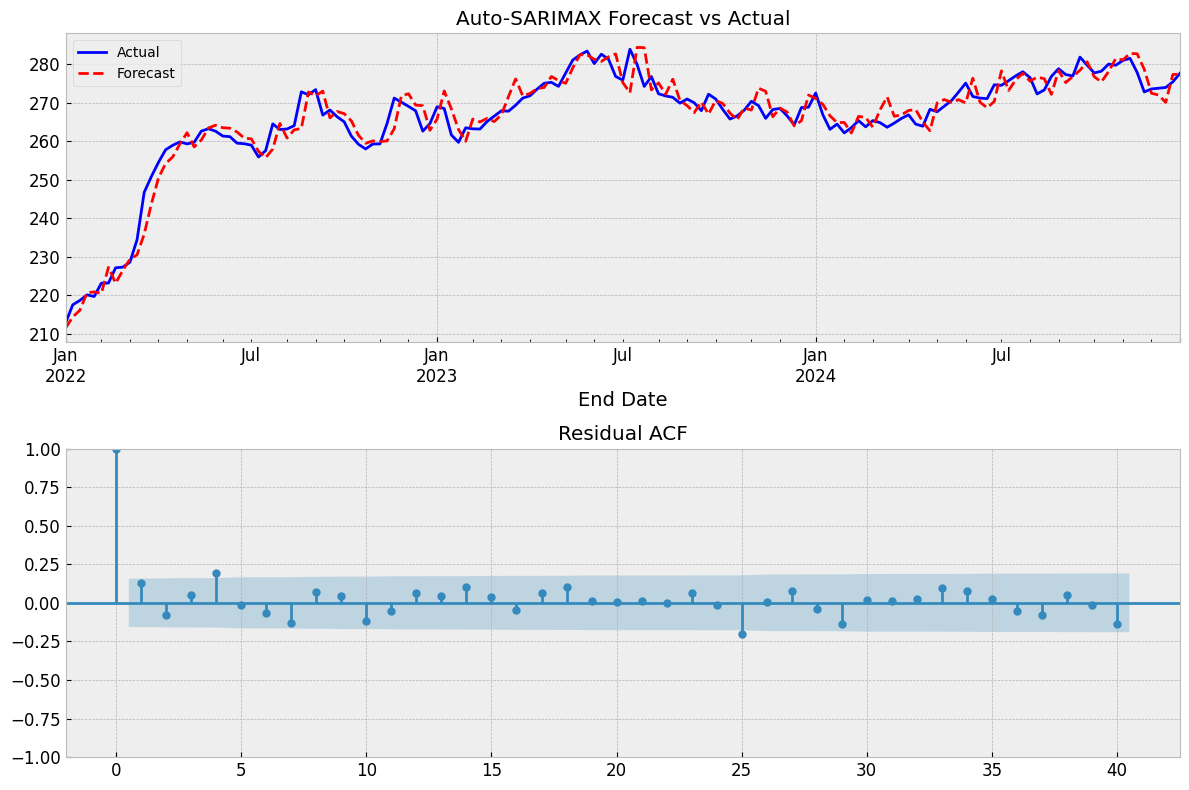

In [18]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
target_col = 'Price (€/100kg)'
exog_cols = ['Molasses', 'Maize Gluten Feed', 'Rape Seed Meal', 'Soya Beans', 'Food_Inflation_Rate']

# Auto-SARIMAX Model Selection (with exogenous variables)
auto_model = auto_arima(
    train[target_col],
    exogenous=train[exog_cols],
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    seasonal=True,
    m=52,  # Weekly data with yearly seasonality
    stepwise=True,
    max_p=3,
    max_q=3,
    max_P=1,
    max_Q=1,
    d=1, 
    D=1,    # Seasonal differencing
    test='adf',
    information_criterion='aic',
    n_fits=30
)

print(f"\nSelected Order: {auto_model.order}")
print(f"Seasonal Order: {auto_model.seasonal_order}")

# Walk-forward validation with exogenous variables
yhat = []
test_dates = test.index

for t in tqdm(range(len(test)), desc="Auto-SARIMAX Forecasting"):
    try:
        # Expanding window with exogenous vars
        history = pd.concat([train[target_col], test[target_col].iloc[:t]])
        exog_history = pd.concat([train[exog_cols], test[exog_cols].iloc[:t]])
        
        model = SARIMAX(
            history,
            exog=exog_history,
            order=auto_model.order,
            seasonal_order=auto_model.seasonal_order,
            enforce_stationarity=True,
            enforce_invertibility=False  # Relax for better convergence
        )
        model_fit = model.fit(disp=False, maxiter=200)
        
        # Forecast with next exogenous values
        forecast_exog = test[exog_cols].iloc[[t]]
        pred = model_fit.get_forecast(steps=1, exog=forecast_exog)
        yhat.append(pred.predicted_mean.iloc[0])
        
    except Exception as e:
        print(f"Error at t={t}: {str(e)}")
        yhat.append(yhat[-1] if len(yhat) > 0 else train[target_col].iloc[-1])

# Convert to Series
yhat_series = pd.Series(yhat, index=test_dates)

# Store results
model_name = f'AutoSARIMAX{auto_model.order}x{auto_model.seasonal_order}'
results_dict[model_name] = evaluate(test[target_col], yhat_series)
predictions_dict[model_name] = yhat_series

# Performance Report
print(f"\n{model_name} Performance:")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Visual Diagnostics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
test[target_col].plot(ax=ax1, label='Actual', color='blue')
yhat_series.plot(ax=ax1, label='Forecast', color='red', linestyle='--')
ax1.set_title('Auto-SARIMAX Forecast vs Actual')
ax1.legend()

residuals = test[target_col] - yhat_series
plot_acf(residuals, lags=40, ax=ax2, title='Residual ACF')
plt.tight_layout()
plt.show()

### Prophet

Prophet is a model released by [facebook](https://github.com/facebook/prophet). Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.

In [14]:
!pip install prophet

16:14:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
MAE: 29.27 €/100kg
RMSE: 35.41 €/100kg
MAPE: 10.81%


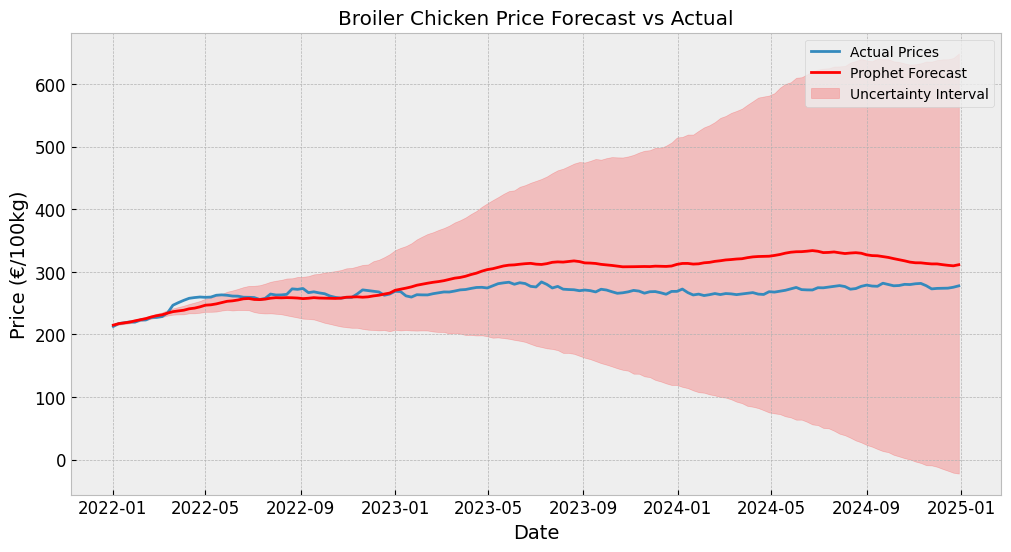

In [32]:
# Prepare Prophet data format
prophet_training = train.rename(columns={'Price (€/100kg)': 'y'})  # Rename target column
prophet_training['ds'] = prophet_training.index  # Prophet requires 'ds' datetime column
prophet_training.index = pd.RangeIndex(len(prophet_training.index))  # Reset index

prophet_test = test.rename(columns={'Price (€/100kg)': 'y'})
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

# Enhanced Prophet model configuration
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5,  # More flexible trend changes
    seasonality_prior_scale=15.0,  # Stronger seasonality
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    n_changepoints=50  # More potential changepoints
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=15  # Reduced from 55 to prevent overfitting
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=15  # Reduced from 25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=15  # Reduced from 55
).add_country_holidays(country_name='Germany')  # Changed to Germany (adjust as needed)

# Add COVID impact as special event
covid_impact = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-01']),
    'lower_window': 0,
    'upper_window': 365  # 1-year impact window
})
prophet.holidays = pd.concat([prophet.holidays, covid_impact])

# Fit model
prophet.fit(prophet_training)

# Make predictions
future = prophet.make_future_dataframe(periods=len(prophet_test), freq='W')  # Weekly frequency
forecast = prophet.predict(future)

# Store results
model_name = f'Prophet'
yhat_prophet = forecast.iloc[-len(prophet_test):]['yhat']
results_dict['Prophet'] = evaluate(test['Price (€/100kg)'], yhat_prophet.values)
predictions_dict['Prophet'] = yhat_prophet.values

# Performance Report
print(f"\n{model_name} Performance:")
print(f"MAE: {results_dict[model_name]['MAE']:.2f} €/100kg")
print(f"RMSE: {results_dict[model_name]['RMSE']:.2f} €/100kg")
print(f"MAPE: {results_dict[model_name]['MAPE']:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Price (€/100kg)'], label='Actual Prices')
plt.plot(test.index, yhat_prophet, color='red', label='Prophet Forecast')
plt.fill_between(
    test.index,
    forecast.iloc[-len(test):]['yhat_lower'],
    forecast.iloc[-len(test):]['yhat_upper'],
    color='red', alpha=0.2, label='Uncertainty Interval'
)
plt.title('Broiler Chicken Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (€/100kg)')
plt.legend()
plt.grid(True)
plt.show()

## Multivariate time series forecasting

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Modified function for your context
def create_time_features(df, target=None, features=None):
    """
    Creates time series features from datetime index and combines with selected features
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['cos_day'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    # Add lag features (example: previous week's price)
    df['price_lag1'] = df[target_col].shift(1)
    
    # Add rolling statistics (example: 4-week moving average)
    df['price_rolling_mean4'] = df[target_col].rolling(window=4).mean()
    
    X = df.drop(['date'], axis=1)
    
    if target:
        y = df[target]
        if features:
            # Include both time features and selected features
            X = X[features + [col for col in X.columns if col not in df.columns[:-1]]]
        else:
            X = X.drop([target], axis=1)
        return X, y

    return X

In [18]:
# Configuration
target_col = 'Price (€/100kg)'
selected_features = ['Molasses', 'Maize Gluten Feed', 'Rape Seed Meal', 'Soya Beans', 'Food_Inflation_Rate']

# Create features for train and test sets
X_train_df, y_train = create_time_features(
    train, target=target_col, features=selected_features)
X_test_df, y_test = create_time_features(
    test, target=target_col, features=selected_features)

# Handle NaN values from lag/rolling features
X_train_df = X_train_df.fillna(X_train_df.mean())
X_test_df = X_test_df.fillna(X_train_df.mean())  # Use train mean to avoid data leakage

# Scale the features
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns, index=train.index)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns, index=test.index)

# Keep y as Series with proper index
y_train = pd.Series(y_train, index=train.index)
y_test = pd.Series(y_test, index=test.index)

print("Training features shape:", X_train_df.shape)
print("Testing features shape:", X_test_df.shape)

Training features shape: (678, 6)
Testing features shape: (157, 6)


In [58]:
X_train_df.head()

Molasses  Maize Gluten Feed  Rape Seed Meal  Soya Beans  \
End Date                                                              
2009-02-01 -1.731285          -0.875050       -0.943138   -1.138424   
2009-02-08 -1.731285          -0.875050       -0.943138   -1.138424   
2009-02-15 -1.731285          -0.875050       -0.943138   -1.138424   
2009-02-22 -1.731285          -0.875050       -0.943138   -1.138424   
2009-03-01 -1.648390          -0.974118       -1.093950   -1.194727   

            Food_Inflation_Rate  price_rolling_mean4  
End Date                                              
2009-02-01             1.387824             0.000000  
2009-02-08             1.387824             0.000000  
2009-02-15             1.387824             0.000000  
2009-02-22             1.387824            -0.964517  
2009-03-01             0.945662            -0.982517

### Linear models

#### Bayesian regression

Cross-validation MAE scores: [1.2764543872015492, 1.2464792150883972, 1.0395148509701337, 0.9678568164735486, 1.7111004383622832]
Mean CV MAE: 1.25 €/100kg
Training MAE: 1.17 €/100kg
Test MAE: 2.75 €/100kg


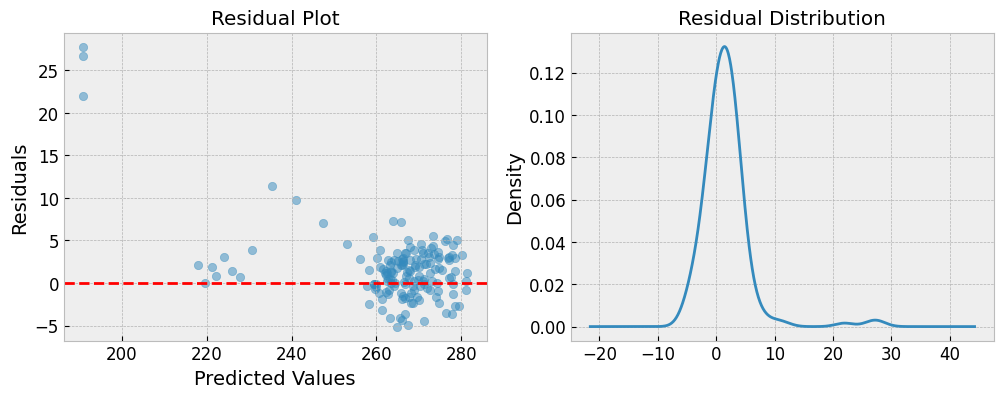


Top Feature Importance:
 price_rolling_mean4    9.093500
Soya Beans             0.291594
Rape Seed Meal         0.289208
Food_Inflation_Rate    0.020650
Molasses              -0.096157
Maize Gluten Feed     -0.111433
dtype: float64

BayesianRidge Performance:
MAE: 2.75 €/100kg
RMSE: 4.59 €/100kg
MAPE: 1.07%


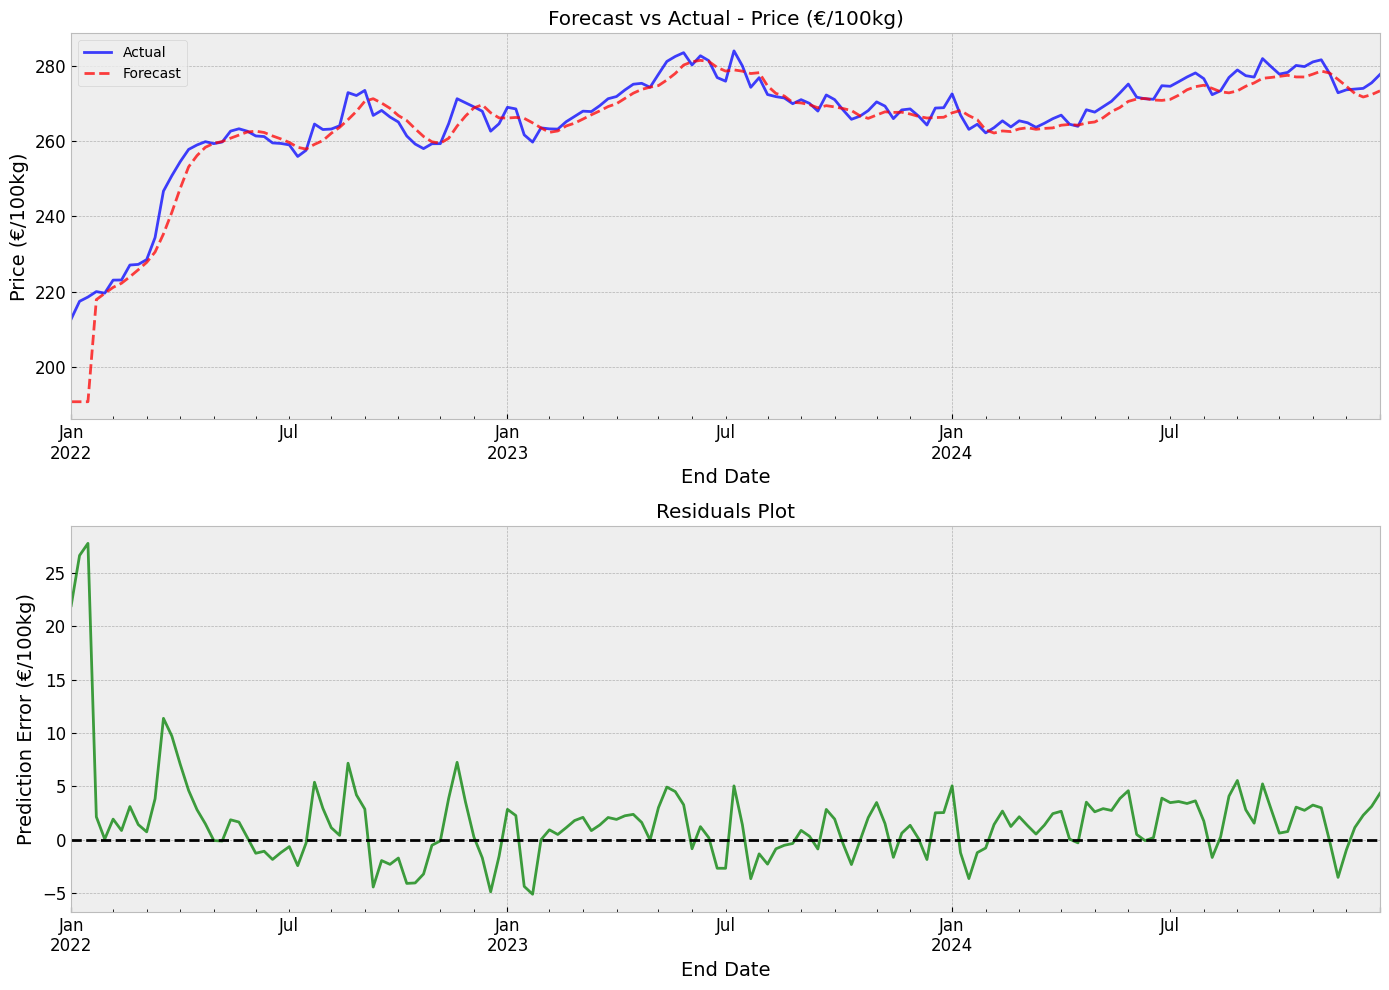

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Define enhanced evaluation metrics
def evaluate(y_true, y_pred):
    """Calculate comprehensive time series metrics."""
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
    }
    return metrics

# Bayesian Regression with enhancements
def run_bayesian_regression(X_train, y_train, X_test, y_test, target_col):
    # Create polynomial feature names first
    poly = PolynomialFeatures(degree=1, include_bias=False)
    poly.fit(X_train)  # Just fit to get feature names
    
    # Get polynomial feature names
    original_features = X_train.columns
    poly_feature_names = poly.get_feature_names_out(original_features)
    
    # Create pipeline
    model = make_pipeline(
        poly,
        linear_model.BayesianRidge(
            n_iter=300,
            compute_score=True,
            alpha_1=1e-6,
            alpha_2=1e-6,
            lambda_1=1e-6,
            lambda_2=1e-6
        )
    )
    
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    for train_index, val_index in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        cv_scores.append(mean_absolute_error(y_val_cv, y_pred_cv))
    
    print(f"Cross-validation MAE scores: {cv_scores}")
    print(f"Mean CV MAE: {np.mean(cv_scores):.2f} €/100kg")
    
    # Final training
    model.fit(X_train, y_train)

    # After model training:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"Training MAE: {train_mae:.2f} €/100kg")
    print(f"Test MAE: {test_mae:.2f} €/100kg")

    residuals = y_test - y_test_pred

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    
    plt.subplot(1, 2, 2)
    pd.Series(residuals).plot(kind="kde")
    plt.title("Residual Distribution")
    plt.show()
    
    # Feature importance with correct polynomial feature names
    if hasattr(model.named_steps['bayesianridge'], 'coef_'):
        feature_importance = pd.Series(
            model.named_steps['bayesianridge'].coef_,
            index=poly_feature_names
        ).sort_values(ascending=False)
        print("\nTop Feature Importance:\n", feature_importance.head(10))
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    # Evaluation
    results = evaluate(y_test, y_pred)
    
    # Performance Report
    print("\nBayesianRidge Performance:")
    print(f"MAE: {results['MAE']:.2f} €/100kg")
    print(f"RMSE: {results['RMSE']:.2f} €/100kg")
    print(f"MAPE: {results['MAPE']:.2f}%")
    
    # Visual Diagnostics
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Forecast vs Actual plot
    y_test.plot(ax=ax1, label='Actual', color='blue', alpha=0.75)
    y_pred_series.plot(ax=ax1, label='Forecast', color='red', linestyle='--', alpha=0.75)
    ax1.set_title(f'Forecast vs Actual - {target_col}')
    ax1.set_ylabel('Price (€/100kg)')
    ax1.legend()
    
    # Residuals plot
    residuals = y_test - y_pred
    residuals.plot(ax=ax2, color='green', alpha=0.75)
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_title('Residuals Plot')
    ax2.set_ylabel('Prediction Error (€/100kg)')
    
    plt.tight_layout()
    plt.show()
    
    return model, results, y_pred_series

# Run the enhanced Bayesian regression
bayesian_model, bayesian_results, bayesian_predictions = run_bayesian_regression(
    X_train_df, y_train, X_test_df, y_test, target_col)

#### Lasso

Optimal alpha: 0.10481
Number of features used: 3/6

Training Performance:
MAE: 1.17 €/100kg | RMSE: 1.50 | MAPE: 0.62% | R2: 0.97

Test Performance:
MAE: 3.01 €/100kg | RMSE: 4.80 | MAPE: 1.17% | R2: 0.88


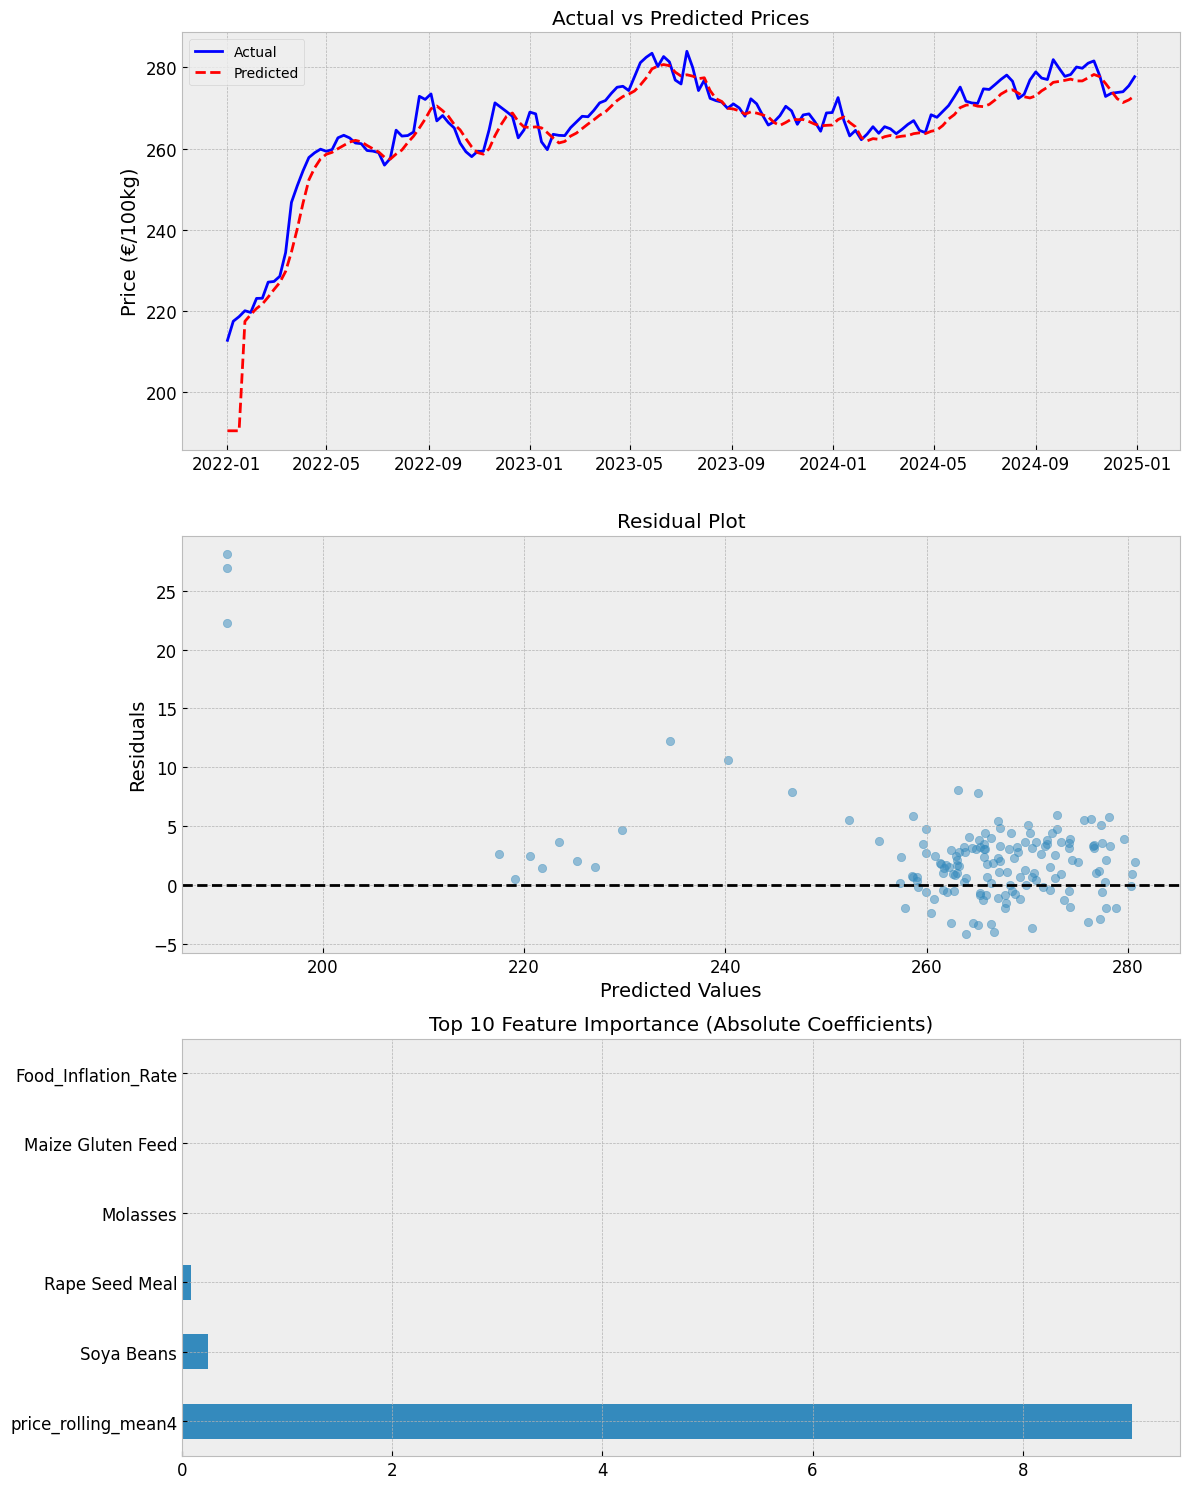

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

def evaluate_time_series(y_true, y_pred):
    """Enhanced evaluation metrics with time-series awareness"""
    residuals = y_true - y_pred
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs(residuals / y_true)) * 100,
        'R2': r2_score(y_true, y_pred),
        'Residual_Std': np.std(residuals)
    }
    return metrics

def plot_lasso_diagnostics(y_true, y_pred, feature_importance):
    """Enhanced diagnostic plots for Lasso results"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Time series plot
    ax1.plot(y_true.index, y_true, label='Actual', color='blue')
    ax1.plot(y_true.index, y_pred, label='Predicted', color='red', linestyle='--')
    ax1.set_title('Actual vs Predicted Prices')
    ax1.set_ylabel('Price (€/100kg)')
    ax1.legend()
    
    # Residual plot
    residuals = y_true - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    
    # Feature importance
    feature_importance.head(10).plot(kind='barh', ax=ax3)
    ax3.set_title('Top 10 Feature Importance (Absolute Coefficients)')
    
    plt.tight_layout()
    plt.show()

def run_lasso_regression(X_train, y_train, X_test, y_test):
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Optimize alpha parameter using time-series CV
    lasso = LassoCV(
        alphas=np.logspace(-4, 0, 50),  # Test a wide range of alphas
        cv=tscv,
        max_iter=10000,  # Ensure convergence
        selection='random',  # Better for correlated features
        random_state=42
    )
    
    # Fit model
    lasso.fit(X_train, y_train)
    
    print(f"Optimal alpha: {lasso.alpha_:.5f}")
    print(f"Number of features used: {np.sum(lasso.coef_ != 0)}/{X_train.shape[1]}")
    
    # Predictions
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    
    # Evaluation
    train_metrics = evaluate_time_series(y_train, y_train_pred)
    test_metrics = evaluate_time_series(y_test, y_test_pred)
    
    print("\nTraining Performance:")
    print(f"MAE: {train_metrics['MAE']:.2f} €/100kg | RMSE: {train_metrics['RMSE']:.2f} | MAPE: {train_metrics['MAPE']:.2f}% | R2: {train_metrics['R2']:.2f}")
    
    print("\nTest Performance:")
    print(f"MAE: {test_metrics['MAE']:.2f} €/100kg | RMSE: {test_metrics['RMSE']:.2f} | MAPE: {test_metrics['MAPE']:.2f}% | R2: {test_metrics['R2']:.2f}")
    
    # Feature importance
    feature_importance = pd.Series(
        np.abs(lasso.coef_),
        index=X_train.columns,
        name='Lasso Coefficients'
    ).sort_values(ascending=False)
    
    # Plot diagnostics
    plot_lasso_diagnostics(y_test, pd.Series(y_test_pred, index=y_test.index), feature_importance)
    
    return lasso, test_metrics, feature_importance

# Run Lasso regression
lasso_model, lasso_metrics, lasso_features = run_lasso_regression(
    X_train_df, y_train, X_test_df, y_test)